In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
from NN_model import DNNClassifier

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf

df = pd.read_csv('samples_nylonGuitar_20480_fingerNpick_Mm7_R1B.csv')
# df = pd.read_csv('samples_nylonGuitar_1024_Mm7_R03.csv')
# df = pd.read_csv('../CachedData.csv')

X_load = np.array(df.iloc[:,:-1], dtype=np.float)
y_load = np.array(df.iloc[:,-1], dtype=np.float)

C:\Users\Denis\AppData\Local\conda\conda\envs\tensorflow_env_gpu\lib\site-packages\librosa\core\spectrum.py:180: ComplexWarning: Casting complex values to real discards the imaginary part
  axis=0)[:stft_matrix.shape[0]].conj()


(512, 326)
(12, 1281)
5.0


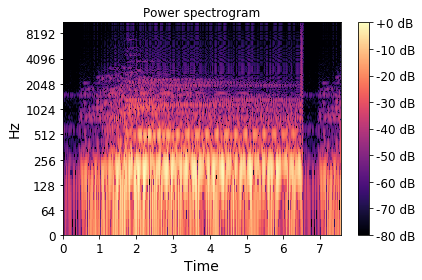

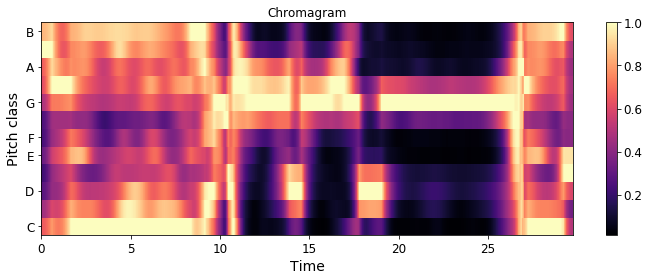

In [7]:
import librosa

sample = librosa.core.stft(y=X_load[0], n_fft=1023, win_length=255, window='hamming', center=True, dtype=np.float, pad_mode='reflect')

sample_chroma = librosa.feature.chroma_stft(y=X_load[200], sr=44100, n_fft=2048, hop_length=16)

print(sample.shape)
print(sample_chroma.shape)
print(y_load[40])

import matplotlib.pyplot as plt
import librosa.display
librosa.display.specshow(librosa.amplitude_to_db(sample,ref=np.max),y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.figure(figsize=(10, 4))
librosa.display.specshow(sample_chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

In [14]:
import os
import librosa.display

processedDataX_path = "preprocessedSamples_X_Mm7_R1B.data"
processedDatay_path = "preprocessedSamples_y_Mm7_R1B.data"
processedData_path = ""

if os.path.isfile(processedData_path): #if already preprocessed
    processedX = np.load(processedDataX_path)
    processedy = np.load(processedDatay_path)
else:
    processedX = np.zeros((len(X_load),12,80,1), dtype=np.float)
    processedy = np.zeros(len(y_load), dtype=np.float)
    for i in range(len(X_load)):
        sample = librosa.core.stft(y=X_load[i], n_fft=2048, win_length=128, window='hamming', center=True, dtype=np.float32, pad_mode='reflect')
        sample = librosa.feature.chroma_stft(y=X_load[i], sr=44100, n_fft=20480, hop_length=258)
        sample = np.atleast_3d(sample)
        processedX[i] = sample
        processedy[i] = y_load[i]
    
    processedX.dump(processedDataX_path)
    processedy.dump(processedDatay_path)

# processedX = np.zeros((len(X_load),10240), dtype=np.float)
# processedy = np.zeros(len(y_load), dtype=np.float)

# for i in range(len(X_load)):
#     sample = np.array(X_load[i], dtype=np.float)
#     sample = sample*np.hamming(20480)
#     sample = np.abs(np.fft.rfft(sample))[1:]
# #     sample = np.reshape(sample,(256,255, 1))
# #     sample = np.append(sample, y[i])
#     processedX[i] = sample
#     processedy[i] = y_load[i]
#     if i % 1000 == 0:
#         print(i)
#         print(sample.shape)

C:\Users\Denis\AppData\Local\conda\conda\envs\tensorflow_env_gpu\lib\site-packages\librosa\core\spectrum.py:180: ComplexWarning: Casting complex values to real discards the imaginary part
  axis=0)[:stft_matrix.shape[0]].conj()


In [21]:
from sklearn.utils import shuffle
print(processedy)
sprocessedX, sprocessedy = shuffle(processedX, processedy)
print(len(sprocessedX))


# for i in range(len(sprocessedy)):
# 	sprocessedy[i] = (sprocessedy[i]) - 1
    
trainRange = int(len(sprocessedX) * 0.7)
validRange = int(len(sprocessedX) * 0.8)
testRange = int(len(sprocessedX) * 0.2)


X_train = np.array(sprocessedX[:trainRange], dtype=np.float)
y_train = np.array(sprocessedy[:trainRange], dtype=np.float)

X_valid = np.array(sprocessedX[trainRange:validRange], dtype=np.float)
y_valid = np.array(sprocessedy[trainRange:validRange], dtype=np.float)

X_test = np.array(sprocessedX[testRange:], dtype=np.float)
y_test = np.array(sprocessedy[testRange:], dtype=np.float)
print(y_test[1])

#print(X_train.shape,y_train.shape, X_valid.shape, y_valid.shape)

len(sprocessedX)

[  0.   0.   0. ...,  47.  47.  47.]
1725
3.0


1725

In [22]:
np.unique(sprocessedy)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.])

In [23]:
import tensorflow as tf

height = 12
width = 80
channels = 1
n_inputs = height * width

conv1_fmaps = 16
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 32
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.4

pool3_fmaps = conv2_fmaps

n_fc1 = 800
fc1_dropout_rate = 0.2

n_outputs = 48

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 6 * 40])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1_drop, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [24]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [25]:
n_epochs = 1000
batch_size = 5

best_loss_val = np.infty
check_interval = 100
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train))
        idx = 0
        for rnd_indices in np.array_split(rnd_idx, len(X_train) // batch_size):
            X_batch, y_batch = X_train[rnd_indices], y_train[rnd_indices]
            X_batch_reshaped = np.reshape(X_batch,(len(X_batch), -1))
            sess.run(training_op, feed_dict={X: X_batch_reshaped, y: y_batch, training: True})
            if idx % check_interval == 0:
                X_valid_reshaped = np.reshape(X_valid,(len(X_valid), -1))
                loss_val = loss.eval(feed_dict={X: X_valid_reshaped,
                                                y: y_valid})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
            idx += 1
        X_batch_reshaped = np.reshape(X_batch,(len(X_batch), -1))
        acc_train = accuracy.eval(feed_dict={X: X_batch_reshaped, y: y_batch})
        X_valid_reshaped = np.reshape(X_valid,(len(X_valid), -1))
        acc_val = accuracy.eval(feed_dict={X: X_valid_reshaped,
                                           y: y_valid})
        print("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_train * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    X_test_reshaped = np.reshape(X_test,(len(X_test), -1))
    acc_test = accuracy.eval(feed_dict={X: X_test_reshaped,
                                        y: y_test})
    print("Final accuracy on test set:", acc_test)
    #save_path = saver.save(sess, "./checkpoints/my_chordRec_model.ckpt")

Epoch 0, train accuracy: 80.0000%, valid. accuracy: 60.6936%, valid. best loss: 1.239738
Epoch 1, train accuracy: 100.0000%, valid. accuracy: 68.7861%, valid. best loss: 0.742532
Epoch 2, train accuracy: 100.0000%, valid. accuracy: 76.8786%, valid. best loss: 0.702498
Epoch 3, train accuracy: 100.0000%, valid. accuracy: 80.9249%, valid. best loss: 0.624083
Epoch 4, train accuracy: 100.0000%, valid. accuracy: 83.8150%, valid. best loss: 0.505121
Epoch 5, train accuracy: 100.0000%, valid. accuracy: 79.1907%, valid. best loss: 0.419613
Epoch 6, train accuracy: 80.0000%, valid. accuracy: 83.2370%, valid. best loss: 0.419613
Epoch 7, train accuracy: 80.0000%, valid. accuracy: 86.1272%, valid. best loss: 0.412288
Epoch 8, train accuracy: 100.0000%, valid. accuracy: 87.2832%, valid. best loss: 0.412288
Epoch 9, train accuracy: 100.0000%, valid. accuracy: 87.8613%, valid. best loss: 0.412288
Epoch 10, train accuracy: 100.0000%, valid. accuracy: 88.4393%, valid. best loss: 0.412288
Epoch 11, tr

In [10]:
X_train_reshaped = np.reshape(X_train,(len(X_train), -1))
X_valid_reshaped = np.reshape(X_valid,(len(X_valid), -1))
X_test_reshaped = np.reshape(X_test,(len(X_test), -1))

he_init = tf.contrib.layers.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=0, n_neurons=300, name=None,
        activation=tf.nn.elu):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=he_init,
                                     name="hidden%d" % (layer + 1))
        return inputs
    
def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu


n_inputs = 10240
n_outputs = 48

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

dnn_outputs = dnn(X)

n_neurons_hidden1 = 700
hidden1 = tf.layers.dense(X, n_neurons_hidden1, activation=leaky_relu(), name="fc1")

dropout_hidden1 = 0.4
hidden1_drop = tf.layers.dropout(hidden1, dropout_hidden1)

logits = tf.layers.dense(hidden1_drop, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

learning_rate = 0.05

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdagradOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [13]:
n_epochs = 100
batch_size = 20

max_checks_without_progress = 30
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train_reshaped))
        for rnd_indices in np.array_split(rnd_idx, len(X_train_reshaped) // batch_size):
            X_batch, y_batch = X_train_reshaped[rnd_indices], y_train[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid_reshaped, y: y_valid})
        if loss_val < best_loss:
            #save_path = saver.save(sess, "checkpoints/chord_recognizer_model.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))
    acc_test = accuracy.eval(feed_dict={X: X_test_reshaped, y: y_test})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))
    

0	Validation loss: 6.229672	Best loss: 6.229672	Accuracy: 62.79%
1	Validation loss: 0.800890	Best loss: 0.800890	Accuracy: 86.05%
2	Validation loss: 0.693056	Best loss: 0.693056	Accuracy: 86.05%
3	Validation loss: 0.369835	Best loss: 0.369835	Accuracy: 88.37%
4	Validation loss: 0.308786	Best loss: 0.308786	Accuracy: 92.44%
5	Validation loss: 0.943879	Best loss: 0.308786	Accuracy: 88.37%
6	Validation loss: 0.258311	Best loss: 0.258311	Accuracy: 91.86%
7	Validation loss: 0.267080	Best loss: 0.258311	Accuracy: 93.60%
8	Validation loss: 0.277454	Best loss: 0.258311	Accuracy: 92.44%
9	Validation loss: 0.281729	Best loss: 0.258311	Accuracy: 93.02%
10	Validation loss: 0.287909	Best loss: 0.258311	Accuracy: 93.02%
11	Validation loss: 0.288447	Best loss: 0.258311	Accuracy: 91.86%
12	Validation loss: 0.285949	Best loss: 0.258311	Accuracy: 92.44%
13	Validation loss: 0.268945	Best loss: 0.258311	Accuracy: 93.02%
14	Validation loss: 0.284507	Best loss: 0.258311	Accuracy: 93.60%
15	Validation loss: 

In [34]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [300, 500, 700, 1000],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "activation": [tf.nn.elu, tf.nn.relu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    "n_hidden_layers": [0, 1, 2, 3, 4, 5, 6],
    "dropout_rate": [0.2, 0.3, 0.4, 0],
    "optimizer_class": [tf.train.AdamOptimizer, tf.train.RMSPropOptimizer, tf.train.AdagradOptimizer],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                fit_params={"X_valid": X_valid_reshaped, "y_valid": y_valid, "n_epochs": 1000},
#                                 fit_params={"n_epochs": 50},
                                random_state=42, verbose=2)
rnd_search.fit(X_train_reshaped, y_train)

C:\Users\Denis\AppData\Local\conda\conda\envs\tensorflow_env_gpu\lib\site-packages\sklearn\model_selection\_search.py:583: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] optimizer_class=<class 'tensorflow.python.training.rmsprop.RMSPropOptimizer'>, n_neurons=1000, n_hidden_layers=3, learning_rate=0.1, dropout_rate=0.2, batch_size=500, activation=<function relu at 0x00000252A18B50D0> 
0	Validation loss: 6798.663086	Best loss: 6798.663086	Accuracy: 6.47%
1	Validation loss: 165174.078125	Best loss: 6798.663086	Accuracy: 5.04%
2	Validation loss: 123280.765625	Best loss: 6798.663086	Accuracy: 3.60%
3	Validation loss: 34109.429688	Best loss: 6798.663086	Accuracy: 4.32%
4	Validation loss: 79324.882812	Best loss: 6798.663086	Accuracy: 2.16%
5	Validation loss: 33.290951	Best loss: 33.290951	Accuracy: 2.88%
6	Validation loss: 5.362980	Best loss: 5.362980	Accuracy: 0.00%
7	Validation loss: 7.258043	Best loss: 5.362980	Accuracy: 0.72%
8	Validation loss: 10.487857	Best loss: 5.362980	Accuracy: 2.88%
9	Validation loss: 4.773429	Best loss: 4.773429	Accuracy: 2.88%
10	Validation loss: 4.203965	Best los

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s remaining:    0.0s


0	Validation loss: 5905.068359	Best loss: 5905.068359	Accuracy: 6.47%
1	Validation loss: 118230.125000	Best loss: 5905.068359	Accuracy: 5.04%
2	Validation loss: 79611.656250	Best loss: 5905.068359	Accuracy: 3.60%
3	Validation loss: 284529.437500	Best loss: 5905.068359	Accuracy: 0.72%
4	Validation loss: 269855.031250	Best loss: 5905.068359	Accuracy: 3.60%
5	Validation loss: 61093.324219	Best loss: 5905.068359	Accuracy: 2.16%
6	Validation loss: 14793.455078	Best loss: 5905.068359	Accuracy: 2.16%
7	Validation loss: 3501.679199	Best loss: 3501.679199	Accuracy: 2.16%
8	Validation loss: 8081.114258	Best loss: 3501.679199	Accuracy: 2.88%
9	Validation loss: 642.664429	Best loss: 642.664429	Accuracy: 0.72%
10	Validation loss: 3.908149	Best loss: 3.908149	Accuracy: 2.16%
11	Validation loss: 3.900404	Best loss: 3.900404	Accuracy: 2.88%
12	Validation loss: 3.899011	Best loss: 3.899011	Accuracy: 2.88%
13	Validation loss: 3.899048	Best loss: 3.899011	Accuracy: 2.16%
14	Validation loss: 3.954832	Best

31	Validation loss: 3.836548	Best loss: 3.831571	Accuracy: 7.19%
32	Validation loss: 3.858857	Best loss: 3.831571	Accuracy: 6.47%
33	Validation loss: 3.857726	Best loss: 3.831571	Accuracy: 6.47%
34	Validation loss: 3.856921	Best loss: 3.831571	Accuracy: 3.60%
35	Validation loss: 3.855771	Best loss: 3.831571	Accuracy: 3.60%
36	Validation loss: 3.889472	Best loss: 3.831571	Accuracy: 2.88%
37	Validation loss: 3.853422	Best loss: 3.831571	Accuracy: 3.60%
38	Validation loss: 3.871654	Best loss: 3.831571	Accuracy: 3.60%
39	Validation loss: 3.850991	Best loss: 3.831571	Accuracy: 3.60%
40	Validation loss: 3.849905	Best loss: 3.831571	Accuracy: 3.60%
41	Validation loss: 3.848397	Best loss: 3.831571	Accuracy: 3.60%
42	Validation loss: 3.847004	Best loss: 3.831571	Accuracy: 3.60%
43	Validation loss: 3.844375	Best loss: 3.831571	Accuracy: 3.60%
44	Validation loss: 3.844978	Best loss: 3.831571	Accuracy: 3.60%
45	Validation loss: 3.843753	Best loss: 3.831571	Accuracy: 3.60%
46	Validation loss: 3.841

96	Validation loss: 5.657479	Best loss: 5.657479	Accuracy: 92.09%
97	Validation loss: 5.650931	Best loss: 5.650931	Accuracy: 92.09%
98	Validation loss: 5.645205	Best loss: 5.645205	Accuracy: 92.09%
99	Validation loss: 5.640182	Best loss: 5.640182	Accuracy: 92.09%
100	Validation loss: 5.635870	Best loss: 5.635870	Accuracy: 92.09%
101	Validation loss: 5.632087	Best loss: 5.632087	Accuracy: 92.09%
102	Validation loss: 5.628845	Best loss: 5.628845	Accuracy: 92.09%
103	Validation loss: 5.625905	Best loss: 5.625905	Accuracy: 92.09%
104	Validation loss: 5.623304	Best loss: 5.623304	Accuracy: 92.09%
105	Validation loss: 5.620833	Best loss: 5.620833	Accuracy: 92.09%
106	Validation loss: 5.618576	Best loss: 5.618576	Accuracy: 92.09%
107	Validation loss: 5.616328	Best loss: 5.616328	Accuracy: 92.09%
108	Validation loss: 5.614203	Best loss: 5.614203	Accuracy: 92.09%
109	Validation loss: 5.612152	Best loss: 5.612152	Accuracy: 92.09%
110	Validation loss: 5.610146	Best loss: 5.610146	Accuracy: 92.09%

219	Validation loss: 5.540012	Best loss: 5.540012	Accuracy: 92.09%
220	Validation loss: 5.539795	Best loss: 5.539795	Accuracy: 92.09%
221	Validation loss: 5.539561	Best loss: 5.539561	Accuracy: 92.09%
222	Validation loss: 5.539329	Best loss: 5.539329	Accuracy: 92.09%
223	Validation loss: 5.539096	Best loss: 5.539096	Accuracy: 92.09%
224	Validation loss: 5.538857	Best loss: 5.538857	Accuracy: 92.09%
225	Validation loss: 5.538632	Best loss: 5.538632	Accuracy: 92.09%
226	Validation loss: 5.538402	Best loss: 5.538402	Accuracy: 92.09%
227	Validation loss: 5.538177	Best loss: 5.538177	Accuracy: 92.09%
228	Validation loss: 5.537953	Best loss: 5.537953	Accuracy: 92.09%
229	Validation loss: 5.537736	Best loss: 5.537736	Accuracy: 92.09%
230	Validation loss: 5.537505	Best loss: 5.537505	Accuracy: 92.09%
231	Validation loss: 5.537284	Best loss: 5.537284	Accuracy: 92.09%
232	Validation loss: 5.537055	Best loss: 5.537055	Accuracy: 92.09%
233	Validation loss: 5.536834	Best loss: 5.536834	Accuracy: 92

342	Validation loss: 5.518352	Best loss: 5.518352	Accuracy: 92.09%
343	Validation loss: 5.518223	Best loss: 5.518223	Accuracy: 92.09%
344	Validation loss: 5.518081	Best loss: 5.518081	Accuracy: 92.09%
345	Validation loss: 5.517949	Best loss: 5.517949	Accuracy: 92.09%
346	Validation loss: 5.517818	Best loss: 5.517818	Accuracy: 92.09%
347	Validation loss: 5.517696	Best loss: 5.517696	Accuracy: 92.09%
348	Validation loss: 5.517558	Best loss: 5.517558	Accuracy: 92.09%
349	Validation loss: 5.517432	Best loss: 5.517432	Accuracy: 92.09%
350	Validation loss: 5.517296	Best loss: 5.517296	Accuracy: 92.09%
351	Validation loss: 5.517170	Best loss: 5.517170	Accuracy: 92.09%
352	Validation loss: 5.517041	Best loss: 5.517041	Accuracy: 92.09%
353	Validation loss: 5.516907	Best loss: 5.516907	Accuracy: 92.09%
354	Validation loss: 5.516777	Best loss: 5.516777	Accuracy: 92.09%
355	Validation loss: 5.516653	Best loss: 5.516653	Accuracy: 92.09%
356	Validation loss: 5.516521	Best loss: 5.516521	Accuracy: 92

465	Validation loss: 5.504606	Best loss: 5.504606	Accuracy: 92.09%
466	Validation loss: 5.504505	Best loss: 5.504505	Accuracy: 92.09%
467	Validation loss: 5.504415	Best loss: 5.504415	Accuracy: 92.09%
468	Validation loss: 5.504317	Best loss: 5.504317	Accuracy: 92.09%
469	Validation loss: 5.504225	Best loss: 5.504225	Accuracy: 92.09%
470	Validation loss: 5.504126	Best loss: 5.504126	Accuracy: 92.09%
471	Validation loss: 5.504033	Best loss: 5.504033	Accuracy: 92.09%
472	Validation loss: 5.503937	Best loss: 5.503937	Accuracy: 92.09%
473	Validation loss: 5.503847	Best loss: 5.503847	Accuracy: 92.09%
474	Validation loss: 5.503760	Best loss: 5.503760	Accuracy: 92.09%
475	Validation loss: 5.503665	Best loss: 5.503665	Accuracy: 92.09%
476	Validation loss: 5.503563	Best loss: 5.503563	Accuracy: 92.09%
477	Validation loss: 5.503484	Best loss: 5.503484	Accuracy: 92.09%
478	Validation loss: 5.503397	Best loss: 5.503397	Accuracy: 92.09%
479	Validation loss: 5.503314	Best loss: 5.503314	Accuracy: 92

588	Validation loss: 5.494598	Best loss: 5.494598	Accuracy: 92.09%
589	Validation loss: 5.494527	Best loss: 5.494527	Accuracy: 92.09%
590	Validation loss: 5.494454	Best loss: 5.494454	Accuracy: 92.09%
591	Validation loss: 5.494383	Best loss: 5.494383	Accuracy: 92.09%
592	Validation loss: 5.494317	Best loss: 5.494317	Accuracy: 92.09%
593	Validation loss: 5.494232	Best loss: 5.494232	Accuracy: 92.09%
594	Validation loss: 5.494165	Best loss: 5.494165	Accuracy: 92.09%
595	Validation loss: 5.494093	Best loss: 5.494093	Accuracy: 92.09%
596	Validation loss: 5.494025	Best loss: 5.494025	Accuracy: 92.09%
597	Validation loss: 5.493959	Best loss: 5.493959	Accuracy: 92.09%
598	Validation loss: 5.493893	Best loss: 5.493893	Accuracy: 92.09%
599	Validation loss: 5.493825	Best loss: 5.493825	Accuracy: 92.09%
600	Validation loss: 5.493760	Best loss: 5.493760	Accuracy: 92.09%
601	Validation loss: 5.493692	Best loss: 5.493692	Accuracy: 92.09%
602	Validation loss: 5.493611	Best loss: 5.493611	Accuracy: 92

711	Validation loss: 5.486793	Best loss: 5.486793	Accuracy: 92.09%
712	Validation loss: 5.486736	Best loss: 5.486736	Accuracy: 92.09%
713	Validation loss: 5.486674	Best loss: 5.486674	Accuracy: 92.09%
714	Validation loss: 5.486619	Best loss: 5.486619	Accuracy: 92.09%
715	Validation loss: 5.486565	Best loss: 5.486565	Accuracy: 92.09%
716	Validation loss: 5.486508	Best loss: 5.486508	Accuracy: 92.09%
717	Validation loss: 5.486452	Best loss: 5.486452	Accuracy: 92.09%
718	Validation loss: 5.486392	Best loss: 5.486392	Accuracy: 92.09%
719	Validation loss: 5.486338	Best loss: 5.486338	Accuracy: 92.09%
720	Validation loss: 5.486287	Best loss: 5.486287	Accuracy: 92.09%
721	Validation loss: 5.486236	Best loss: 5.486236	Accuracy: 92.09%
722	Validation loss: 5.486181	Best loss: 5.486181	Accuracy: 92.09%
723	Validation loss: 5.486123	Best loss: 5.486123	Accuracy: 92.09%
724	Validation loss: 5.486072	Best loss: 5.486072	Accuracy: 92.09%
725	Validation loss: 5.486020	Best loss: 5.486020	Accuracy: 92

834	Validation loss: 5.480478	Best loss: 5.480478	Accuracy: 92.09%
835	Validation loss: 5.480435	Best loss: 5.480435	Accuracy: 92.09%
836	Validation loss: 5.480389	Best loss: 5.480389	Accuracy: 92.09%
837	Validation loss: 5.480348	Best loss: 5.480348	Accuracy: 92.09%
838	Validation loss: 5.480299	Best loss: 5.480299	Accuracy: 92.09%
839	Validation loss: 5.480256	Best loss: 5.480256	Accuracy: 92.09%
840	Validation loss: 5.480209	Best loss: 5.480209	Accuracy: 92.09%
841	Validation loss: 5.480168	Best loss: 5.480168	Accuracy: 92.09%
842	Validation loss: 5.480122	Best loss: 5.480122	Accuracy: 92.09%
843	Validation loss: 5.480082	Best loss: 5.480082	Accuracy: 92.09%
844	Validation loss: 5.480033	Best loss: 5.480033	Accuracy: 92.09%
845	Validation loss: 5.479987	Best loss: 5.479987	Accuracy: 92.09%
846	Validation loss: 5.479934	Best loss: 5.479934	Accuracy: 92.09%
847	Validation loss: 5.479890	Best loss: 5.479890	Accuracy: 92.09%
848	Validation loss: 5.479843	Best loss: 5.479843	Accuracy: 92

957	Validation loss: 5.475242	Best loss: 5.475242	Accuracy: 92.09%
958	Validation loss: 5.475198	Best loss: 5.475198	Accuracy: 92.09%
959	Validation loss: 5.475165	Best loss: 5.475165	Accuracy: 92.09%
960	Validation loss: 5.475130	Best loss: 5.475130	Accuracy: 92.09%
961	Validation loss: 5.475087	Best loss: 5.475087	Accuracy: 92.09%
962	Validation loss: 5.475044	Best loss: 5.475044	Accuracy: 92.09%
963	Validation loss: 5.475006	Best loss: 5.475006	Accuracy: 92.09%
964	Validation loss: 5.474967	Best loss: 5.474967	Accuracy: 92.09%
965	Validation loss: 5.474933	Best loss: 5.474933	Accuracy: 92.09%
966	Validation loss: 5.474898	Best loss: 5.474898	Accuracy: 92.09%
967	Validation loss: 5.474859	Best loss: 5.474859	Accuracy: 92.09%
968	Validation loss: 5.474815	Best loss: 5.474815	Accuracy: 92.09%
969	Validation loss: 5.474774	Best loss: 5.474774	Accuracy: 92.09%
970	Validation loss: 5.474740	Best loss: 5.474740	Accuracy: 92.09%
971	Validation loss: 5.474701	Best loss: 5.474701	Accuracy: 92

72	Validation loss: 8.925291	Best loss: 8.886112	Accuracy: 90.65%
73	Validation loss: 8.968299	Best loss: 8.886112	Accuracy: 90.65%
74	Validation loss: 9.009891	Best loss: 8.886112	Accuracy: 90.65%
75	Validation loss: 9.078149	Best loss: 8.886112	Accuracy: 89.93%
76	Validation loss: 9.150789	Best loss: 8.886112	Accuracy: 89.93%
77	Validation loss: 9.213456	Best loss: 8.886112	Accuracy: 89.93%
78	Validation loss: 9.257488	Best loss: 8.886112	Accuracy: 89.93%
79	Validation loss: 9.285364	Best loss: 8.886112	Accuracy: 89.93%
80	Validation loss: 9.304285	Best loss: 8.886112	Accuracy: 89.93%
81	Validation loss: 9.316881	Best loss: 8.886112	Accuracy: 89.93%
82	Validation loss: 9.323933	Best loss: 8.886112	Accuracy: 89.93%
83	Validation loss: 9.326941	Best loss: 8.886112	Accuracy: 89.93%
84	Validation loss: 9.326727	Best loss: 8.886112	Accuracy: 89.93%
85	Validation loss: 9.323165	Best loss: 8.886112	Accuracy: 89.93%
86	Validation loss: 9.316335	Best loss: 8.886112	Accuracy: 89.93%
87	Validat

0	Validation loss: 5.654469	Best loss: 5.654469	Accuracy: 31.65%
1	Validation loss: 3.358501	Best loss: 3.358501	Accuracy: 47.48%
2	Validation loss: 1.717536	Best loss: 1.717536	Accuracy: 70.50%
3	Validation loss: 1.244670	Best loss: 1.244670	Accuracy: 71.94%
4	Validation loss: 1.326219	Best loss: 1.244670	Accuracy: 71.94%
5	Validation loss: 0.810172	Best loss: 0.810172	Accuracy: 82.01%
6	Validation loss: 0.764876	Best loss: 0.764876	Accuracy: 81.29%
7	Validation loss: 0.670511	Best loss: 0.670511	Accuracy: 84.17%
8	Validation loss: 0.979561	Best loss: 0.670511	Accuracy: 79.14%
9	Validation loss: 0.650064	Best loss: 0.650064	Accuracy: 85.61%
10	Validation loss: 0.738097	Best loss: 0.650064	Accuracy: 87.05%
11	Validation loss: 0.576545	Best loss: 0.576545	Accuracy: 87.05%
12	Validation loss: 0.617016	Best loss: 0.576545	Accuracy: 85.61%
13	Validation loss: 0.654548	Best loss: 0.576545	Accuracy: 87.05%
14	Validation loss: 0.642676	Best loss: 0.576545	Accuracy: 86.33%
15	Validation loss: 

2	Validation loss: 1.871550	Best loss: 1.871550	Accuracy: 48.92%
3	Validation loss: 1.734332	Best loss: 1.734332	Accuracy: 58.27%
4	Validation loss: 1.443110	Best loss: 1.443110	Accuracy: 61.87%
5	Validation loss: 1.103601	Best loss: 1.103601	Accuracy: 71.94%
6	Validation loss: 1.115056	Best loss: 1.103601	Accuracy: 69.78%
7	Validation loss: 0.908126	Best loss: 0.908126	Accuracy: 75.54%
8	Validation loss: 0.816731	Best loss: 0.816731	Accuracy: 79.14%
9	Validation loss: 0.863642	Best loss: 0.816731	Accuracy: 76.26%
10	Validation loss: 0.864751	Best loss: 0.816731	Accuracy: 74.10%
11	Validation loss: 0.684483	Best loss: 0.684483	Accuracy: 82.73%
12	Validation loss: 0.599920	Best loss: 0.599920	Accuracy: 84.17%
13	Validation loss: 0.590567	Best loss: 0.590567	Accuracy: 83.45%
14	Validation loss: 0.603348	Best loss: 0.590567	Accuracy: 83.45%
15	Validation loss: 0.613168	Best loss: 0.590567	Accuracy: 84.89%
16	Validation loss: 0.568851	Best loss: 0.568851	Accuracy: 85.61%
17	Validation loss

28	Validation loss: 0.281581	Best loss: 0.266184	Accuracy: 92.81%
29	Validation loss: 0.268702	Best loss: 0.266184	Accuracy: 92.09%
30	Validation loss: 0.278853	Best loss: 0.266184	Accuracy: 89.93%
31	Validation loss: 0.294524	Best loss: 0.266184	Accuracy: 89.21%
32	Validation loss: 0.270506	Best loss: 0.266184	Accuracy: 91.37%
33	Validation loss: 0.322545	Best loss: 0.266184	Accuracy: 88.49%
34	Validation loss: 0.285600	Best loss: 0.266184	Accuracy: 91.37%
35	Validation loss: 0.234058	Best loss: 0.234058	Accuracy: 93.53%
36	Validation loss: 0.270624	Best loss: 0.234058	Accuracy: 91.37%
37	Validation loss: 0.241040	Best loss: 0.234058	Accuracy: 92.09%
38	Validation loss: 0.255335	Best loss: 0.234058	Accuracy: 90.65%
39	Validation loss: 0.277009	Best loss: 0.234058	Accuracy: 91.37%
40	Validation loss: 0.233170	Best loss: 0.233170	Accuracy: 92.09%
41	Validation loss: 0.245423	Best loss: 0.233170	Accuracy: 92.09%
42	Validation loss: 0.225611	Best loss: 0.225611	Accuracy: 92.81%
43	Validat

28	Validation loss: 0.350248	Best loss: 0.340984	Accuracy: 89.21%
29	Validation loss: 0.332291	Best loss: 0.332291	Accuracy: 91.37%
30	Validation loss: 0.335293	Best loss: 0.332291	Accuracy: 92.09%
31	Validation loss: 0.329148	Best loss: 0.329148	Accuracy: 90.65%
32	Validation loss: 0.304653	Best loss: 0.304653	Accuracy: 93.53%
33	Validation loss: 0.319954	Best loss: 0.304653	Accuracy: 90.65%
34	Validation loss: 0.303883	Best loss: 0.303883	Accuracy: 91.37%
35	Validation loss: 0.268717	Best loss: 0.268717	Accuracy: 92.81%
36	Validation loss: 0.336196	Best loss: 0.268717	Accuracy: 89.93%
37	Validation loss: 0.297914	Best loss: 0.268717	Accuracy: 92.81%
38	Validation loss: 0.298141	Best loss: 0.268717	Accuracy: 93.53%
39	Validation loss: 0.289833	Best loss: 0.268717	Accuracy: 92.81%
40	Validation loss: 0.274029	Best loss: 0.268717	Accuracy: 92.81%
41	Validation loss: 0.271585	Best loss: 0.268717	Accuracy: 93.53%
42	Validation loss: 0.246038	Best loss: 0.246038	Accuracy: 94.24%
43	Validat

82	Validation loss: 0.422186	Best loss: 0.421242	Accuracy: 89.21%
83	Validation loss: 0.428090	Best loss: 0.421242	Accuracy: 89.21%
84	Validation loss: 0.425754	Best loss: 0.421242	Accuracy: 88.49%
85	Validation loss: 0.405798	Best loss: 0.405798	Accuracy: 88.49%
86	Validation loss: 0.412638	Best loss: 0.405798	Accuracy: 87.05%
87	Validation loss: 0.415571	Best loss: 0.405798	Accuracy: 89.93%
88	Validation loss: 0.399069	Best loss: 0.399069	Accuracy: 92.09%
89	Validation loss: 0.405078	Best loss: 0.399069	Accuracy: 92.09%
90	Validation loss: 0.413694	Best loss: 0.399069	Accuracy: 89.21%
91	Validation loss: 0.386067	Best loss: 0.386067	Accuracy: 91.37%
92	Validation loss: 0.393290	Best loss: 0.386067	Accuracy: 91.37%
93	Validation loss: 0.390812	Best loss: 0.386067	Accuracy: 90.65%
94	Validation loss: 0.382039	Best loss: 0.382039	Accuracy: 89.93%
95	Validation loss: 0.362654	Best loss: 0.362654	Accuracy: 92.09%
96	Validation loss: 0.367664	Best loss: 0.362654	Accuracy: 92.81%
97	Validat

206	Validation loss: 0.249182	Best loss: 0.244770	Accuracy: 92.81%
207	Validation loss: 0.252422	Best loss: 0.244770	Accuracy: 92.81%
208	Validation loss: 0.259071	Best loss: 0.244770	Accuracy: 92.09%
209	Validation loss: 0.265684	Best loss: 0.244770	Accuracy: 92.81%
210	Validation loss: 0.252776	Best loss: 0.244770	Accuracy: 93.53%
211	Validation loss: 0.253849	Best loss: 0.244770	Accuracy: 92.81%
212	Validation loss: 0.258116	Best loss: 0.244770	Accuracy: 92.81%
213	Validation loss: 0.259322	Best loss: 0.244770	Accuracy: 92.09%
214	Validation loss: 0.240400	Best loss: 0.240400	Accuracy: 92.81%
215	Validation loss: 0.239842	Best loss: 0.239842	Accuracy: 92.81%
216	Validation loss: 0.229323	Best loss: 0.229323	Accuracy: 93.53%
217	Validation loss: 0.236809	Best loss: 0.229323	Accuracy: 92.81%
218	Validation loss: 0.235195	Best loss: 0.229323	Accuracy: 93.53%
219	Validation loss: 0.235522	Best loss: 0.229323	Accuracy: 92.81%
220	Validation loss: 0.237775	Best loss: 0.229323	Accuracy: 92

58	Validation loss: 0.488119	Best loss: 0.488119	Accuracy: 89.21%
59	Validation loss: 0.478289	Best loss: 0.478289	Accuracy: 89.93%
60	Validation loss: 0.486005	Best loss: 0.478289	Accuracy: 88.49%
61	Validation loss: 0.495698	Best loss: 0.478289	Accuracy: 87.77%
62	Validation loss: 0.512329	Best loss: 0.478289	Accuracy: 87.05%
63	Validation loss: 0.502407	Best loss: 0.478289	Accuracy: 88.49%
64	Validation loss: 0.458214	Best loss: 0.458214	Accuracy: 89.21%
65	Validation loss: 0.464354	Best loss: 0.458214	Accuracy: 89.93%
66	Validation loss: 0.468635	Best loss: 0.458214	Accuracy: 89.21%
67	Validation loss: 0.469959	Best loss: 0.458214	Accuracy: 87.77%
68	Validation loss: 0.423060	Best loss: 0.423060	Accuracy: 89.93%
69	Validation loss: 0.414246	Best loss: 0.414246	Accuracy: 89.93%
70	Validation loss: 0.428718	Best loss: 0.414246	Accuracy: 90.65%
71	Validation loss: 0.411375	Best loss: 0.411375	Accuracy: 88.49%
72	Validation loss: 0.440427	Best loss: 0.411375	Accuracy: 89.21%
73	Validat

182	Validation loss: 0.207476	Best loss: 0.185034	Accuracy: 92.81%
183	Validation loss: 0.206211	Best loss: 0.185034	Accuracy: 94.96%
184	Validation loss: 0.200733	Best loss: 0.185034	Accuracy: 95.68%
185	Validation loss: 0.198073	Best loss: 0.185034	Accuracy: 94.96%
186	Validation loss: 0.198527	Best loss: 0.185034	Accuracy: 95.68%
187	Validation loss: 0.197762	Best loss: 0.185034	Accuracy: 94.96%
188	Validation loss: 0.198323	Best loss: 0.185034	Accuracy: 94.96%
189	Validation loss: 0.209390	Best loss: 0.185034	Accuracy: 93.53%
190	Validation loss: 0.200914	Best loss: 0.185034	Accuracy: 94.24%
191	Validation loss: 0.196594	Best loss: 0.185034	Accuracy: 93.53%
192	Validation loss: 0.195421	Best loss: 0.185034	Accuracy: 94.96%
193	Validation loss: 0.191535	Best loss: 0.185034	Accuracy: 96.40%
194	Validation loss: 0.195256	Best loss: 0.185034	Accuracy: 95.68%
195	Validation loss: 0.195190	Best loss: 0.185034	Accuracy: 94.96%
196	Validation loss: 0.201148	Best loss: 0.185034	Accuracy: 94

100	Validation loss: 0.344053	Best loss: 0.326626	Accuracy: 92.81%
101	Validation loss: 0.337524	Best loss: 0.326626	Accuracy: 90.65%
102	Validation loss: 0.339418	Best loss: 0.326626	Accuracy: 92.81%
103	Validation loss: 0.321610	Best loss: 0.321610	Accuracy: 91.37%
104	Validation loss: 0.334107	Best loss: 0.321610	Accuracy: 90.65%
105	Validation loss: 0.342226	Best loss: 0.321610	Accuracy: 92.09%
106	Validation loss: 0.327588	Best loss: 0.321610	Accuracy: 91.37%
107	Validation loss: 0.331428	Best loss: 0.321610	Accuracy: 89.93%
108	Validation loss: 0.319308	Best loss: 0.319308	Accuracy: 90.65%
109	Validation loss: 0.326721	Best loss: 0.319308	Accuracy: 90.65%
110	Validation loss: 0.310630	Best loss: 0.310630	Accuracy: 91.37%
111	Validation loss: 0.301316	Best loss: 0.301316	Accuracy: 90.65%
112	Validation loss: 0.297094	Best loss: 0.297094	Accuracy: 92.09%
113	Validation loss: 0.310965	Best loss: 0.297094	Accuracy: 92.81%
114	Validation loss: 0.317391	Best loss: 0.297094	Accuracy: 91

0	Validation loss: 4260.773926	Best loss: 4260.773926	Accuracy: 5.76%
1	Validation loss: 3.871872	Best loss: 3.871872	Accuracy: 2.16%
2	Validation loss: 3.858869	Best loss: 3.858869	Accuracy: 6.47%
3	Validation loss: 3.839460	Best loss: 3.839460	Accuracy: 6.47%
4	Validation loss: 3.821056	Best loss: 3.821056	Accuracy: 3.60%
5	Validation loss: 3.815031	Best loss: 3.815031	Accuracy: 3.60%
6	Validation loss: 3.814354	Best loss: 3.814354	Accuracy: 3.60%
7	Validation loss: 3.807791	Best loss: 3.807791	Accuracy: 3.60%
8	Validation loss: 3.809890	Best loss: 3.807791	Accuracy: 3.60%
9	Validation loss: 3.813317	Best loss: 3.807791	Accuracy: 3.60%
10	Validation loss: 3.816056	Best loss: 3.807791	Accuracy: 3.60%
11	Validation loss: 3.817462	Best loss: 3.807791	Accuracy: 3.60%
12	Validation loss: 3.818935	Best loss: 3.807791	Accuracy: 3.60%
13	Validation loss: 3.813221	Best loss: 3.807791	Accuracy: 6.47%
14	Validation loss: 3.811526	Best loss: 3.807791	Accuracy: 6.47%
15	Validation loss: 3.814036	

44	Validation loss: 3.812086	Best loss: 3.806510	Accuracy: 3.60%
45	Validation loss: 3.810662	Best loss: 3.806510	Accuracy: 3.60%
46	Validation loss: 3.806138	Best loss: 3.806138	Accuracy: 3.60%
47	Validation loss: 8.117283	Best loss: 3.806138	Accuracy: 1.44%
48	Validation loss: 3.807827	Best loss: 3.806138	Accuracy: 3.60%
49	Validation loss: 3.806296	Best loss: 3.806138	Accuracy: 3.60%
50	Validation loss: 3.818692	Best loss: 3.806138	Accuracy: 3.60%
51	Validation loss: 3.811409	Best loss: 3.806138	Accuracy: 3.60%
52	Validation loss: 3.810230	Best loss: 3.806138	Accuracy: 3.60%
53	Validation loss: 3.811477	Best loss: 3.806138	Accuracy: 3.60%
54	Validation loss: 3.809575	Best loss: 3.806138	Accuracy: 3.60%
55	Validation loss: 3.807867	Best loss: 3.806138	Accuracy: 6.47%
56	Validation loss: 3.814563	Best loss: 3.806138	Accuracy: 3.60%
57	Validation loss: 3.818340	Best loss: 3.806138	Accuracy: 3.60%
58	Validation loss: 3.810195	Best loss: 3.806138	Accuracy: 6.47%
59	Validation loss: 3.814

38	Validation loss: 681.110901	Best loss: 321.650879	Accuracy: 2.88%
39	Validation loss: 646.613464	Best loss: 321.650879	Accuracy: 1.44%
40	Validation loss: 700.080505	Best loss: 321.650879	Accuracy: 4.32%
41	Validation loss: 884.202393	Best loss: 321.650879	Accuracy: 7.19%
42	Validation loss: 1164.005127	Best loss: 321.650879	Accuracy: 2.16%
43	Validation loss: 947.038574	Best loss: 321.650879	Accuracy: 6.47%
44	Validation loss: 720.257507	Best loss: 321.650879	Accuracy: 7.91%
45	Validation loss: 800.683655	Best loss: 321.650879	Accuracy: 2.16%
46	Validation loss: 2109.968018	Best loss: 321.650879	Accuracy: 4.32%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>, n_neurons=300, n_hidden_layers=3, learning_rate=0.05, dropout_rate=0, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000252A56A9EA0>, total=   4.7s
[CV] optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>, n_neurons=300, 

43	Validation loss: 91115.078125	Best loss: 365.957001	Accuracy: 0.72%
44	Validation loss: 8014.605469	Best loss: 365.957001	Accuracy: 0.00%
45	Validation loss: 10586.471680	Best loss: 365.957001	Accuracy: 1.44%
46	Validation loss: 6353.544922	Best loss: 365.957001	Accuracy: 1.44%
47	Validation loss: 6930.857910	Best loss: 365.957001	Accuracy: 3.60%
48	Validation loss: 4294.694824	Best loss: 365.957001	Accuracy: 3.60%
49	Validation loss: 5869.056641	Best loss: 365.957001	Accuracy: 0.72%
50	Validation loss: 4935.137695	Best loss: 365.957001	Accuracy: 6.47%
51	Validation loss: 5994.855469	Best loss: 365.957001	Accuracy: 5.76%
52	Validation loss: 4083.319336	Best loss: 365.957001	Accuracy: 6.47%
53	Validation loss: 5007.958984	Best loss: 365.957001	Accuracy: 2.88%
54	Validation loss: 11868.273438	Best loss: 365.957001	Accuracy: 1.44%
55	Validation loss: 4871.685059	Best loss: 365.957001	Accuracy: 6.47%
56	Validation loss: 4131.070801	Best loss: 365.957001	Accuracy: 0.72%
57	Validation los

38	Validation loss: 4896.802734	Best loss: 309.928070	Accuracy: 6.47%
39	Validation loss: 4072.391357	Best loss: 309.928070	Accuracy: 1.44%
40	Validation loss: 2667.138428	Best loss: 309.928070	Accuracy: 7.19%
41	Validation loss: 3433.732178	Best loss: 309.928070	Accuracy: 0.72%
42	Validation loss: 1521.869751	Best loss: 309.928070	Accuracy: 6.47%
43	Validation loss: 1638.528320	Best loss: 309.928070	Accuracy: 2.88%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.rmsprop.RMSPropOptimizer'>, n_neurons=500, n_hidden_layers=2, learning_rate=0.1, dropout_rate=0.2, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000252A56A9EA0>, total=   5.5s
[CV] optimizer_class=<class 'tensorflow.python.training.rmsprop.RMSPropOptimizer'>, n_neurons=1000, n_hidden_layers=1, learning_rate=0.1, dropout_rate=0.4, batch_size=50, activation=<function relu at 0x00000252A18B50D0> 
0	Validation loss: 66.391403	Best loss: 66.391403	Accuracy: 4.32%
1	

38	Validation loss: 3.822193	Best loss: 3.805722	Accuracy: 3.60%
39	Validation loss: 3.820587	Best loss: 3.805722	Accuracy: 3.60%
40	Validation loss: 3.812569	Best loss: 3.805722	Accuracy: 6.47%
41	Validation loss: 3.808083	Best loss: 3.805722	Accuracy: 3.60%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.rmsprop.RMSPropOptimizer'>, n_neurons=1000, n_hidden_layers=1, learning_rate=0.1, dropout_rate=0.4, batch_size=50, activation=<function relu at 0x00000252A18B50D0>, total=   8.4s
[CV] optimizer_class=<class 'tensorflow.python.training.rmsprop.RMSPropOptimizer'>, n_neurons=300, n_hidden_layers=4, learning_rate=0.1, dropout_rate=0.2, batch_size=100, activation=<function relu at 0x00000252A18B50D0> 
0	Validation loss: 1448.369751	Best loss: 1448.369751	Accuracy: 3.60%
1	Validation loss: 4.044550	Best loss: 4.044550	Accuracy: 0.00%
2	Validation loss: 3.872005	Best loss: 3.872005	Accuracy: 2.16%
3	Validation loss: 5.508413	Best loss: 3.872005	Accuracy: 5.76%
4	Val

14	Validation loss: 3.812418	Best loss: 3.804851	Accuracy: 3.60%
15	Validation loss: 3.816298	Best loss: 3.804851	Accuracy: 3.60%
16	Validation loss: 3.815249	Best loss: 3.804851	Accuracy: 3.60%
17	Validation loss: 3.810501	Best loss: 3.804851	Accuracy: 6.47%
18	Validation loss: 3.813683	Best loss: 3.804851	Accuracy: 3.60%
19	Validation loss: 4.146570	Best loss: 3.804851	Accuracy: 2.16%
20	Validation loss: 3.856963	Best loss: 3.804851	Accuracy: 3.60%
21	Validation loss: 3.833178	Best loss: 3.804851	Accuracy: 6.47%
22	Validation loss: 3.816703	Best loss: 3.804851	Accuracy: 3.60%
23	Validation loss: 3.851464	Best loss: 3.804851	Accuracy: 1.44%
24	Validation loss: 4.793091	Best loss: 3.804851	Accuracy: 2.16%
25	Validation loss: 3.829546	Best loss: 3.804851	Accuracy: 3.60%
26	Validation loss: 3.823681	Best loss: 3.804851	Accuracy: 3.60%
27	Validation loss: 3.830374	Best loss: 3.804851	Accuracy: 3.60%
28	Validation loss: 3.811436	Best loss: 3.804851	Accuracy: 3.60%
29	Validation loss: 3.809

17	Validation loss: 293.911407	Best loss: 181.113205	Accuracy: 6.47%
18	Validation loss: 305.440125	Best loss: 181.113205	Accuracy: 0.00%
19	Validation loss: 345.259552	Best loss: 181.113205	Accuracy: 1.44%
20	Validation loss: 381.227844	Best loss: 181.113205	Accuracy: 3.60%
21	Validation loss: 326.279419	Best loss: 181.113205	Accuracy: 5.04%
22	Validation loss: 287.467407	Best loss: 181.113205	Accuracy: 2.16%
23	Validation loss: 352.190247	Best loss: 181.113205	Accuracy: 0.00%
24	Validation loss: 415.697571	Best loss: 181.113205	Accuracy: 0.72%
25	Validation loss: 360.142700	Best loss: 181.113205	Accuracy: 0.72%
26	Validation loss: 276.987366	Best loss: 181.113205	Accuracy: 4.32%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.rmsprop.RMSPropOptimizer'>, n_neurons=1000, n_hidden_layers=3, learning_rate=0.1, dropout_rate=0.3, batch_size=10, activation=<function elu at 0x00000252A18B00D0>, total=  14.9s
[CV] optimizer_class=<class 'tensorflow.python.training.rms

12	Validation loss: 1.459917	Best loss: 1.459917	Accuracy: 89.21%
13	Validation loss: 1.449063	Best loss: 1.449063	Accuracy: 90.65%
14	Validation loss: 1.457271	Best loss: 1.449063	Accuracy: 89.93%
15	Validation loss: 1.442070	Best loss: 1.442070	Accuracy: 90.65%
16	Validation loss: 1.397251	Best loss: 1.397251	Accuracy: 90.65%
17	Validation loss: 1.409543	Best loss: 1.397251	Accuracy: 90.65%
18	Validation loss: 1.403412	Best loss: 1.397251	Accuracy: 90.65%
19	Validation loss: 1.399037	Best loss: 1.397251	Accuracy: 90.65%
20	Validation loss: 1.399575	Best loss: 1.397251	Accuracy: 90.65%
21	Validation loss: 1.398277	Best loss: 1.397251	Accuracy: 90.65%
22	Validation loss: 1.395848	Best loss: 1.395848	Accuracy: 90.65%
23	Validation loss: 1.395264	Best loss: 1.395264	Accuracy: 90.65%
24	Validation loss: 1.392942	Best loss: 1.392942	Accuracy: 90.65%
25	Validation loss: 1.389107	Best loss: 1.389107	Accuracy: 90.65%
26	Validation loss: 1.388084	Best loss: 1.388084	Accuracy: 90.65%
27	Validat

136	Validation loss: 1.364617	Best loss: 1.364617	Accuracy: 90.65%
137	Validation loss: 1.364582	Best loss: 1.364582	Accuracy: 90.65%
138	Validation loss: 1.364432	Best loss: 1.364432	Accuracy: 90.65%
139	Validation loss: 1.364315	Best loss: 1.364315	Accuracy: 90.65%
140	Validation loss: 1.364292	Best loss: 1.364292	Accuracy: 90.65%
141	Validation loss: 1.364212	Best loss: 1.364212	Accuracy: 90.65%
142	Validation loss: 1.364155	Best loss: 1.364155	Accuracy: 90.65%
143	Validation loss: 1.364090	Best loss: 1.364090	Accuracy: 90.65%
144	Validation loss: 1.364098	Best loss: 1.364090	Accuracy: 90.65%
145	Validation loss: 1.364024	Best loss: 1.364024	Accuracy: 90.65%
146	Validation loss: 1.364007	Best loss: 1.364007	Accuracy: 90.65%
147	Validation loss: 1.363933	Best loss: 1.363933	Accuracy: 90.65%
148	Validation loss: 1.363901	Best loss: 1.363901	Accuracy: 90.65%
149	Validation loss: 1.363889	Best loss: 1.363889	Accuracy: 90.65%
150	Validation loss: 1.363727	Best loss: 1.363727	Accuracy: 90

259	Validation loss: 1.357818	Best loss: 1.357818	Accuracy: 90.65%
260	Validation loss: 1.357803	Best loss: 1.357803	Accuracy: 90.65%
261	Validation loss: 1.357744	Best loss: 1.357744	Accuracy: 90.65%
262	Validation loss: 1.357704	Best loss: 1.357704	Accuracy: 90.65%
263	Validation loss: 1.357672	Best loss: 1.357672	Accuracy: 90.65%
264	Validation loss: 1.357630	Best loss: 1.357630	Accuracy: 90.65%
265	Validation loss: 1.357592	Best loss: 1.357592	Accuracy: 90.65%
266	Validation loss: 1.357564	Best loss: 1.357564	Accuracy: 90.65%
267	Validation loss: 1.357525	Best loss: 1.357525	Accuracy: 90.65%
268	Validation loss: 1.357511	Best loss: 1.357511	Accuracy: 90.65%
269	Validation loss: 1.357447	Best loss: 1.357447	Accuracy: 90.65%
270	Validation loss: 1.357448	Best loss: 1.357447	Accuracy: 90.65%
271	Validation loss: 1.357414	Best loss: 1.357414	Accuracy: 90.65%
272	Validation loss: 1.357348	Best loss: 1.357348	Accuracy: 90.65%
273	Validation loss: 1.357306	Best loss: 1.357306	Accuracy: 90

383	Validation loss: 1.353494	Best loss: 1.353494	Accuracy: 90.65%
384	Validation loss: 1.353480	Best loss: 1.353480	Accuracy: 90.65%
385	Validation loss: 1.353462	Best loss: 1.353462	Accuracy: 90.65%
386	Validation loss: 1.353435	Best loss: 1.353435	Accuracy: 90.65%
387	Validation loss: 1.353400	Best loss: 1.353400	Accuracy: 90.65%
388	Validation loss: 1.353373	Best loss: 1.353373	Accuracy: 90.65%
389	Validation loss: 1.353334	Best loss: 1.353334	Accuracy: 90.65%
390	Validation loss: 1.353294	Best loss: 1.353294	Accuracy: 90.65%
391	Validation loss: 1.353256	Best loss: 1.353256	Accuracy: 90.65%
392	Validation loss: 1.353237	Best loss: 1.353237	Accuracy: 90.65%
393	Validation loss: 1.353212	Best loss: 1.353212	Accuracy: 90.65%
394	Validation loss: 1.353169	Best loss: 1.353169	Accuracy: 90.65%
395	Validation loss: 1.353163	Best loss: 1.353163	Accuracy: 90.65%
396	Validation loss: 1.353143	Best loss: 1.353143	Accuracy: 90.65%
397	Validation loss: 1.353112	Best loss: 1.353112	Accuracy: 90

506	Validation loss: 1.350332	Best loss: 1.350332	Accuracy: 90.65%
507	Validation loss: 1.350299	Best loss: 1.350299	Accuracy: 90.65%
508	Validation loss: 1.350271	Best loss: 1.350271	Accuracy: 90.65%
509	Validation loss: 1.350260	Best loss: 1.350260	Accuracy: 90.65%
510	Validation loss: 1.350244	Best loss: 1.350244	Accuracy: 90.65%
511	Validation loss: 1.350213	Best loss: 1.350213	Accuracy: 90.65%
512	Validation loss: 1.350183	Best loss: 1.350183	Accuracy: 90.65%
513	Validation loss: 1.350172	Best loss: 1.350172	Accuracy: 90.65%
514	Validation loss: 1.350157	Best loss: 1.350157	Accuracy: 90.65%
515	Validation loss: 1.350139	Best loss: 1.350139	Accuracy: 90.65%
516	Validation loss: 1.350105	Best loss: 1.350105	Accuracy: 90.65%
517	Validation loss: 1.350087	Best loss: 1.350087	Accuracy: 90.65%
518	Validation loss: 1.350051	Best loss: 1.350051	Accuracy: 90.65%
519	Validation loss: 1.350010	Best loss: 1.350010	Accuracy: 90.65%
520	Validation loss: 1.349993	Best loss: 1.349993	Accuracy: 90

630	Validation loss: 1.347896	Best loss: 1.347896	Accuracy: 91.37%
631	Validation loss: 1.347869	Best loss: 1.347869	Accuracy: 91.37%
632	Validation loss: 1.347857	Best loss: 1.347857	Accuracy: 91.37%
633	Validation loss: 1.347846	Best loss: 1.347846	Accuracy: 91.37%
634	Validation loss: 1.347821	Best loss: 1.347821	Accuracy: 91.37%
635	Validation loss: 1.347802	Best loss: 1.347802	Accuracy: 91.37%
636	Validation loss: 1.347793	Best loss: 1.347793	Accuracy: 91.37%
637	Validation loss: 1.347782	Best loss: 1.347782	Accuracy: 91.37%
638	Validation loss: 1.347765	Best loss: 1.347765	Accuracy: 91.37%
639	Validation loss: 1.347739	Best loss: 1.347739	Accuracy: 91.37%
640	Validation loss: 1.347721	Best loss: 1.347721	Accuracy: 91.37%
641	Validation loss: 1.347702	Best loss: 1.347702	Accuracy: 91.37%
642	Validation loss: 1.347692	Best loss: 1.347692	Accuracy: 91.37%
643	Validation loss: 1.347678	Best loss: 1.347678	Accuracy: 91.37%
644	Validation loss: 1.347673	Best loss: 1.347673	Accuracy: 91

754	Validation loss: 1.346018	Best loss: 1.346018	Accuracy: 91.37%
755	Validation loss: 1.346002	Best loss: 1.346002	Accuracy: 91.37%
756	Validation loss: 1.345985	Best loss: 1.345985	Accuracy: 91.37%
757	Validation loss: 1.345967	Best loss: 1.345967	Accuracy: 91.37%
758	Validation loss: 1.345961	Best loss: 1.345961	Accuracy: 91.37%
759	Validation loss: 1.345946	Best loss: 1.345946	Accuracy: 91.37%
760	Validation loss: 1.345948	Best loss: 1.345946	Accuracy: 91.37%
761	Validation loss: 1.345932	Best loss: 1.345932	Accuracy: 91.37%
762	Validation loss: 1.345911	Best loss: 1.345911	Accuracy: 91.37%
763	Validation loss: 1.345907	Best loss: 1.345907	Accuracy: 91.37%
764	Validation loss: 1.345888	Best loss: 1.345888	Accuracy: 91.37%
765	Validation loss: 1.345880	Best loss: 1.345880	Accuracy: 91.37%
766	Validation loss: 1.345858	Best loss: 1.345858	Accuracy: 91.37%
767	Validation loss: 1.345836	Best loss: 1.345836	Accuracy: 91.37%
768	Validation loss: 1.345818	Best loss: 1.345818	Accuracy: 91

878	Validation loss: 1.344517	Best loss: 1.344517	Accuracy: 91.37%
879	Validation loss: 1.344507	Best loss: 1.344507	Accuracy: 91.37%
880	Validation loss: 1.344493	Best loss: 1.344493	Accuracy: 91.37%
881	Validation loss: 1.344480	Best loss: 1.344480	Accuracy: 91.37%
882	Validation loss: 1.344474	Best loss: 1.344474	Accuracy: 91.37%
883	Validation loss: 1.344473	Best loss: 1.344473	Accuracy: 91.37%
884	Validation loss: 1.344462	Best loss: 1.344462	Accuracy: 91.37%
885	Validation loss: 1.344437	Best loss: 1.344437	Accuracy: 91.37%
886	Validation loss: 1.344416	Best loss: 1.344416	Accuracy: 91.37%
887	Validation loss: 1.344409	Best loss: 1.344409	Accuracy: 91.37%
888	Validation loss: 1.344397	Best loss: 1.344397	Accuracy: 91.37%
889	Validation loss: 1.344391	Best loss: 1.344391	Accuracy: 91.37%
890	Validation loss: 1.344380	Best loss: 1.344380	Accuracy: 91.37%
891	Validation loss: 1.344376	Best loss: 1.344376	Accuracy: 91.37%
892	Validation loss: 1.344350	Best loss: 1.344350	Accuracy: 91

0	Validation loss: 86.605972	Best loss: 86.605972	Accuracy: 43.88%
1	Validation loss: 4.071143	Best loss: 4.071143	Accuracy: 82.73%
2	Validation loss: 4.820080	Best loss: 4.071143	Accuracy: 81.29%
3	Validation loss: 1.532486	Best loss: 1.532486	Accuracy: 89.21%
4	Validation loss: 1.616773	Best loss: 1.532486	Accuracy: 87.77%
5	Validation loss: 1.491755	Best loss: 1.491755	Accuracy: 89.93%
6	Validation loss: 1.318320	Best loss: 1.318320	Accuracy: 89.93%
7	Validation loss: 1.380828	Best loss: 1.318320	Accuracy: 90.65%
8	Validation loss: 1.369809	Best loss: 1.318320	Accuracy: 91.37%
9	Validation loss: 1.212981	Best loss: 1.212981	Accuracy: 91.37%
10	Validation loss: 1.206968	Best loss: 1.206968	Accuracy: 89.93%
11	Validation loss: 1.167929	Best loss: 1.167929	Accuracy: 90.65%
12	Validation loss: 1.164988	Best loss: 1.164988	Accuracy: 89.93%
13	Validation loss: 1.168885	Best loss: 1.164988	Accuracy: 89.93%
14	Validation loss: 1.185779	Best loss: 1.164988	Accuracy: 89.93%
15	Validation loss

35	Validation loss: 3.802409	Best loss: 3.793709	Accuracy: 3.60%
36	Validation loss: 3.820516	Best loss: 3.793709	Accuracy: 6.47%
37	Validation loss: 3.803730	Best loss: 3.793709	Accuracy: 6.47%
38	Validation loss: 3.801605	Best loss: 3.793709	Accuracy: 6.47%
39	Validation loss: 3.816671	Best loss: 3.793709	Accuracy: 6.47%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.rmsprop.RMSPropOptimizer'>, n_neurons=1000, n_hidden_layers=4, learning_rate=0.05, dropout_rate=0.3, batch_size=10, activation=<function relu at 0x00000252A18B50D0>, total=  24.1s
[CV] optimizer_class=<class 'tensorflow.python.training.rmsprop.RMSPropOptimizer'>, n_neurons=1000, n_hidden_layers=4, learning_rate=0.05, dropout_rate=0.3, batch_size=10, activation=<function relu at 0x00000252A18B50D0> 
0	Validation loss: 3.804376	Best loss: 3.804376	Accuracy: 6.47%
1	Validation loss: 3.809803	Best loss: 3.804376	Accuracy: 6.47%
2	Validation loss: 3.799619	Best loss: 3.799619	Accuracy: 6.47%
3	Valida

41	Validation loss: 3.753243	Best loss: 3.745531	Accuracy: 5.04%
42	Validation loss: 3.740388	Best loss: 3.740388	Accuracy: 7.91%
43	Validation loss: 3.777868	Best loss: 3.740388	Accuracy: 4.32%
44	Validation loss: 3.814044	Best loss: 3.740388	Accuracy: 3.60%
45	Validation loss: 3.776873	Best loss: 3.740388	Accuracy: 4.32%
46	Validation loss: 3.776887	Best loss: 3.740388	Accuracy: 4.32%
47	Validation loss: 3.776421	Best loss: 3.740388	Accuracy: 4.32%
48	Validation loss: 3.776295	Best loss: 3.740388	Accuracy: 4.32%
49	Validation loss: 3.776112	Best loss: 3.740388	Accuracy: 4.32%
50	Validation loss: 3.776551	Best loss: 3.740388	Accuracy: 4.32%
51	Validation loss: 3.765077	Best loss: 3.740388	Accuracy: 4.32%
52	Validation loss: 3.764649	Best loss: 3.740388	Accuracy: 4.32%
53	Validation loss: 3.764538	Best loss: 3.740388	Accuracy: 4.32%
54	Validation loss: 3.762312	Best loss: 3.740388	Accuracy: 7.19%
55	Validation loss: 3.762521	Best loss: 3.740388	Accuracy: 4.32%
56	Validation loss: 3.763

58	Validation loss: 0.278376	Best loss: 0.278376	Accuracy: 91.37%
59	Validation loss: 0.278227	Best loss: 0.278227	Accuracy: 92.09%
60	Validation loss: 0.291869	Best loss: 0.278227	Accuracy: 92.09%
61	Validation loss: 0.292974	Best loss: 0.278227	Accuracy: 91.37%
62	Validation loss: 0.303885	Best loss: 0.278227	Accuracy: 89.21%
63	Validation loss: 0.281981	Best loss: 0.278227	Accuracy: 90.65%
64	Validation loss: 0.258705	Best loss: 0.258705	Accuracy: 91.37%
65	Validation loss: 0.286579	Best loss: 0.258705	Accuracy: 89.93%
66	Validation loss: 0.273967	Best loss: 0.258705	Accuracy: 91.37%
67	Validation loss: 0.274639	Best loss: 0.258705	Accuracy: 92.09%
68	Validation loss: 0.267874	Best loss: 0.258705	Accuracy: 92.81%
69	Validation loss: 0.273912	Best loss: 0.258705	Accuracy: 92.09%
70	Validation loss: 0.278148	Best loss: 0.258705	Accuracy: 91.37%
71	Validation loss: 0.271254	Best loss: 0.258705	Accuracy: 92.81%
72	Validation loss: 0.281805	Best loss: 0.258705	Accuracy: 90.65%
73	Validat

89	Validation loss: 0.244152	Best loss: 0.236201	Accuracy: 92.81%
90	Validation loss: 0.251212	Best loss: 0.236201	Accuracy: 92.09%
91	Validation loss: 0.235639	Best loss: 0.235639	Accuracy: 94.24%
92	Validation loss: 0.235638	Best loss: 0.235638	Accuracy: 92.81%
93	Validation loss: 0.224915	Best loss: 0.224915	Accuracy: 93.53%
94	Validation loss: 0.240040	Best loss: 0.224915	Accuracy: 92.09%
95	Validation loss: 0.237764	Best loss: 0.224915	Accuracy: 90.65%
96	Validation loss: 0.218260	Best loss: 0.218260	Accuracy: 94.96%
97	Validation loss: 0.209884	Best loss: 0.209884	Accuracy: 94.96%
98	Validation loss: 0.205490	Best loss: 0.205490	Accuracy: 92.09%
99	Validation loss: 0.228716	Best loss: 0.205490	Accuracy: 92.81%
100	Validation loss: 0.213217	Best loss: 0.205490	Accuracy: 92.81%
101	Validation loss: 0.211540	Best loss: 0.205490	Accuracy: 92.09%
102	Validation loss: 0.220029	Best loss: 0.205490	Accuracy: 92.09%
103	Validation loss: 0.221162	Best loss: 0.205490	Accuracy: 93.53%
104	Va

7	Validation loss: 0.889741	Best loss: 0.889741	Accuracy: 78.42%
8	Validation loss: 0.912454	Best loss: 0.889741	Accuracy: 79.14%
9	Validation loss: 0.758666	Best loss: 0.758666	Accuracy: 81.29%
10	Validation loss: 0.882119	Best loss: 0.758666	Accuracy: 76.98%
11	Validation loss: 0.743559	Best loss: 0.743559	Accuracy: 80.58%
12	Validation loss: 0.730151	Best loss: 0.730151	Accuracy: 82.01%
13	Validation loss: 0.658392	Best loss: 0.658392	Accuracy: 84.17%
14	Validation loss: 0.665115	Best loss: 0.658392	Accuracy: 82.73%
15	Validation loss: 0.606627	Best loss: 0.606627	Accuracy: 83.45%
16	Validation loss: 0.626515	Best loss: 0.606627	Accuracy: 84.17%
17	Validation loss: 0.570091	Best loss: 0.570091	Accuracy: 84.17%
18	Validation loss: 0.536613	Best loss: 0.536613	Accuracy: 88.49%
19	Validation loss: 0.543038	Best loss: 0.536613	Accuracy: 87.05%
20	Validation loss: 0.531069	Best loss: 0.531069	Accuracy: 85.61%
21	Validation loss: 0.506560	Best loss: 0.506560	Accuracy: 85.61%
22	Validation

131	Validation loss: 0.221556	Best loss: 0.221556	Accuracy: 92.81%
132	Validation loss: 0.233940	Best loss: 0.221556	Accuracy: 92.09%
133	Validation loss: 0.242366	Best loss: 0.221556	Accuracy: 92.81%
134	Validation loss: 0.228876	Best loss: 0.221556	Accuracy: 92.81%
135	Validation loss: 0.230508	Best loss: 0.221556	Accuracy: 93.53%
136	Validation loss: 0.219743	Best loss: 0.219743	Accuracy: 92.81%
137	Validation loss: 0.224133	Best loss: 0.219743	Accuracy: 92.81%
138	Validation loss: 0.241143	Best loss: 0.219743	Accuracy: 92.09%
139	Validation loss: 0.219368	Best loss: 0.219368	Accuracy: 93.53%
140	Validation loss: 0.225263	Best loss: 0.219368	Accuracy: 92.09%
141	Validation loss: 0.211679	Best loss: 0.211679	Accuracy: 92.09%
142	Validation loss: 0.234488	Best loss: 0.211679	Accuracy: 92.09%
143	Validation loss: 0.256526	Best loss: 0.211679	Accuracy: 89.93%
144	Validation loss: 0.242129	Best loss: 0.211679	Accuracy: 92.09%
145	Validation loss: 0.232905	Best loss: 0.211679	Accuracy: 92

38	Validation loss: 1.937370	Best loss: 1.937370	Accuracy: 53.24%
39	Validation loss: 1.868672	Best loss: 1.868672	Accuracy: 55.40%
40	Validation loss: 1.879448	Best loss: 1.868672	Accuracy: 56.12%
41	Validation loss: 1.803720	Best loss: 1.803720	Accuracy: 56.83%
42	Validation loss: 1.854445	Best loss: 1.803720	Accuracy: 58.27%
43	Validation loss: 1.833001	Best loss: 1.803720	Accuracy: 56.12%
44	Validation loss: 1.796080	Best loss: 1.796080	Accuracy: 57.55%
45	Validation loss: 1.764896	Best loss: 1.764896	Accuracy: 59.71%
46	Validation loss: 1.699279	Best loss: 1.699279	Accuracy: 58.99%
47	Validation loss: 1.720058	Best loss: 1.699279	Accuracy: 58.27%
48	Validation loss: 1.704606	Best loss: 1.699279	Accuracy: 60.43%
49	Validation loss: 1.647974	Best loss: 1.647974	Accuracy: 60.43%
50	Validation loss: 1.567388	Best loss: 1.567388	Accuracy: 62.59%
51	Validation loss: 1.572374	Best loss: 1.567388	Accuracy: 61.15%
52	Validation loss: 1.569543	Best loss: 1.567388	Accuracy: 60.43%
53	Validat

162	Validation loss: 0.578920	Best loss: 0.578920	Accuracy: 88.49%
163	Validation loss: 0.580236	Best loss: 0.578920	Accuracy: 87.77%
164	Validation loss: 0.574390	Best loss: 0.574390	Accuracy: 87.77%
165	Validation loss: 0.558882	Best loss: 0.558882	Accuracy: 87.77%
166	Validation loss: 0.566822	Best loss: 0.558882	Accuracy: 87.77%
167	Validation loss: 0.563703	Best loss: 0.558882	Accuracy: 87.05%
168	Validation loss: 0.568965	Best loss: 0.558882	Accuracy: 87.05%
169	Validation loss: 0.553484	Best loss: 0.553484	Accuracy: 87.77%
170	Validation loss: 0.558977	Best loss: 0.553484	Accuracy: 87.05%
171	Validation loss: 0.557315	Best loss: 0.553484	Accuracy: 86.33%
172	Validation loss: 0.562268	Best loss: 0.553484	Accuracy: 85.61%
173	Validation loss: 0.555599	Best loss: 0.553484	Accuracy: 85.61%
174	Validation loss: 0.557883	Best loss: 0.553484	Accuracy: 86.33%
175	Validation loss: 0.560292	Best loss: 0.553484	Accuracy: 84.89%
176	Validation loss: 0.546871	Best loss: 0.546871	Accuracy: 85

285	Validation loss: 0.404267	Best loss: 0.404267	Accuracy: 88.49%
286	Validation loss: 0.391057	Best loss: 0.391057	Accuracy: 88.49%
287	Validation loss: 0.393759	Best loss: 0.391057	Accuracy: 88.49%
288	Validation loss: 0.397283	Best loss: 0.391057	Accuracy: 88.49%
289	Validation loss: 0.403523	Best loss: 0.391057	Accuracy: 87.77%
290	Validation loss: 0.401479	Best loss: 0.391057	Accuracy: 89.21%
291	Validation loss: 0.405312	Best loss: 0.391057	Accuracy: 87.77%
292	Validation loss: 0.398022	Best loss: 0.391057	Accuracy: 88.49%
293	Validation loss: 0.406382	Best loss: 0.391057	Accuracy: 87.77%
294	Validation loss: 0.406079	Best loss: 0.391057	Accuracy: 87.77%
295	Validation loss: 0.404226	Best loss: 0.391057	Accuracy: 87.77%
296	Validation loss: 0.405031	Best loss: 0.391057	Accuracy: 88.49%
297	Validation loss: 0.400240	Best loss: 0.391057	Accuracy: 87.77%
298	Validation loss: 0.394017	Best loss: 0.391057	Accuracy: 89.21%
299	Validation loss: 0.389309	Best loss: 0.389309	Accuracy: 89

0	Validation loss: 39.097527	Best loss: 39.097527	Accuracy: 6.47%
1	Validation loss: 74.634743	Best loss: 39.097527	Accuracy: 5.76%
2	Validation loss: 34.122536	Best loss: 34.122536	Accuracy: 6.47%
3	Validation loss: 7.972496	Best loss: 7.972496	Accuracy: 10.79%
4	Validation loss: 4.450730	Best loss: 4.450730	Accuracy: 12.95%
5	Validation loss: 3.856185	Best loss: 3.856185	Accuracy: 17.27%
6	Validation loss: 3.755742	Best loss: 3.755742	Accuracy: 16.55%
7	Validation loss: 3.658859	Best loss: 3.658859	Accuracy: 18.71%
8	Validation loss: 3.595162	Best loss: 3.595162	Accuracy: 17.27%
9	Validation loss: 3.565504	Best loss: 3.565504	Accuracy: 17.27%
10	Validation loss: 3.488037	Best loss: 3.488037	Accuracy: 17.99%
11	Validation loss: 3.456656	Best loss: 3.456656	Accuracy: 16.55%
12	Validation loss: 3.397351	Best loss: 3.397351	Accuracy: 17.27%
13	Validation loss: 3.313260	Best loss: 3.313260	Accuracy: 20.86%
14	Validation loss: 3.291460	Best loss: 3.291460	Accuracy: 20.86%
15	Validation los

125	Validation loss: 0.819790	Best loss: 0.819790	Accuracy: 80.58%
126	Validation loss: 0.809768	Best loss: 0.809768	Accuracy: 81.29%
127	Validation loss: 0.782467	Best loss: 0.782467	Accuracy: 82.73%
128	Validation loss: 0.794141	Best loss: 0.782467	Accuracy: 82.73%
129	Validation loss: 0.803410	Best loss: 0.782467	Accuracy: 81.29%
130	Validation loss: 0.800731	Best loss: 0.782467	Accuracy: 81.29%
131	Validation loss: 0.779955	Best loss: 0.779955	Accuracy: 81.29%
132	Validation loss: 0.759467	Best loss: 0.759467	Accuracy: 83.45%
133	Validation loss: 0.736216	Best loss: 0.736216	Accuracy: 84.89%
134	Validation loss: 0.738183	Best loss: 0.736216	Accuracy: 85.61%
135	Validation loss: 0.734591	Best loss: 0.734591	Accuracy: 85.61%
136	Validation loss: 0.761450	Best loss: 0.734591	Accuracy: 82.73%
137	Validation loss: 0.759622	Best loss: 0.734591	Accuracy: 84.17%
138	Validation loss: 0.755065	Best loss: 0.734591	Accuracy: 83.45%
139	Validation loss: 0.762952	Best loss: 0.734591	Accuracy: 82

249	Validation loss: 0.482914	Best loss: 0.482914	Accuracy: 91.37%
250	Validation loss: 0.476151	Best loss: 0.476151	Accuracy: 90.65%
251	Validation loss: 0.463001	Best loss: 0.463001	Accuracy: 91.37%
252	Validation loss: 0.470013	Best loss: 0.463001	Accuracy: 92.09%
253	Validation loss: 0.465441	Best loss: 0.463001	Accuracy: 89.93%
254	Validation loss: 0.461183	Best loss: 0.461183	Accuracy: 89.93%
255	Validation loss: 0.461420	Best loss: 0.461183	Accuracy: 89.93%
256	Validation loss: 0.472492	Best loss: 0.461183	Accuracy: 89.93%
257	Validation loss: 0.467246	Best loss: 0.461183	Accuracy: 90.65%
258	Validation loss: 0.469499	Best loss: 0.461183	Accuracy: 89.93%
259	Validation loss: 0.457173	Best loss: 0.457173	Accuracy: 89.93%
260	Validation loss: 0.458938	Best loss: 0.457173	Accuracy: 89.21%
261	Validation loss: 0.450115	Best loss: 0.450115	Accuracy: 91.37%
262	Validation loss: 0.460493	Best loss: 0.450115	Accuracy: 92.09%
263	Validation loss: 0.461007	Best loss: 0.450115	Accuracy: 89

372	Validation loss: 0.338599	Best loss: 0.337393	Accuracy: 92.81%
373	Validation loss: 0.345991	Best loss: 0.337393	Accuracy: 91.37%
374	Validation loss: 0.344131	Best loss: 0.337393	Accuracy: 92.09%
375	Validation loss: 0.339771	Best loss: 0.337393	Accuracy: 91.37%
376	Validation loss: 0.345632	Best loss: 0.337393	Accuracy: 91.37%
377	Validation loss: 0.344154	Best loss: 0.337393	Accuracy: 92.09%
378	Validation loss: 0.340162	Best loss: 0.337393	Accuracy: 92.09%
379	Validation loss: 0.340906	Best loss: 0.337393	Accuracy: 91.37%
380	Validation loss: 0.338351	Best loss: 0.337393	Accuracy: 92.81%
381	Validation loss: 0.338008	Best loss: 0.337393	Accuracy: 92.81%
382	Validation loss: 0.344193	Best loss: 0.337393	Accuracy: 92.09%
383	Validation loss: 0.338333	Best loss: 0.337393	Accuracy: 92.81%
384	Validation loss: 0.342849	Best loss: 0.337393	Accuracy: 92.81%
385	Validation loss: 0.343289	Best loss: 0.337393	Accuracy: 92.81%
386	Validation loss: 0.349101	Best loss: 0.337393	Accuracy: 91

97	Validation loss: 0.818693	Best loss: 0.818693	Accuracy: 81.29%
98	Validation loss: 0.811056	Best loss: 0.811056	Accuracy: 81.29%
99	Validation loss: 0.838692	Best loss: 0.811056	Accuracy: 79.86%
100	Validation loss: 0.815361	Best loss: 0.811056	Accuracy: 79.14%
101	Validation loss: 0.814597	Best loss: 0.811056	Accuracy: 80.58%
102	Validation loss: 0.821763	Best loss: 0.811056	Accuracy: 79.14%
103	Validation loss: 0.808492	Best loss: 0.808492	Accuracy: 80.58%
104	Validation loss: 0.792507	Best loss: 0.792507	Accuracy: 81.29%
105	Validation loss: 0.799396	Best loss: 0.792507	Accuracy: 80.58%
106	Validation loss: 0.782814	Best loss: 0.782814	Accuracy: 80.58%
107	Validation loss: 0.800510	Best loss: 0.782814	Accuracy: 82.01%
108	Validation loss: 0.775589	Best loss: 0.775589	Accuracy: 81.29%
109	Validation loss: 0.762887	Best loss: 0.762887	Accuracy: 82.01%
110	Validation loss: 0.763107	Best loss: 0.762887	Accuracy: 81.29%
111	Validation loss: 0.757570	Best loss: 0.757570	Accuracy: 82.01

221	Validation loss: 0.493305	Best loss: 0.485676	Accuracy: 85.61%
222	Validation loss: 0.486401	Best loss: 0.485676	Accuracy: 87.05%
223	Validation loss: 0.481540	Best loss: 0.481540	Accuracy: 87.05%
224	Validation loss: 0.491055	Best loss: 0.481540	Accuracy: 87.05%
225	Validation loss: 0.480443	Best loss: 0.480443	Accuracy: 86.33%
226	Validation loss: 0.482712	Best loss: 0.480443	Accuracy: 86.33%
227	Validation loss: 0.479792	Best loss: 0.479792	Accuracy: 86.33%
228	Validation loss: 0.484806	Best loss: 0.479792	Accuracy: 87.05%
229	Validation loss: 0.477881	Best loss: 0.477881	Accuracy: 86.33%
230	Validation loss: 0.478067	Best loss: 0.477881	Accuracy: 86.33%
231	Validation loss: 0.478034	Best loss: 0.477881	Accuracy: 86.33%
232	Validation loss: 0.483469	Best loss: 0.477881	Accuracy: 86.33%
233	Validation loss: 0.495773	Best loss: 0.477881	Accuracy: 84.89%
234	Validation loss: 0.494635	Best loss: 0.477881	Accuracy: 84.89%
235	Validation loss: 0.494994	Best loss: 0.477881	Accuracy: 86

106	Validation loss: 0.296288	Best loss: 0.281514	Accuracy: 90.65%
107	Validation loss: 0.290453	Best loss: 0.281514	Accuracy: 90.65%
108	Validation loss: 0.286128	Best loss: 0.281514	Accuracy: 91.37%
109	Validation loss: 0.296320	Best loss: 0.281514	Accuracy: 90.65%
110	Validation loss: 0.284392	Best loss: 0.281514	Accuracy: 91.37%
111	Validation loss: 0.290404	Best loss: 0.281514	Accuracy: 90.65%
112	Validation loss: 0.290759	Best loss: 0.281514	Accuracy: 91.37%
113	Validation loss: 0.288047	Best loss: 0.281514	Accuracy: 91.37%
114	Validation loss: 0.293773	Best loss: 0.281514	Accuracy: 90.65%
115	Validation loss: 0.285785	Best loss: 0.281514	Accuracy: 90.65%
116	Validation loss: 0.275170	Best loss: 0.275170	Accuracy: 92.09%
117	Validation loss: 0.282080	Best loss: 0.275170	Accuracy: 91.37%
118	Validation loss: 0.282246	Best loss: 0.275170	Accuracy: 91.37%
119	Validation loss: 0.283221	Best loss: 0.275170	Accuracy: 91.37%
120	Validation loss: 0.285988	Best loss: 0.275170	Accuracy: 91

84	Validation loss: 0.313985	Best loss: 0.313985	Accuracy: 88.49%
85	Validation loss: 0.311248	Best loss: 0.311248	Accuracy: 89.21%
86	Validation loss: 0.304795	Best loss: 0.304795	Accuracy: 88.49%
87	Validation loss: 0.305536	Best loss: 0.304795	Accuracy: 89.21%
88	Validation loss: 0.301288	Best loss: 0.301288	Accuracy: 89.21%
89	Validation loss: 0.302895	Best loss: 0.301288	Accuracy: 89.93%
90	Validation loss: 0.298069	Best loss: 0.298069	Accuracy: 89.21%
91	Validation loss: 0.304214	Best loss: 0.298069	Accuracy: 89.21%
92	Validation loss: 0.303022	Best loss: 0.298069	Accuracy: 89.93%
93	Validation loss: 0.297498	Best loss: 0.297498	Accuracy: 89.93%
94	Validation loss: 0.296163	Best loss: 0.296163	Accuracy: 90.65%
95	Validation loss: 0.299554	Best loss: 0.296163	Accuracy: 89.93%
96	Validation loss: 0.292688	Best loss: 0.292688	Accuracy: 89.21%
97	Validation loss: 0.292210	Best loss: 0.292210	Accuracy: 89.93%
98	Validation loss: 0.294117	Best loss: 0.292210	Accuracy: 89.93%
99	Validat

0	Validation loss: 51.936264	Best loss: 51.936264	Accuracy: 18.71%
1	Validation loss: 82.229286	Best loss: 51.936264	Accuracy: 20.14%
2	Validation loss: 85.364822	Best loss: 51.936264	Accuracy: 24.46%
3	Validation loss: 72.417191	Best loss: 51.936264	Accuracy: 16.55%
4	Validation loss: 33.438477	Best loss: 33.438477	Accuracy: 19.42%
5	Validation loss: 14.145321	Best loss: 14.145321	Accuracy: 43.17%
6	Validation loss: 5.421160	Best loss: 5.421160	Accuracy: 50.36%
7	Validation loss: 2.330715	Best loss: 2.330715	Accuracy: 61.15%
8	Validation loss: 1.378894	Best loss: 1.378894	Accuracy: 76.26%
9	Validation loss: 0.961275	Best loss: 0.961275	Accuracy: 78.42%
10	Validation loss: 0.866168	Best loss: 0.866168	Accuracy: 82.01%
11	Validation loss: 0.796477	Best loss: 0.796477	Accuracy: 82.01%
12	Validation loss: 0.801004	Best loss: 0.796477	Accuracy: 83.45%
13	Validation loss: 0.741341	Best loss: 0.741341	Accuracy: 82.73%
14	Validation loss: 0.701452	Best loss: 0.701452	Accuracy: 83.45%
15	Valid

126	Validation loss: 0.310109	Best loss: 0.296689	Accuracy: 89.93%
127	Validation loss: 0.294437	Best loss: 0.294437	Accuracy: 89.93%
128	Validation loss: 0.297011	Best loss: 0.294437	Accuracy: 89.93%
129	Validation loss: 0.289031	Best loss: 0.289031	Accuracy: 90.65%
130	Validation loss: 0.293863	Best loss: 0.289031	Accuracy: 90.65%
131	Validation loss: 0.296478	Best loss: 0.289031	Accuracy: 89.93%
132	Validation loss: 0.296273	Best loss: 0.289031	Accuracy: 90.65%
133	Validation loss: 0.283476	Best loss: 0.283476	Accuracy: 92.09%
134	Validation loss: 0.284008	Best loss: 0.283476	Accuracy: 91.37%
135	Validation loss: 0.287599	Best loss: 0.283476	Accuracy: 89.93%
136	Validation loss: 0.284034	Best loss: 0.283476	Accuracy: 91.37%
137	Validation loss: 0.284305	Best loss: 0.283476	Accuracy: 90.65%
138	Validation loss: 0.285447	Best loss: 0.283476	Accuracy: 90.65%
139	Validation loss: 0.282799	Best loss: 0.282799	Accuracy: 90.65%
140	Validation loss: 0.292193	Best loss: 0.282799	Accuracy: 90

66	Validation loss: 0.390745	Best loss: 0.385936	Accuracy: 87.77%
67	Validation loss: 0.389097	Best loss: 0.385936	Accuracy: 87.77%
68	Validation loss: 0.379790	Best loss: 0.379790	Accuracy: 87.77%
69	Validation loss: 0.381842	Best loss: 0.379790	Accuracy: 87.77%
70	Validation loss: 0.379537	Best loss: 0.379537	Accuracy: 87.77%
71	Validation loss: 0.378437	Best loss: 0.378437	Accuracy: 87.77%
72	Validation loss: 0.391005	Best loss: 0.378437	Accuracy: 87.77%
73	Validation loss: 0.384792	Best loss: 0.378437	Accuracy: 88.49%
74	Validation loss: 0.367065	Best loss: 0.367065	Accuracy: 88.49%
75	Validation loss: 0.357092	Best loss: 0.357092	Accuracy: 89.21%
76	Validation loss: 0.363698	Best loss: 0.357092	Accuracy: 88.49%
77	Validation loss: 0.374236	Best loss: 0.357092	Accuracy: 88.49%
78	Validation loss: 0.364929	Best loss: 0.357092	Accuracy: 88.49%
79	Validation loss: 0.355819	Best loss: 0.355819	Accuracy: 88.49%
80	Validation loss: 0.363375	Best loss: 0.355819	Accuracy: 88.49%
81	Validat

190	Validation loss: 0.309747	Best loss: 0.296512	Accuracy: 90.65%
191	Validation loss: 0.310902	Best loss: 0.296512	Accuracy: 89.93%
192	Validation loss: 0.331631	Best loss: 0.296512	Accuracy: 89.21%
193	Validation loss: 0.316912	Best loss: 0.296512	Accuracy: 89.93%
194	Validation loss: 0.318698	Best loss: 0.296512	Accuracy: 89.93%
195	Validation loss: 0.311263	Best loss: 0.296512	Accuracy: 90.65%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.adagrad.AdagradOptimizer'>, n_neurons=1000, n_hidden_layers=1, learning_rate=0.01, dropout_rate=0.2, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000252A56A9EA0>, total=  22.3s
[CV] optimizer_class=<class 'tensorflow.python.training.adagrad.AdagradOptimizer'>, n_neurons=1000, n_hidden_layers=1, learning_rate=0.01, dropout_rate=0.2, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000252A56A9EA0> 
0	Validation loss: 52.121109	Best loss: 52.

111	Validation loss: 0.296616	Best loss: 0.289918	Accuracy: 90.65%
112	Validation loss: 0.298226	Best loss: 0.289918	Accuracy: 90.65%
113	Validation loss: 0.297091	Best loss: 0.289918	Accuracy: 90.65%
114	Validation loss: 0.287528	Best loss: 0.287528	Accuracy: 89.93%
115	Validation loss: 0.291582	Best loss: 0.287528	Accuracy: 89.93%
116	Validation loss: 0.289135	Best loss: 0.287528	Accuracy: 89.93%
117	Validation loss: 0.288796	Best loss: 0.287528	Accuracy: 89.93%
118	Validation loss: 0.288497	Best loss: 0.287528	Accuracy: 89.93%
119	Validation loss: 0.289177	Best loss: 0.287528	Accuracy: 89.93%
120	Validation loss: 0.287338	Best loss: 0.287338	Accuracy: 90.65%
121	Validation loss: 0.289910	Best loss: 0.287338	Accuracy: 90.65%
122	Validation loss: 0.301796	Best loss: 0.287338	Accuracy: 89.93%
123	Validation loss: 0.303556	Best loss: 0.287338	Accuracy: 89.93%
124	Validation loss: 0.300420	Best loss: 0.287338	Accuracy: 89.21%
125	Validation loss: 0.298287	Best loss: 0.287338	Accuracy: 89

7	Validation loss: 1.934641	Best loss: 1.934641	Accuracy: 68.35%
8	Validation loss: 1.209337	Best loss: 1.209337	Accuracy: 74.82%
9	Validation loss: 0.953341	Best loss: 0.953341	Accuracy: 76.26%
10	Validation loss: 0.834205	Best loss: 0.834205	Accuracy: 79.14%
11	Validation loss: 0.757625	Best loss: 0.757625	Accuracy: 83.45%
12	Validation loss: 0.754784	Best loss: 0.754784	Accuracy: 82.73%
13	Validation loss: 0.714299	Best loss: 0.714299	Accuracy: 82.01%
14	Validation loss: 0.683868	Best loss: 0.683868	Accuracy: 82.73%
15	Validation loss: 0.645115	Best loss: 0.645115	Accuracy: 83.45%
16	Validation loss: 0.638161	Best loss: 0.638161	Accuracy: 84.17%
17	Validation loss: 0.608741	Best loss: 0.608741	Accuracy: 84.17%
18	Validation loss: 0.603653	Best loss: 0.603653	Accuracy: 84.17%
19	Validation loss: 0.585586	Best loss: 0.585586	Accuracy: 84.17%
20	Validation loss: 0.567185	Best loss: 0.567185	Accuracy: 84.89%
21	Validation loss: 0.552966	Best loss: 0.552966	Accuracy: 84.89%
22	Validation

133	Validation loss: 0.303116	Best loss: 0.302433	Accuracy: 90.65%
134	Validation loss: 0.300123	Best loss: 0.300123	Accuracy: 90.65%
135	Validation loss: 0.300268	Best loss: 0.300123	Accuracy: 90.65%
136	Validation loss: 0.297552	Best loss: 0.297552	Accuracy: 90.65%
137	Validation loss: 0.298945	Best loss: 0.297552	Accuracy: 90.65%
138	Validation loss: 0.300668	Best loss: 0.297552	Accuracy: 90.65%
139	Validation loss: 0.300655	Best loss: 0.297552	Accuracy: 90.65%
140	Validation loss: 0.300055	Best loss: 0.297552	Accuracy: 90.65%
141	Validation loss: 0.302148	Best loss: 0.297552	Accuracy: 90.65%
142	Validation loss: 0.298630	Best loss: 0.297552	Accuracy: 90.65%
143	Validation loss: 0.300178	Best loss: 0.297552	Accuracy: 90.65%
144	Validation loss: 0.299171	Best loss: 0.297552	Accuracy: 90.65%
145	Validation loss: 0.288286	Best loss: 0.288286	Accuracy: 90.65%
146	Validation loss: 0.287871	Best loss: 0.287871	Accuracy: 90.65%
147	Validation loss: 0.297306	Best loss: 0.287871	Accuracy: 90

6	Validation loss: 2228982.000000	Best loss: 229951.140625	Accuracy: 0.72%
7	Validation loss: 3291901.500000	Best loss: 229951.140625	Accuracy: 2.16%
8	Validation loss: 3235464.500000	Best loss: 229951.140625	Accuracy: 4.32%
9	Validation loss: 1227408.250000	Best loss: 229951.140625	Accuracy: 3.60%
10	Validation loss: 17086282.000000	Best loss: 229951.140625	Accuracy: 5.76%
11	Validation loss: 9129847.000000	Best loss: 229951.140625	Accuracy: 5.04%
12	Validation loss: 5307191.000000	Best loss: 229951.140625	Accuracy: 1.44%
13	Validation loss: 111169232.000000	Best loss: 229951.140625	Accuracy: 0.72%
14	Validation loss: 8325546.000000	Best loss: 229951.140625	Accuracy: 0.72%
15	Validation loss: 12871057.000000	Best loss: 229951.140625	Accuracy: 0.72%
16	Validation loss: 12904499.000000	Best loss: 229951.140625	Accuracy: 1.44%
17	Validation loss: 16280129.000000	Best loss: 229951.140625	Accuracy: 2.16%
18	Validation loss: 6861279.500000	Best loss: 229951.140625	Accuracy: 6.47%
19	Validat

8	Validation loss: 3.708724	Best loss: 3.192980	Accuracy: 86.33%
9	Validation loss: 2.345372	Best loss: 2.345372	Accuracy: 89.93%
10	Validation loss: 15.008185	Best loss: 2.345372	Accuracy: 76.26%
11	Validation loss: 3.205638	Best loss: 2.345372	Accuracy: 87.05%
12	Validation loss: 17.000864	Best loss: 2.345372	Accuracy: 84.17%
13	Validation loss: 6.862008	Best loss: 2.345372	Accuracy: 84.89%
14	Validation loss: 6.753398	Best loss: 2.345372	Accuracy: 82.01%
15	Validation loss: 5.498814	Best loss: 2.345372	Accuracy: 86.33%
16	Validation loss: 3.090231	Best loss: 2.345372	Accuracy: 88.49%
17	Validation loss: 2.883656	Best loss: 2.345372	Accuracy: 89.21%
18	Validation loss: 2.821943	Best loss: 2.345372	Accuracy: 89.93%
19	Validation loss: 2.814933	Best loss: 2.345372	Accuracy: 89.93%
20	Validation loss: 2.809264	Best loss: 2.345372	Accuracy: 89.93%
21	Validation loss: 2.804144	Best loss: 2.345372	Accuracy: 89.93%
22	Validation loss: 2.799974	Best loss: 2.345372	Accuracy: 89.93%
23	Validat

30	Validation loss: 1.385309	Best loss: 1.385202	Accuracy: 90.65%
31	Validation loss: 1.384943	Best loss: 1.384943	Accuracy: 90.65%
32	Validation loss: 1.384230	Best loss: 1.384230	Accuracy: 90.65%
33	Validation loss: 1.383366	Best loss: 1.383366	Accuracy: 90.65%
34	Validation loss: 1.382838	Best loss: 1.382838	Accuracy: 90.65%
35	Validation loss: 1.382352	Best loss: 1.382352	Accuracy: 90.65%
36	Validation loss: 1.383041	Best loss: 1.382352	Accuracy: 90.65%
37	Validation loss: 1.382644	Best loss: 1.382352	Accuracy: 90.65%
38	Validation loss: 1.381944	Best loss: 1.381944	Accuracy: 90.65%
39	Validation loss: 1.381864	Best loss: 1.381864	Accuracy: 90.65%
40	Validation loss: 1.381380	Best loss: 1.381380	Accuracy: 89.93%
41	Validation loss: 1.380342	Best loss: 1.380342	Accuracy: 89.93%
42	Validation loss: 1.380001	Best loss: 1.380001	Accuracy: 89.93%
43	Validation loss: 1.379563	Best loss: 1.379563	Accuracy: 89.93%
44	Validation loss: 1.379130	Best loss: 1.379130	Accuracy: 89.93%
45	Validat

154	Validation loss: 1.363503	Best loss: 1.363503	Accuracy: 90.65%
155	Validation loss: 1.363386	Best loss: 1.363386	Accuracy: 90.65%
156	Validation loss: 1.363268	Best loss: 1.363268	Accuracy: 90.65%
157	Validation loss: 1.363187	Best loss: 1.363187	Accuracy: 90.65%
158	Validation loss: 1.363079	Best loss: 1.363079	Accuracy: 90.65%
159	Validation loss: 1.362931	Best loss: 1.362931	Accuracy: 90.65%
160	Validation loss: 1.362914	Best loss: 1.362914	Accuracy: 90.65%
161	Validation loss: 1.362863	Best loss: 1.362863	Accuracy: 90.65%
162	Validation loss: 1.362811	Best loss: 1.362811	Accuracy: 90.65%
163	Validation loss: 1.362726	Best loss: 1.362726	Accuracy: 90.65%
164	Validation loss: 1.362710	Best loss: 1.362710	Accuracy: 90.65%
165	Validation loss: 1.362672	Best loss: 1.362672	Accuracy: 90.65%
166	Validation loss: 1.362583	Best loss: 1.362583	Accuracy: 90.65%
167	Validation loss: 1.362536	Best loss: 1.362536	Accuracy: 90.65%
168	Validation loss: 1.362468	Best loss: 1.362468	Accuracy: 90

278	Validation loss: 1.357075	Best loss: 1.357075	Accuracy: 90.65%
279	Validation loss: 1.357073	Best loss: 1.357073	Accuracy: 90.65%
280	Validation loss: 1.357019	Best loss: 1.357019	Accuracy: 90.65%
281	Validation loss: 1.356971	Best loss: 1.356971	Accuracy: 90.65%
282	Validation loss: 1.356918	Best loss: 1.356918	Accuracy: 90.65%
283	Validation loss: 1.356889	Best loss: 1.356889	Accuracy: 90.65%
284	Validation loss: 1.356828	Best loss: 1.356828	Accuracy: 90.65%
285	Validation loss: 1.356768	Best loss: 1.356768	Accuracy: 90.65%
286	Validation loss: 1.356750	Best loss: 1.356750	Accuracy: 90.65%
287	Validation loss: 1.356731	Best loss: 1.356731	Accuracy: 90.65%
288	Validation loss: 1.356692	Best loss: 1.356692	Accuracy: 90.65%
289	Validation loss: 1.356651	Best loss: 1.356651	Accuracy: 90.65%
290	Validation loss: 1.356634	Best loss: 1.356634	Accuracy: 90.65%
291	Validation loss: 1.356577	Best loss: 1.356577	Accuracy: 90.65%
292	Validation loss: 1.356494	Best loss: 1.356494	Accuracy: 90

402	Validation loss: 1.352944	Best loss: 1.352944	Accuracy: 90.65%
403	Validation loss: 1.352894	Best loss: 1.352894	Accuracy: 90.65%
404	Validation loss: 1.352873	Best loss: 1.352873	Accuracy: 90.65%
405	Validation loss: 1.352850	Best loss: 1.352850	Accuracy: 90.65%
406	Validation loss: 1.352811	Best loss: 1.352811	Accuracy: 90.65%
407	Validation loss: 1.352799	Best loss: 1.352799	Accuracy: 90.65%
408	Validation loss: 1.352787	Best loss: 1.352787	Accuracy: 90.65%
409	Validation loss: 1.352768	Best loss: 1.352768	Accuracy: 90.65%
410	Validation loss: 1.352738	Best loss: 1.352738	Accuracy: 90.65%
411	Validation loss: 1.352715	Best loss: 1.352715	Accuracy: 90.65%
412	Validation loss: 1.352699	Best loss: 1.352699	Accuracy: 90.65%
413	Validation loss: 1.352649	Best loss: 1.352649	Accuracy: 90.65%
414	Validation loss: 1.352612	Best loss: 1.352612	Accuracy: 90.65%
415	Validation loss: 1.352592	Best loss: 1.352592	Accuracy: 90.65%
416	Validation loss: 1.352552	Best loss: 1.352552	Accuracy: 90

526	Validation loss: 1.349848	Best loss: 1.349848	Accuracy: 90.65%
527	Validation loss: 1.349837	Best loss: 1.349837	Accuracy: 90.65%
528	Validation loss: 1.349818	Best loss: 1.349818	Accuracy: 90.65%
529	Validation loss: 1.349789	Best loss: 1.349789	Accuracy: 90.65%
530	Validation loss: 1.349775	Best loss: 1.349775	Accuracy: 90.65%
531	Validation loss: 1.349759	Best loss: 1.349759	Accuracy: 90.65%
532	Validation loss: 1.349737	Best loss: 1.349737	Accuracy: 90.65%
533	Validation loss: 1.349733	Best loss: 1.349733	Accuracy: 90.65%
534	Validation loss: 1.349718	Best loss: 1.349718	Accuracy: 90.65%
535	Validation loss: 1.349683	Best loss: 1.349683	Accuracy: 90.65%
536	Validation loss: 1.349665	Best loss: 1.349665	Accuracy: 90.65%
537	Validation loss: 1.349635	Best loss: 1.349635	Accuracy: 90.65%
538	Validation loss: 1.349628	Best loss: 1.349628	Accuracy: 90.65%
539	Validation loss: 1.349601	Best loss: 1.349601	Accuracy: 90.65%
540	Validation loss: 1.349577	Best loss: 1.349577	Accuracy: 90

650	Validation loss: 1.347579	Best loss: 1.347579	Accuracy: 91.37%
651	Validation loss: 1.347559	Best loss: 1.347559	Accuracy: 91.37%
652	Validation loss: 1.347543	Best loss: 1.347543	Accuracy: 91.37%
653	Validation loss: 1.347515	Best loss: 1.347515	Accuracy: 91.37%
654	Validation loss: 1.347493	Best loss: 1.347493	Accuracy: 91.37%
655	Validation loss: 1.347487	Best loss: 1.347487	Accuracy: 91.37%
656	Validation loss: 1.347472	Best loss: 1.347472	Accuracy: 91.37%
657	Validation loss: 1.347454	Best loss: 1.347454	Accuracy: 91.37%
658	Validation loss: 1.347434	Best loss: 1.347434	Accuracy: 91.37%
659	Validation loss: 1.347413	Best loss: 1.347413	Accuracy: 91.37%
660	Validation loss: 1.347397	Best loss: 1.347397	Accuracy: 91.37%
661	Validation loss: 1.347384	Best loss: 1.347384	Accuracy: 91.37%
662	Validation loss: 1.347367	Best loss: 1.347367	Accuracy: 91.37%
663	Validation loss: 1.347362	Best loss: 1.347362	Accuracy: 91.37%
664	Validation loss: 1.347355	Best loss: 1.347355	Accuracy: 91

774	Validation loss: 1.345735	Best loss: 1.345735	Accuracy: 91.37%
775	Validation loss: 1.345722	Best loss: 1.345722	Accuracy: 91.37%
776	Validation loss: 1.345724	Best loss: 1.345722	Accuracy: 91.37%
777	Validation loss: 1.345709	Best loss: 1.345709	Accuracy: 91.37%
778	Validation loss: 1.345697	Best loss: 1.345697	Accuracy: 91.37%
779	Validation loss: 1.345682	Best loss: 1.345682	Accuracy: 91.37%
780	Validation loss: 1.345677	Best loss: 1.345677	Accuracy: 91.37%
781	Validation loss: 1.345654	Best loss: 1.345654	Accuracy: 91.37%
782	Validation loss: 1.345641	Best loss: 1.345641	Accuracy: 91.37%
783	Validation loss: 1.345624	Best loss: 1.345624	Accuracy: 91.37%
784	Validation loss: 1.345622	Best loss: 1.345622	Accuracy: 91.37%
785	Validation loss: 1.345612	Best loss: 1.345612	Accuracy: 91.37%
786	Validation loss: 1.345612	Best loss: 1.345612	Accuracy: 91.37%
787	Validation loss: 1.345587	Best loss: 1.345587	Accuracy: 91.37%
788	Validation loss: 1.345578	Best loss: 1.345578	Accuracy: 91

898	Validation loss: 1.344283	Best loss: 1.344283	Accuracy: 91.37%
899	Validation loss: 1.344279	Best loss: 1.344279	Accuracy: 91.37%
900	Validation loss: 1.344269	Best loss: 1.344269	Accuracy: 91.37%
901	Validation loss: 1.344270	Best loss: 1.344269	Accuracy: 91.37%
902	Validation loss: 1.344259	Best loss: 1.344259	Accuracy: 91.37%
903	Validation loss: 1.344235	Best loss: 1.344235	Accuracy: 91.37%
904	Validation loss: 1.344230	Best loss: 1.344230	Accuracy: 91.37%
905	Validation loss: 1.344217	Best loss: 1.344217	Accuracy: 91.37%
906	Validation loss: 1.344203	Best loss: 1.344203	Accuracy: 91.37%
907	Validation loss: 1.344191	Best loss: 1.344191	Accuracy: 91.37%
908	Validation loss: 1.344187	Best loss: 1.344187	Accuracy: 91.37%
909	Validation loss: 1.344178	Best loss: 1.344178	Accuracy: 91.37%
910	Validation loss: 1.344155	Best loss: 1.344155	Accuracy: 91.37%
911	Validation loss: 1.344149	Best loss: 1.344149	Accuracy: 91.37%
912	Validation loss: 1.344131	Best loss: 1.344131	Accuracy: 91

14	Validation loss: 1.185780	Best loss: 1.164988	Accuracy: 89.93%
15	Validation loss: 1.218265	Best loss: 1.164988	Accuracy: 89.93%
16	Validation loss: 1.224380	Best loss: 1.164988	Accuracy: 89.93%
17	Validation loss: 1.223913	Best loss: 1.164988	Accuracy: 89.93%
18	Validation loss: 1.226741	Best loss: 1.164988	Accuracy: 89.93%
19	Validation loss: 1.211428	Best loss: 1.164988	Accuracy: 89.93%
20	Validation loss: 1.209963	Best loss: 1.164988	Accuracy: 89.21%
21	Validation loss: 1.205905	Best loss: 1.164988	Accuracy: 89.21%
22	Validation loss: 1.200270	Best loss: 1.164988	Accuracy: 89.21%
23	Validation loss: 1.196384	Best loss: 1.164988	Accuracy: 89.21%
24	Validation loss: 1.191661	Best loss: 1.164988	Accuracy: 89.21%
25	Validation loss: 1.190100	Best loss: 1.164988	Accuracy: 89.21%
26	Validation loss: 1.188881	Best loss: 1.164988	Accuracy: 89.21%
27	Validation loss: 1.185356	Best loss: 1.164988	Accuracy: 89.21%
28	Validation loss: 1.183044	Best loss: 1.164988	Accuracy: 89.21%
29	Validat

97	Validation loss: 0.514620	Best loss: 0.514620	Accuracy: 86.33%
98	Validation loss: 0.517993	Best loss: 0.514620	Accuracy: 87.05%
99	Validation loss: 0.524507	Best loss: 0.514620	Accuracy: 86.33%
100	Validation loss: 0.527652	Best loss: 0.514620	Accuracy: 85.61%
101	Validation loss: 0.518514	Best loss: 0.514620	Accuracy: 86.33%
102	Validation loss: 0.517130	Best loss: 0.514620	Accuracy: 87.05%
103	Validation loss: 0.525347	Best loss: 0.514620	Accuracy: 86.33%
104	Validation loss: 0.524643	Best loss: 0.514620	Accuracy: 86.33%
105	Validation loss: 0.521725	Best loss: 0.514620	Accuracy: 85.61%
106	Validation loss: 0.505524	Best loss: 0.505524	Accuracy: 86.33%
107	Validation loss: 0.499838	Best loss: 0.499838	Accuracy: 87.05%
108	Validation loss: 0.500298	Best loss: 0.499838	Accuracy: 87.05%
109	Validation loss: 0.494296	Best loss: 0.494296	Accuracy: 88.49%
110	Validation loss: 0.506312	Best loss: 0.494296	Accuracy: 87.77%
111	Validation loss: 0.494945	Best loss: 0.494296	Accuracy: 87.77

221	Validation loss: 0.333474	Best loss: 0.333474	Accuracy: 90.65%
222	Validation loss: 0.332558	Best loss: 0.332558	Accuracy: 90.65%
223	Validation loss: 0.329467	Best loss: 0.329467	Accuracy: 90.65%
224	Validation loss: 0.326957	Best loss: 0.326957	Accuracy: 89.93%
225	Validation loss: 0.325966	Best loss: 0.325966	Accuracy: 90.65%
226	Validation loss: 0.329665	Best loss: 0.325966	Accuracy: 89.93%
227	Validation loss: 0.322324	Best loss: 0.322324	Accuracy: 89.93%
228	Validation loss: 0.325522	Best loss: 0.322324	Accuracy: 90.65%
229	Validation loss: 0.328660	Best loss: 0.322324	Accuracy: 90.65%
230	Validation loss: 0.332308	Best loss: 0.322324	Accuracy: 92.09%
231	Validation loss: 0.330380	Best loss: 0.322324	Accuracy: 91.37%
232	Validation loss: 0.325480	Best loss: 0.322324	Accuracy: 91.37%
233	Validation loss: 0.327975	Best loss: 0.322324	Accuracy: 90.65%
234	Validation loss: 0.331044	Best loss: 0.322324	Accuracy: 90.65%
235	Validation loss: 0.334170	Best loss: 0.322324	Accuracy: 90

61	Validation loss: 0.693581	Best loss: 0.678084	Accuracy: 79.86%
62	Validation loss: 0.698438	Best loss: 0.678084	Accuracy: 77.70%
63	Validation loss: 0.686069	Best loss: 0.678084	Accuracy: 79.14%
64	Validation loss: 0.662142	Best loss: 0.662142	Accuracy: 79.86%
65	Validation loss: 0.650261	Best loss: 0.650261	Accuracy: 81.29%
66	Validation loss: 0.633058	Best loss: 0.633058	Accuracy: 81.29%
67	Validation loss: 0.667088	Best loss: 0.633058	Accuracy: 79.14%
68	Validation loss: 0.671549	Best loss: 0.633058	Accuracy: 82.73%
69	Validation loss: 0.633874	Best loss: 0.633058	Accuracy: 83.45%
70	Validation loss: 0.624616	Best loss: 0.624616	Accuracy: 82.73%
71	Validation loss: 0.627949	Best loss: 0.624616	Accuracy: 84.89%
72	Validation loss: 0.611662	Best loss: 0.611662	Accuracy: 84.17%
73	Validation loss: 0.604328	Best loss: 0.604328	Accuracy: 84.89%
74	Validation loss: 0.599689	Best loss: 0.599689	Accuracy: 82.73%
75	Validation loss: 0.620122	Best loss: 0.599689	Accuracy: 82.01%
76	Validat

185	Validation loss: 0.381896	Best loss: 0.365885	Accuracy: 89.93%
186	Validation loss: 0.377712	Best loss: 0.365885	Accuracy: 89.93%
187	Validation loss: 0.373776	Best loss: 0.365885	Accuracy: 89.93%
188	Validation loss: 0.380198	Best loss: 0.365885	Accuracy: 89.21%
189	Validation loss: 0.376753	Best loss: 0.365885	Accuracy: 89.21%
190	Validation loss: 0.367013	Best loss: 0.365885	Accuracy: 89.21%
191	Validation loss: 0.360633	Best loss: 0.360633	Accuracy: 89.21%
192	Validation loss: 0.367382	Best loss: 0.360633	Accuracy: 88.49%
193	Validation loss: 0.367276	Best loss: 0.360633	Accuracy: 90.65%
194	Validation loss: 0.361529	Best loss: 0.360633	Accuracy: 91.37%
195	Validation loss: 0.361387	Best loss: 0.360633	Accuracy: 91.37%
196	Validation loss: 0.358197	Best loss: 0.358197	Accuracy: 90.65%
197	Validation loss: 0.358606	Best loss: 0.358197	Accuracy: 90.65%
198	Validation loss: 0.350574	Best loss: 0.350574	Accuracy: 90.65%
199	Validation loss: 0.340559	Best loss: 0.340559	Accuracy: 89

0	Validation loss: 33.582676	Best loss: 33.582676	Accuracy: 6.47%
1	Validation loss: 64.612175	Best loss: 33.582676	Accuracy: 3.60%
2	Validation loss: 26.575790	Best loss: 26.575790	Accuracy: 7.19%
3	Validation loss: 16.845655	Best loss: 16.845655	Accuracy: 16.55%
4	Validation loss: 12.766041	Best loss: 12.766041	Accuracy: 17.99%
5	Validation loss: 5.978451	Best loss: 5.978451	Accuracy: 25.90%
6	Validation loss: 7.053162	Best loss: 5.978451	Accuracy: 22.30%
7	Validation loss: 3.889654	Best loss: 3.889654	Accuracy: 35.25%
8	Validation loss: 3.602134	Best loss: 3.602134	Accuracy: 31.65%
9	Validation loss: 2.164643	Best loss: 2.164643	Accuracy: 51.08%
10	Validation loss: 2.770364	Best loss: 2.164643	Accuracy: 42.45%
11	Validation loss: 1.677397	Best loss: 1.677397	Accuracy: 51.80%
12	Validation loss: 2.170036	Best loss: 1.677397	Accuracy: 52.52%
13	Validation loss: 1.291712	Best loss: 1.291712	Accuracy: 60.43%
14	Validation loss: 1.718064	Best loss: 1.291712	Accuracy: 53.96%
15	Validation

125	Validation loss: 0.486254	Best loss: 0.471381	Accuracy: 86.33%
126	Validation loss: 0.481820	Best loss: 0.471381	Accuracy: 86.33%
127	Validation loss: 0.484045	Best loss: 0.471381	Accuracy: 87.05%
128	Validation loss: 0.477720	Best loss: 0.471381	Accuracy: 87.77%
129	Validation loss: 0.472043	Best loss: 0.471381	Accuracy: 87.77%
130	Validation loss: 0.483503	Best loss: 0.471381	Accuracy: 87.05%
131	Validation loss: 0.484515	Best loss: 0.471381	Accuracy: 87.77%
132	Validation loss: 0.476772	Best loss: 0.471381	Accuracy: 87.05%
133	Validation loss: 0.472200	Best loss: 0.471381	Accuracy: 86.33%
134	Validation loss: 0.476638	Best loss: 0.471381	Accuracy: 86.33%
135	Validation loss: 0.460499	Best loss: 0.460499	Accuracy: 87.05%
136	Validation loss: 0.452801	Best loss: 0.452801	Accuracy: 87.05%
137	Validation loss: 0.456062	Best loss: 0.452801	Accuracy: 88.49%
138	Validation loss: 0.450464	Best loss: 0.450464	Accuracy: 89.21%
139	Validation loss: 0.443390	Best loss: 0.443390	Accuracy: 89

248	Validation loss: 0.352189	Best loss: 0.346783	Accuracy: 89.93%
249	Validation loss: 0.351147	Best loss: 0.346783	Accuracy: 89.93%
250	Validation loss: 0.355071	Best loss: 0.346783	Accuracy: 89.93%
251	Validation loss: 0.354985	Best loss: 0.346783	Accuracy: 89.93%
252	Validation loss: 0.352280	Best loss: 0.346783	Accuracy: 89.93%
253	Validation loss: 0.352801	Best loss: 0.346783	Accuracy: 89.93%
254	Validation loss: 0.354237	Best loss: 0.346783	Accuracy: 89.21%
255	Validation loss: 0.348590	Best loss: 0.346783	Accuracy: 89.93%
256	Validation loss: 0.346091	Best loss: 0.346091	Accuracy: 89.93%
257	Validation loss: 0.345467	Best loss: 0.345467	Accuracy: 89.93%
258	Validation loss: 0.349223	Best loss: 0.345467	Accuracy: 89.21%
259	Validation loss: 0.343046	Best loss: 0.343046	Accuracy: 90.65%
260	Validation loss: 0.347197	Best loss: 0.343046	Accuracy: 91.37%
261	Validation loss: 0.345437	Best loss: 0.343046	Accuracy: 89.93%
262	Validation loss: 0.350682	Best loss: 0.343046	Accuracy: 89

371	Validation loss: 0.290796	Best loss: 0.288633	Accuracy: 91.37%
372	Validation loss: 0.294931	Best loss: 0.288633	Accuracy: 92.09%
373	Validation loss: 0.294601	Best loss: 0.288633	Accuracy: 91.37%
374	Validation loss: 0.289930	Best loss: 0.288633	Accuracy: 92.09%
375	Validation loss: 0.292241	Best loss: 0.288633	Accuracy: 91.37%
376	Validation loss: 0.289671	Best loss: 0.288633	Accuracy: 91.37%
377	Validation loss: 0.285409	Best loss: 0.285409	Accuracy: 91.37%
378	Validation loss: 0.285353	Best loss: 0.285353	Accuracy: 91.37%
379	Validation loss: 0.289491	Best loss: 0.285353	Accuracy: 91.37%
380	Validation loss: 0.288041	Best loss: 0.285353	Accuracy: 92.09%
381	Validation loss: 0.289028	Best loss: 0.285353	Accuracy: 92.09%
382	Validation loss: 0.288073	Best loss: 0.285353	Accuracy: 91.37%
383	Validation loss: 0.291876	Best loss: 0.285353	Accuracy: 90.65%
384	Validation loss: 0.285897	Best loss: 0.285353	Accuracy: 92.09%
385	Validation loss: 0.280584	Best loss: 0.280584	Accuracy: 92

2	Validation loss: 11.673184	Best loss: 6.030608	Accuracy: 55.40%
3	Validation loss: 15.219469	Best loss: 6.030608	Accuracy: 67.63%
4	Validation loss: 9.399362	Best loss: 6.030608	Accuracy: 70.50%
5	Validation loss: 15.219438	Best loss: 6.030608	Accuracy: 68.35%
6	Validation loss: 6.497176	Best loss: 6.030608	Accuracy: 79.86%
7	Validation loss: 10.359752	Best loss: 6.030608	Accuracy: 79.86%
8	Validation loss: 6.500898	Best loss: 6.030608	Accuracy: 82.73%
9	Validation loss: 8.165427	Best loss: 6.030608	Accuracy: 81.29%
10	Validation loss: 8.975989	Best loss: 6.030608	Accuracy: 79.86%
11	Validation loss: 8.715972	Best loss: 6.030608	Accuracy: 81.29%
12	Validation loss: 15.852048	Best loss: 6.030608	Accuracy: 80.58%
13	Validation loss: 5.431739	Best loss: 5.431739	Accuracy: 82.01%
14	Validation loss: 5.779327	Best loss: 5.431739	Accuracy: 82.01%
15	Validation loss: 10.286968	Best loss: 5.431739	Accuracy: 82.73%
16	Validation loss: 13.469550	Best loss: 5.431739	Accuracy: 79.14%
17	Validati

93	Validation loss: 85331.218750	Best loss: 81419.359375	Accuracy: 1.44%
94	Validation loss: 97266.546875	Best loss: 81419.359375	Accuracy: 0.72%
95	Validation loss: 92914.414062	Best loss: 81419.359375	Accuracy: 0.00%
96	Validation loss: 84220.843750	Best loss: 81419.359375	Accuracy: 1.44%
97	Validation loss: 85340.234375	Best loss: 81419.359375	Accuracy: 1.44%
98	Validation loss: 79228.234375	Best loss: 79228.234375	Accuracy: 0.72%
99	Validation loss: 80235.781250	Best loss: 79228.234375	Accuracy: 0.00%
100	Validation loss: 66684.679688	Best loss: 66684.679688	Accuracy: 0.00%
101	Validation loss: 101554.648438	Best loss: 66684.679688	Accuracy: 0.72%
102	Validation loss: 88297.781250	Best loss: 66684.679688	Accuracy: 0.00%
103	Validation loss: 78104.476562	Best loss: 66684.679688	Accuracy: 0.72%
104	Validation loss: 81164.921875	Best loss: 66684.679688	Accuracy: 1.44%
105	Validation loss: 71833.000000	Best loss: 66684.679688	Accuracy: 2.16%
106	Validation loss: 76773.734375	Best loss:

1	Validation loss: 22954896.000000	Best loss: 22954896.000000	Accuracy: 0.72%
2	Validation loss: 6055976.500000	Best loss: 6055976.500000	Accuracy: 0.72%
3	Validation loss: 2125588.500000	Best loss: 2125588.500000	Accuracy: 2.16%
4	Validation loss: 1370843.750000	Best loss: 1370843.750000	Accuracy: 3.60%
5	Validation loss: 667183.875000	Best loss: 667183.875000	Accuracy: 2.16%
6	Validation loss: 527291.750000	Best loss: 527291.750000	Accuracy: 0.72%
7	Validation loss: 453729.375000	Best loss: 453729.375000	Accuracy: 6.47%
8	Validation loss: 316372.906250	Best loss: 316372.906250	Accuracy: 0.00%
9	Validation loss: 400800.156250	Best loss: 316372.906250	Accuracy: 2.16%
10	Validation loss: 290963.437500	Best loss: 290963.437500	Accuracy: 2.88%
11	Validation loss: 267261.562500	Best loss: 267261.562500	Accuracy: 0.00%
12	Validation loss: 257484.671875	Best loss: 257484.671875	Accuracy: 2.16%
13	Validation loss: 275851.906250	Best loss: 257484.671875	Accuracy: 6.47%
14	Validation loss: 2489

113	Validation loss: 28088.601562	Best loss: 20916.486328	Accuracy: 3.60%
114	Validation loss: 25798.113281	Best loss: 20916.486328	Accuracy: 2.88%
115	Validation loss: 21632.052734	Best loss: 20916.486328	Accuracy: 0.72%
116	Validation loss: 18899.642578	Best loss: 18899.642578	Accuracy: 5.76%
117	Validation loss: 19377.441406	Best loss: 18899.642578	Accuracy: 5.76%
118	Validation loss: 28600.054688	Best loss: 18899.642578	Accuracy: 0.72%
119	Validation loss: 18698.113281	Best loss: 18698.113281	Accuracy: 3.60%
120	Validation loss: 21514.158203	Best loss: 18698.113281	Accuracy: 3.60%
121	Validation loss: 23696.726562	Best loss: 18698.113281	Accuracy: 2.16%
122	Validation loss: 21032.037109	Best loss: 18698.113281	Accuracy: 0.72%
123	Validation loss: 22030.042969	Best loss: 18698.113281	Accuracy: 2.88%
124	Validation loss: 22606.304688	Best loss: 18698.113281	Accuracy: 5.76%
125	Validation loss: 26015.119141	Best loss: 18698.113281	Accuracy: 3.60%
126	Validation loss: 17005.632812	Best

15	Validation loss: 56440880.000000	Best loss: 40736232.000000	Accuracy: 2.16%
16	Validation loss: 55319572.000000	Best loss: 40736232.000000	Accuracy: 0.72%
17	Validation loss: 42485688.000000	Best loss: 40736232.000000	Accuracy: 3.60%
18	Validation loss: 36313368.000000	Best loss: 36313368.000000	Accuracy: 2.88%
19	Validation loss: 35801972.000000	Best loss: 35801972.000000	Accuracy: 1.44%
20	Validation loss: 36979328.000000	Best loss: 35801972.000000	Accuracy: 3.60%
21	Validation loss: 32545546.000000	Best loss: 32545546.000000	Accuracy: 1.44%
22	Validation loss: 19488112.000000	Best loss: 19488112.000000	Accuracy: 3.60%
23	Validation loss: 27117132.000000	Best loss: 19488112.000000	Accuracy: 1.44%
24	Validation loss: 19605972.000000	Best loss: 19488112.000000	Accuracy: 0.00%
25	Validation loss: 22101272.000000	Best loss: 19488112.000000	Accuracy: 2.16%
26	Validation loss: 23714344.000000	Best loss: 19488112.000000	Accuracy: 0.00%
27	Validation loss: 17034480.000000	Best loss: 17034

0	Validation loss: 74678.453125	Best loss: 74678.453125	Accuracy: 6.47%
1	Validation loss: 29682.472656	Best loss: 29682.472656	Accuracy: 12.23%
2	Validation loss: 11466.108398	Best loss: 11466.108398	Accuracy: 33.81%
3	Validation loss: 8815.075195	Best loss: 8815.075195	Accuracy: 38.85%
4	Validation loss: 8335.465820	Best loss: 8335.465820	Accuracy: 50.36%
5	Validation loss: 16322.347656	Best loss: 8335.465820	Accuracy: 43.88%
6	Validation loss: 8657.787109	Best loss: 8335.465820	Accuracy: 58.99%
7	Validation loss: 14790.937500	Best loss: 8335.465820	Accuracy: 46.76%
8	Validation loss: 15712.235352	Best loss: 8335.465820	Accuracy: 56.12%
9	Validation loss: 19019.613281	Best loss: 8335.465820	Accuracy: 56.83%
10	Validation loss: 17014.087891	Best loss: 8335.465820	Accuracy: 61.15%
11	Validation loss: 40694.726562	Best loss: 8335.465820	Accuracy: 62.59%
12	Validation loss: 19185.441406	Best loss: 8335.465820	Accuracy: 70.50%
13	Validation loss: 55375.554688	Best loss: 8335.465820	Accura

22	Validation loss: 6291.804688	Best loss: 462.994202	Accuracy: 5.76%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.adagrad.AdagradOptimizer'>, n_neurons=500, n_hidden_layers=5, learning_rate=0.05, dropout_rate=0.4, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000252A56A9488>, total=   3.3s
[CV] optimizer_class=<class 'tensorflow.python.training.rmsprop.RMSPropOptimizer'>, n_neurons=300, n_hidden_layers=5, learning_rate=0.05, dropout_rate=0, batch_size=100, activation=<function relu at 0x00000252A18B50D0> 
0	Validation loss: 82.402573	Best loss: 82.402573	Accuracy: 2.16%
1	Validation loss: 4.459408	Best loss: 4.459408	Accuracy: 2.16%
2	Validation loss: 3.986385	Best loss: 3.986385	Accuracy: 5.04%
3	Validation loss: 3.961152	Best loss: 3.961152	Accuracy: 5.76%
4	Validation loss: 3.978808	Best loss: 3.961152	Accuracy: 3.60%
5	Validation loss: 3.935896	Best loss: 3.935896	Accuracy: 6.47%
6	Validation loss: 3.914304	Best

4	Validation loss: 5.957552	Best loss: 5.957552	Accuracy: 2.88%
5	Validation loss: 5.949115	Best loss: 5.949115	Accuracy: 2.88%
6	Validation loss: 5.939030	Best loss: 5.939030	Accuracy: 2.88%
7	Validation loss: 5.934467	Best loss: 5.934467	Accuracy: 2.88%
8	Validation loss: 5.907985	Best loss: 5.907985	Accuracy: 2.88%
9	Validation loss: 5.892630	Best loss: 5.892630	Accuracy: 2.88%
10	Validation loss: 5.878761	Best loss: 5.878761	Accuracy: 6.47%
11	Validation loss: 5.898826	Best loss: 5.878761	Accuracy: 2.88%
12	Validation loss: 5.875940	Best loss: 5.875940	Accuracy: 2.88%
13	Validation loss: 5.848323	Best loss: 5.848323	Accuracy: 2.88%
14	Validation loss: 5.840858	Best loss: 5.840858	Accuracy: 2.88%
15	Validation loss: 5.838360	Best loss: 5.838360	Accuracy: 2.88%
16	Validation loss: 5.841758	Best loss: 5.838360	Accuracy: 2.88%
17	Validation loss: 5.838298	Best loss: 5.838298	Accuracy: 2.88%
18	Validation loss: 5.840403	Best loss: 5.838298	Accuracy: 2.88%
19	Validation loss: 5.841508	Be

83	Validation loss: 4.220613	Best loss: 4.220613	Accuracy: 2.16%
84	Validation loss: 4.074062	Best loss: 4.074062	Accuracy: 5.76%
85	Validation loss: 4.271890	Best loss: 4.074062	Accuracy: 2.88%
86	Validation loss: 4.005409	Best loss: 4.005409	Accuracy: 2.16%
87	Validation loss: 3.947615	Best loss: 3.947615	Accuracy: 2.88%
88	Validation loss: 4.035957	Best loss: 3.947615	Accuracy: 3.60%
89	Validation loss: 4.098505	Best loss: 3.947615	Accuracy: 3.60%
90	Validation loss: 3.973028	Best loss: 3.947615	Accuracy: 6.47%
91	Validation loss: 3.913897	Best loss: 3.913897	Accuracy: 5.04%
92	Validation loss: 4.235509	Best loss: 3.913897	Accuracy: 0.72%
93	Validation loss: 4.241673	Best loss: 3.913897	Accuracy: 6.47%
94	Validation loss: 4.177124	Best loss: 3.913897	Accuracy: 1.44%
95	Validation loss: 4.330416	Best loss: 3.913897	Accuracy: 0.72%
96	Validation loss: 3.982828	Best loss: 3.913897	Accuracy: 1.44%
97	Validation loss: 3.967166	Best loss: 3.913897	Accuracy: 6.47%
98	Validation loss: 3.893

5	Validation loss: 169.685257	Best loss: 169.685257	Accuracy: 1.44%
6	Validation loss: 151.783905	Best loss: 151.783905	Accuracy: 2.16%
7	Validation loss: 131.300217	Best loss: 131.300217	Accuracy: 2.16%
8	Validation loss: 112.533310	Best loss: 112.533310	Accuracy: 1.44%
9	Validation loss: 98.153229	Best loss: 98.153229	Accuracy: 2.88%
10	Validation loss: 84.919144	Best loss: 84.919144	Accuracy: 2.16%
11	Validation loss: 73.261276	Best loss: 73.261276	Accuracy: 2.16%
12	Validation loss: 61.784058	Best loss: 61.784058	Accuracy: 3.60%
13	Validation loss: 50.836227	Best loss: 50.836227	Accuracy: 2.16%
14	Validation loss: 42.596413	Best loss: 42.596413	Accuracy: 0.00%
15	Validation loss: 35.734169	Best loss: 35.734169	Accuracy: 2.16%
16	Validation loss: 29.922535	Best loss: 29.922535	Accuracy: 2.16%
17	Validation loss: 25.179399	Best loss: 25.179399	Accuracy: 0.00%
18	Validation loss: 20.678986	Best loss: 20.678986	Accuracy: 2.16%
19	Validation loss: 16.826471	Best loss: 16.826471	Accuracy

10	Validation loss: 0.995208	Best loss: 0.995208	Accuracy: 80.58%
11	Validation loss: 2.345901	Best loss: 0.995208	Accuracy: 83.45%
12	Validation loss: 5.712546	Best loss: 0.995208	Accuracy: 66.91%
13	Validation loss: 1.464812	Best loss: 0.995208	Accuracy: 82.73%
14	Validation loss: 1.118920	Best loss: 0.995208	Accuracy: 87.77%
15	Validation loss: 6.951855	Best loss: 0.995208	Accuracy: 69.78%
16	Validation loss: 1.169066	Best loss: 0.995208	Accuracy: 87.05%
17	Validation loss: 3.539518	Best loss: 0.995208	Accuracy: 83.45%
18	Validation loss: 0.984135	Best loss: 0.984135	Accuracy: 85.61%
19	Validation loss: 0.883584	Best loss: 0.883584	Accuracy: 89.93%
20	Validation loss: 0.736602	Best loss: 0.736602	Accuracy: 90.65%
21	Validation loss: 0.465134	Best loss: 0.465134	Accuracy: 91.37%
22	Validation loss: 1.829865	Best loss: 0.465134	Accuracy: 83.45%
23	Validation loss: 3.531392	Best loss: 0.465134	Accuracy: 82.01%
24	Validation loss: 4.231411	Best loss: 0.465134	Accuracy: 82.01%
25	Validat

6	Validation loss: 0.591069	Best loss: 0.576854	Accuracy: 84.89%
7	Validation loss: 0.581148	Best loss: 0.576854	Accuracy: 87.05%
8	Validation loss: 0.562815	Best loss: 0.562815	Accuracy: 87.77%
9	Validation loss: 0.541517	Best loss: 0.541517	Accuracy: 88.49%
10	Validation loss: 0.544748	Best loss: 0.541517	Accuracy: 89.21%
11	Validation loss: 0.530316	Best loss: 0.530316	Accuracy: 89.21%
12	Validation loss: 0.535965	Best loss: 0.530316	Accuracy: 89.93%
13	Validation loss: 0.516733	Best loss: 0.516733	Accuracy: 90.65%
14	Validation loss: 0.520545	Best loss: 0.516733	Accuracy: 89.21%
15	Validation loss: 0.507961	Best loss: 0.507961	Accuracy: 89.21%
16	Validation loss: 0.509047	Best loss: 0.507961	Accuracy: 89.21%
17	Validation loss: 0.508754	Best loss: 0.507961	Accuracy: 89.21%
18	Validation loss: 0.497204	Best loss: 0.497204	Accuracy: 89.21%
19	Validation loss: 0.503971	Best loss: 0.497204	Accuracy: 89.21%
20	Validation loss: 0.497191	Best loss: 0.497191	Accuracy: 90.65%
21	Validation 

131	Validation loss: 0.445460	Best loss: 0.444443	Accuracy: 87.77%
132	Validation loss: 0.444504	Best loss: 0.444443	Accuracy: 87.77%
133	Validation loss: 0.444724	Best loss: 0.444443	Accuracy: 87.77%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.adagrad.AdagradOptimizer'>, n_neurons=1000, n_hidden_layers=0, learning_rate=0.01, dropout_rate=0.2, batch_size=50, activation=<function relu at 0x00000252A18B50D0>, total=  14.8s
[CV] optimizer_class=<class 'tensorflow.python.training.adagrad.AdagradOptimizer'>, n_neurons=1000, n_hidden_layers=0, learning_rate=0.01, dropout_rate=0.2, batch_size=50, activation=<function relu at 0x00000252A18B50D0> 
0	Validation loss: 7.636544	Best loss: 7.636544	Accuracy: 44.60%
1	Validation loss: 0.865201	Best loss: 0.865201	Accuracy: 80.58%
2	Validation loss: 0.602074	Best loss: 0.602074	Accuracy: 83.45%
3	Validation loss: 0.498640	Best loss: 0.498640	Accuracy: 83.45%
4	Validation loss: 0.467606	Best loss: 0.467606	Accuracy: 83.45%

46	Validation loss: 0.385533	Best loss: 0.381916	Accuracy: 87.77%
47	Validation loss: 0.385684	Best loss: 0.381916	Accuracy: 87.77%
48	Validation loss: 0.385041	Best loss: 0.381916	Accuracy: 87.77%
49	Validation loss: 0.384315	Best loss: 0.381916	Accuracy: 87.77%
50	Validation loss: 0.384041	Best loss: 0.381916	Accuracy: 87.77%
51	Validation loss: 0.384010	Best loss: 0.381916	Accuracy: 87.77%
52	Validation loss: 0.384737	Best loss: 0.381916	Accuracy: 87.77%
53	Validation loss: 0.384698	Best loss: 0.381916	Accuracy: 88.49%
54	Validation loss: 0.383118	Best loss: 0.381916	Accuracy: 88.49%
55	Validation loss: 0.384444	Best loss: 0.381916	Accuracy: 88.49%
56	Validation loss: 0.384560	Best loss: 0.381916	Accuracy: 88.49%
57	Validation loss: 0.384974	Best loss: 0.381916	Accuracy: 88.49%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.adagrad.AdagradOptimizer'>, n_neurons=1000, n_hidden_layers=0, learning_rate=0.01, dropout_rate=0.2, batch_size=50, activation=<functio

21	Validation loss: 3.807989	Best loss: 3.807290	Accuracy: 3.60%
22	Validation loss: 3.806610	Best loss: 3.806610	Accuracy: 3.60%
23	Validation loss: 3.808842	Best loss: 3.806610	Accuracy: 3.60%
24	Validation loss: 3.808591	Best loss: 3.806610	Accuracy: 3.60%
25	Validation loss: 3.811411	Best loss: 3.806610	Accuracy: 3.60%
26	Validation loss: 3.811579	Best loss: 3.806610	Accuracy: 3.60%
27	Validation loss: 3.814408	Best loss: 3.806610	Accuracy: 3.60%
28	Validation loss: 3.812163	Best loss: 3.806610	Accuracy: 3.60%
29	Validation loss: 3.810425	Best loss: 3.806610	Accuracy: 6.47%
30	Validation loss: 3.808473	Best loss: 3.806610	Accuracy: 3.60%
31	Validation loss: 3.809107	Best loss: 3.806610	Accuracy: 3.60%
32	Validation loss: 3.809272	Best loss: 3.806610	Accuracy: 3.60%
33	Validation loss: 3.809693	Best loss: 3.806610	Accuracy: 3.60%
34	Validation loss: 3.808664	Best loss: 3.806610	Accuracy: 3.60%
35	Validation loss: 3.811188	Best loss: 3.806610	Accuracy: 3.60%
36	Validation loss: 3.809

30	Validation loss: 1.221472	Best loss: 1.221472	Accuracy: 92.81%
31	Validation loss: 1.219496	Best loss: 1.219496	Accuracy: 92.81%
32	Validation loss: 1.217501	Best loss: 1.217501	Accuracy: 92.81%
33	Validation loss: 1.215929	Best loss: 1.215929	Accuracy: 92.81%
34	Validation loss: 1.213558	Best loss: 1.213558	Accuracy: 92.81%
35	Validation loss: 1.212316	Best loss: 1.212316	Accuracy: 92.09%
36	Validation loss: 1.213393	Best loss: 1.212316	Accuracy: 92.09%
37	Validation loss: 1.214216	Best loss: 1.212316	Accuracy: 92.09%
38	Validation loss: 1.212729	Best loss: 1.212316	Accuracy: 92.09%
39	Validation loss: 1.212647	Best loss: 1.212316	Accuracy: 92.09%
40	Validation loss: 1.213709	Best loss: 1.212316	Accuracy: 92.09%
41	Validation loss: 1.213682	Best loss: 1.212316	Accuracy: 92.09%
42	Validation loss: 1.213243	Best loss: 1.212316	Accuracy: 92.09%
43	Validation loss: 1.213021	Best loss: 1.212316	Accuracy: 92.09%
44	Validation loss: 1.213771	Best loss: 1.212316	Accuracy: 92.09%
45	Validat

92	Validation loss: 1.369701	Best loss: 1.369701	Accuracy: 90.65%
93	Validation loss: 1.369633	Best loss: 1.369633	Accuracy: 90.65%
94	Validation loss: 1.369630	Best loss: 1.369630	Accuracy: 90.65%
95	Validation loss: 1.369463	Best loss: 1.369463	Accuracy: 90.65%
96	Validation loss: 1.369438	Best loss: 1.369438	Accuracy: 90.65%
97	Validation loss: 1.369115	Best loss: 1.369115	Accuracy: 90.65%
98	Validation loss: 1.368974	Best loss: 1.368974	Accuracy: 90.65%
99	Validation loss: 1.368726	Best loss: 1.368726	Accuracy: 90.65%
100	Validation loss: 1.368736	Best loss: 1.368726	Accuracy: 90.65%
101	Validation loss: 1.368508	Best loss: 1.368508	Accuracy: 90.65%
102	Validation loss: 1.368246	Best loss: 1.368246	Accuracy: 90.65%
103	Validation loss: 1.368216	Best loss: 1.368216	Accuracy: 90.65%
104	Validation loss: 1.368142	Best loss: 1.368142	Accuracy: 90.65%
105	Validation loss: 1.367981	Best loss: 1.367981	Accuracy: 90.65%
106	Validation loss: 1.367801	Best loss: 1.367801	Accuracy: 90.65%
107

216	Validation loss: 1.359659	Best loss: 1.359655	Accuracy: 90.65%
217	Validation loss: 1.359636	Best loss: 1.359636	Accuracy: 90.65%
218	Validation loss: 1.359626	Best loss: 1.359626	Accuracy: 90.65%
219	Validation loss: 1.359591	Best loss: 1.359591	Accuracy: 90.65%
220	Validation loss: 1.359488	Best loss: 1.359488	Accuracy: 90.65%
221	Validation loss: 1.359433	Best loss: 1.359433	Accuracy: 90.65%
222	Validation loss: 1.359385	Best loss: 1.359385	Accuracy: 90.65%
223	Validation loss: 1.359340	Best loss: 1.359340	Accuracy: 90.65%
224	Validation loss: 1.359301	Best loss: 1.359301	Accuracy: 90.65%
225	Validation loss: 1.359263	Best loss: 1.359263	Accuracy: 90.65%
226	Validation loss: 1.359231	Best loss: 1.359231	Accuracy: 90.65%
227	Validation loss: 1.359203	Best loss: 1.359203	Accuracy: 90.65%
228	Validation loss: 1.359149	Best loss: 1.359149	Accuracy: 90.65%
229	Validation loss: 1.359111	Best loss: 1.359111	Accuracy: 90.65%
230	Validation loss: 1.359068	Best loss: 1.359068	Accuracy: 90

340	Validation loss: 1.354779	Best loss: 1.354779	Accuracy: 90.65%
341	Validation loss: 1.354758	Best loss: 1.354758	Accuracy: 90.65%
342	Validation loss: 1.354708	Best loss: 1.354708	Accuracy: 90.65%
343	Validation loss: 1.354681	Best loss: 1.354681	Accuracy: 90.65%
344	Validation loss: 1.354670	Best loss: 1.354670	Accuracy: 90.65%
345	Validation loss: 1.354644	Best loss: 1.354644	Accuracy: 90.65%
346	Validation loss: 1.354613	Best loss: 1.354613	Accuracy: 90.65%
347	Validation loss: 1.354571	Best loss: 1.354571	Accuracy: 90.65%
348	Validation loss: 1.354526	Best loss: 1.354526	Accuracy: 90.65%
349	Validation loss: 1.354511	Best loss: 1.354511	Accuracy: 90.65%
350	Validation loss: 1.354487	Best loss: 1.354487	Accuracy: 90.65%
351	Validation loss: 1.354435	Best loss: 1.354435	Accuracy: 90.65%
352	Validation loss: 1.354397	Best loss: 1.354397	Accuracy: 90.65%
353	Validation loss: 1.354366	Best loss: 1.354366	Accuracy: 90.65%
354	Validation loss: 1.354363	Best loss: 1.354363	Accuracy: 90

464	Validation loss: 1.351301	Best loss: 1.351301	Accuracy: 90.65%
465	Validation loss: 1.351277	Best loss: 1.351277	Accuracy: 90.65%
466	Validation loss: 1.351257	Best loss: 1.351257	Accuracy: 90.65%
467	Validation loss: 1.351242	Best loss: 1.351242	Accuracy: 90.65%
468	Validation loss: 1.351235	Best loss: 1.351235	Accuracy: 90.65%
469	Validation loss: 1.351217	Best loss: 1.351217	Accuracy: 90.65%
470	Validation loss: 1.351196	Best loss: 1.351196	Accuracy: 90.65%
471	Validation loss: 1.351169	Best loss: 1.351169	Accuracy: 90.65%
472	Validation loss: 1.351148	Best loss: 1.351148	Accuracy: 90.65%
473	Validation loss: 1.351127	Best loss: 1.351127	Accuracy: 90.65%
474	Validation loss: 1.351110	Best loss: 1.351110	Accuracy: 90.65%
475	Validation loss: 1.351080	Best loss: 1.351080	Accuracy: 90.65%
476	Validation loss: 1.351061	Best loss: 1.351061	Accuracy: 90.65%
477	Validation loss: 1.351041	Best loss: 1.351041	Accuracy: 90.65%
478	Validation loss: 1.351012	Best loss: 1.351012	Accuracy: 90

588	Validation loss: 1.348656	Best loss: 1.348656	Accuracy: 91.37%
589	Validation loss: 1.348639	Best loss: 1.348639	Accuracy: 91.37%
590	Validation loss: 1.348625	Best loss: 1.348625	Accuracy: 91.37%
591	Validation loss: 1.348601	Best loss: 1.348601	Accuracy: 91.37%
592	Validation loss: 1.348575	Best loss: 1.348575	Accuracy: 91.37%
593	Validation loss: 1.348547	Best loss: 1.348547	Accuracy: 91.37%
594	Validation loss: 1.348543	Best loss: 1.348543	Accuracy: 91.37%
595	Validation loss: 1.348532	Best loss: 1.348532	Accuracy: 91.37%
596	Validation loss: 1.348514	Best loss: 1.348514	Accuracy: 91.37%
597	Validation loss: 1.348505	Best loss: 1.348505	Accuracy: 91.37%
598	Validation loss: 1.348488	Best loss: 1.348488	Accuracy: 91.37%
599	Validation loss: 1.348472	Best loss: 1.348472	Accuracy: 91.37%
600	Validation loss: 1.348453	Best loss: 1.348453	Accuracy: 91.37%
601	Validation loss: 1.348429	Best loss: 1.348429	Accuracy: 91.37%
602	Validation loss: 1.348401	Best loss: 1.348401	Accuracy: 91

712	Validation loss: 1.346625	Best loss: 1.346625	Accuracy: 91.37%
713	Validation loss: 1.346614	Best loss: 1.346614	Accuracy: 91.37%
714	Validation loss: 1.346595	Best loss: 1.346595	Accuracy: 91.37%
715	Validation loss: 1.346596	Best loss: 1.346595	Accuracy: 91.37%
716	Validation loss: 1.346583	Best loss: 1.346583	Accuracy: 91.37%
717	Validation loss: 1.346566	Best loss: 1.346566	Accuracy: 91.37%
718	Validation loss: 1.346543	Best loss: 1.346543	Accuracy: 91.37%
719	Validation loss: 1.346522	Best loss: 1.346522	Accuracy: 91.37%
720	Validation loss: 1.346505	Best loss: 1.346505	Accuracy: 91.37%
721	Validation loss: 1.346495	Best loss: 1.346495	Accuracy: 91.37%
722	Validation loss: 1.346483	Best loss: 1.346483	Accuracy: 91.37%
723	Validation loss: 1.346472	Best loss: 1.346472	Accuracy: 91.37%
724	Validation loss: 1.346458	Best loss: 1.346458	Accuracy: 91.37%
725	Validation loss: 1.346436	Best loss: 1.346436	Accuracy: 91.37%
726	Validation loss: 1.346418	Best loss: 1.346418	Accuracy: 91

836	Validation loss: 1.344990	Best loss: 1.344990	Accuracy: 91.37%
837	Validation loss: 1.344974	Best loss: 1.344974	Accuracy: 91.37%
838	Validation loss: 1.344960	Best loss: 1.344960	Accuracy: 91.37%
839	Validation loss: 1.344947	Best loss: 1.344947	Accuracy: 91.37%
840	Validation loss: 1.344945	Best loss: 1.344945	Accuracy: 91.37%
841	Validation loss: 1.344926	Best loss: 1.344926	Accuracy: 91.37%
842	Validation loss: 1.344916	Best loss: 1.344916	Accuracy: 91.37%
843	Validation loss: 1.344907	Best loss: 1.344907	Accuracy: 91.37%
844	Validation loss: 1.344904	Best loss: 1.344904	Accuracy: 91.37%
845	Validation loss: 1.344891	Best loss: 1.344891	Accuracy: 91.37%
846	Validation loss: 1.344885	Best loss: 1.344885	Accuracy: 91.37%
847	Validation loss: 1.344874	Best loss: 1.344874	Accuracy: 91.37%
848	Validation loss: 1.344863	Best loss: 1.344863	Accuracy: 91.37%
849	Validation loss: 1.344862	Best loss: 1.344862	Accuracy: 91.37%
850	Validation loss: 1.344841	Best loss: 1.344841	Accuracy: 91

960	Validation loss: 1.343647	Best loss: 1.343647	Accuracy: 91.37%
961	Validation loss: 1.343642	Best loss: 1.343642	Accuracy: 91.37%
962	Validation loss: 1.343637	Best loss: 1.343637	Accuracy: 91.37%
963	Validation loss: 1.343629	Best loss: 1.343629	Accuracy: 91.37%
964	Validation loss: 1.343615	Best loss: 1.343615	Accuracy: 91.37%
965	Validation loss: 1.343608	Best loss: 1.343608	Accuracy: 91.37%
966	Validation loss: 1.343594	Best loss: 1.343594	Accuracy: 91.37%
967	Validation loss: 1.343582	Best loss: 1.343582	Accuracy: 91.37%
968	Validation loss: 1.343577	Best loss: 1.343577	Accuracy: 91.37%
969	Validation loss: 1.343564	Best loss: 1.343564	Accuracy: 91.37%
970	Validation loss: 1.343545	Best loss: 1.343545	Accuracy: 91.37%
971	Validation loss: 1.343527	Best loss: 1.343527	Accuracy: 91.37%
972	Validation loss: 1.343517	Best loss: 1.343517	Accuracy: 91.37%
973	Validation loss: 1.343513	Best loss: 1.343513	Accuracy: 91.37%
974	Validation loss: 1.343499	Best loss: 1.343499	Accuracy: 91

0	Validation loss: 6.688009	Best loss: 6.688009	Accuracy: 17.27%
1	Validation loss: 4.432528	Best loss: 4.432528	Accuracy: 41.73%
2	Validation loss: 10.318974	Best loss: 4.432528	Accuracy: 29.50%
3	Validation loss: 2.754390	Best loss: 2.754390	Accuracy: 59.71%
4	Validation loss: 1.652596	Best loss: 1.652596	Accuracy: 61.15%
5	Validation loss: 2.162957	Best loss: 1.652596	Accuracy: 64.75%
6	Validation loss: 1.972986	Best loss: 1.652596	Accuracy: 52.52%
7	Validation loss: 3.138603	Best loss: 1.652596	Accuracy: 48.20%
8	Validation loss: 2.224565	Best loss: 1.652596	Accuracy: 57.55%
9	Validation loss: 2.459632	Best loss: 1.652596	Accuracy: 58.99%
10	Validation loss: 1.819646	Best loss: 1.652596	Accuracy: 63.31%
11	Validation loss: 2.770712	Best loss: 1.652596	Accuracy: 58.99%
12	Validation loss: 2.805935	Best loss: 1.652596	Accuracy: 63.31%
13	Validation loss: 2.827809	Best loss: 1.652596	Accuracy: 58.99%
14	Validation loss: 4.436691	Best loss: 1.652596	Accuracy: 57.55%
15	Validation loss:

0	Validation loss: 109.204544	Best loss: 109.204544	Accuracy: 9.35%
1	Validation loss: 764.690186	Best loss: 109.204544	Accuracy: 4.32%
2	Validation loss: 240.375549	Best loss: 109.204544	Accuracy: 5.76%
3	Validation loss: 100.532295	Best loss: 100.532295	Accuracy: 8.63%
4	Validation loss: 108.007614	Best loss: 100.532295	Accuracy: 2.88%
5	Validation loss: 158.034348	Best loss: 100.532295	Accuracy: 0.00%
6	Validation loss: 37.919449	Best loss: 37.919449	Accuracy: 10.07%
7	Validation loss: 24.803162	Best loss: 24.803162	Accuracy: 5.76%
8	Validation loss: 21.712151	Best loss: 21.712151	Accuracy: 5.04%
9	Validation loss: 18.430895	Best loss: 18.430895	Accuracy: 4.32%
10	Validation loss: 12.404076	Best loss: 12.404076	Accuracy: 3.60%
11	Validation loss: 15.834122	Best loss: 12.404076	Accuracy: 10.07%
12	Validation loss: 18.268206	Best loss: 12.404076	Accuracy: 3.60%
13	Validation loss: 13.139702	Best loss: 12.404076	Accuracy: 1.44%
14	Validation loss: 11.738166	Best loss: 11.738166	Accurac

19	Validation loss: 3228669952.000000	Best loss: 5663567.500000	Accuracy: 53.24%
20	Validation loss: 1956785280.000000	Best loss: 5663567.500000	Accuracy: 56.12%
21	Validation loss: 1096291584.000000	Best loss: 5663567.500000	Accuracy: 71.22%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>, n_neurons=1000, n_hidden_layers=3, learning_rate=0.1, dropout_rate=0.2, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000252A56A9488>, total=  12.3s
[CV] optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>, n_neurons=1000, n_hidden_layers=3, learning_rate=0.1, dropout_rate=0.2, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000252A56A9488> 
0	Validation loss: 42955336.000000	Best loss: 42955336.000000	Accuracy: 1.44%
1	Validation loss: 47704496.000000	Best loss: 42955336.000000	Accuracy: 10.79%
2	Validation loss: 44448964.000000	Best loss: 42955336.000000

9	Validation loss: 3.291717	Best loss: 3.291717	Accuracy: 16.55%
10	Validation loss: 3.211760	Best loss: 3.211760	Accuracy: 16.55%
11	Validation loss: 3.194804	Best loss: 3.194804	Accuracy: 18.71%
12	Validation loss: 4.104104	Best loss: 3.194804	Accuracy: 15.83%
13	Validation loss: 3.321797	Best loss: 3.194804	Accuracy: 16.55%
14	Validation loss: 3.646861	Best loss: 3.194804	Accuracy: 14.39%
15	Validation loss: 3.427965	Best loss: 3.194804	Accuracy: 12.23%
16	Validation loss: 3.330370	Best loss: 3.194804	Accuracy: 15.11%
17	Validation loss: 3.365350	Best loss: 3.194804	Accuracy: 17.99%
18	Validation loss: 3.569012	Best loss: 3.194804	Accuracy: 15.83%
19	Validation loss: 3.450641	Best loss: 3.194804	Accuracy: 16.55%
20	Validation loss: 3.480793	Best loss: 3.194804	Accuracy: 14.39%
21	Validation loss: 3.538036	Best loss: 3.194804	Accuracy: 14.39%
22	Validation loss: 3.488985	Best loss: 3.194804	Accuracy: 14.39%
23	Validation loss: 3.468266	Best loss: 3.194804	Accuracy: 15.11%
24	Validati

40	Validation loss: 2625.195557	Best loss: 2494.594238	Accuracy: 89.93%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>, n_neurons=500, n_hidden_layers=1, learning_rate=0.1, dropout_rate=0, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000252A56A9488>, total=  12.4s
[CV] optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>, n_neurons=500, n_hidden_layers=1, learning_rate=0.1, dropout_rate=0, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000252A56A9488> 
0	Validation loss: 7553.043457	Best loss: 7553.043457	Accuracy: 39.57%
1	Validation loss: 6222.626953	Best loss: 6222.626953	Accuracy: 58.27%
2	Validation loss: 12801.160156	Best loss: 6222.626953	Accuracy: 56.12%
3	Validation loss: 7210.991699	Best loss: 6222.626953	Accuracy: 69.78%
4	Validation loss: 7786.906250	Best loss: 6222.626953	Accuracy: 72.66%
5	Validation loss: 5316.800781	Best los

21	Validation loss: 0.436457	Best loss: 0.436457	Accuracy: 84.17%
22	Validation loss: 0.431426	Best loss: 0.431426	Accuracy: 84.17%
23	Validation loss: 0.426865	Best loss: 0.426865	Accuracy: 84.89%
24	Validation loss: 0.422682	Best loss: 0.422682	Accuracy: 84.89%
25	Validation loss: 0.418814	Best loss: 0.418814	Accuracy: 84.89%
26	Validation loss: 0.415226	Best loss: 0.415226	Accuracy: 84.89%
27	Validation loss: 0.411875	Best loss: 0.411875	Accuracy: 84.89%
28	Validation loss: 0.408734	Best loss: 0.408734	Accuracy: 84.89%
29	Validation loss: 0.405778	Best loss: 0.405778	Accuracy: 84.89%
30	Validation loss: 0.402996	Best loss: 0.402996	Accuracy: 84.89%
31	Validation loss: 0.400363	Best loss: 0.400363	Accuracy: 85.61%
32	Validation loss: 0.397870	Best loss: 0.397870	Accuracy: 85.61%
33	Validation loss: 0.395503	Best loss: 0.395503	Accuracy: 87.05%
34	Validation loss: 0.393251	Best loss: 0.393251	Accuracy: 87.05%
35	Validation loss: 0.391105	Best loss: 0.391105	Accuracy: 87.05%
36	Validat

147	Validation loss: 0.328421	Best loss: 0.328421	Accuracy: 90.65%
148	Validation loss: 0.328343	Best loss: 0.328343	Accuracy: 90.65%
149	Validation loss: 0.328268	Best loss: 0.328268	Accuracy: 90.65%
150	Validation loss: 0.328193	Best loss: 0.328193	Accuracy: 90.65%
151	Validation loss: 0.328123	Best loss: 0.328123	Accuracy: 90.65%
152	Validation loss: 0.328054	Best loss: 0.328054	Accuracy: 90.65%
153	Validation loss: 0.327987	Best loss: 0.327987	Accuracy: 90.65%
154	Validation loss: 0.327926	Best loss: 0.327926	Accuracy: 90.65%
155	Validation loss: 0.327865	Best loss: 0.327865	Accuracy: 90.65%
156	Validation loss: 0.327805	Best loss: 0.327805	Accuracy: 90.65%
157	Validation loss: 0.327750	Best loss: 0.327750	Accuracy: 90.65%
158	Validation loss: 0.327695	Best loss: 0.327695	Accuracy: 90.65%
159	Validation loss: 0.327644	Best loss: 0.327644	Accuracy: 90.65%
160	Validation loss: 0.327595	Best loss: 0.327595	Accuracy: 90.65%
161	Validation loss: 0.327547	Best loss: 0.327547	Accuracy: 90

51	Validation loss: 0.358596	Best loss: 0.358596	Accuracy: 86.33%
52	Validation loss: 0.357372	Best loss: 0.357372	Accuracy: 86.33%
53	Validation loss: 0.356191	Best loss: 0.356191	Accuracy: 86.33%
54	Validation loss: 0.355048	Best loss: 0.355048	Accuracy: 86.33%
55	Validation loss: 0.353945	Best loss: 0.353945	Accuracy: 86.33%
56	Validation loss: 0.352878	Best loss: 0.352878	Accuracy: 86.33%
57	Validation loss: 0.351845	Best loss: 0.351845	Accuracy: 86.33%
58	Validation loss: 0.350844	Best loss: 0.350844	Accuracy: 86.33%
59	Validation loss: 0.349876	Best loss: 0.349876	Accuracy: 86.33%
60	Validation loss: 0.348938	Best loss: 0.348938	Accuracy: 86.33%
61	Validation loss: 0.348030	Best loss: 0.348030	Accuracy: 86.33%
62	Validation loss: 0.347145	Best loss: 0.347145	Accuracy: 87.05%
63	Validation loss: 0.346286	Best loss: 0.346286	Accuracy: 87.05%
64	Validation loss: 0.345457	Best loss: 0.345457	Accuracy: 87.05%
65	Validation loss: 0.344647	Best loss: 0.344647	Accuracy: 87.05%
66	Validat

177	Validation loss: 0.316651	Best loss: 0.316651	Accuracy: 88.49%
178	Validation loss: 0.316629	Best loss: 0.316629	Accuracy: 88.49%
179	Validation loss: 0.316606	Best loss: 0.316606	Accuracy: 88.49%
180	Validation loss: 0.316584	Best loss: 0.316584	Accuracy: 88.49%
181	Validation loss: 0.316567	Best loss: 0.316567	Accuracy: 88.49%
182	Validation loss: 0.316550	Best loss: 0.316550	Accuracy: 88.49%
183	Validation loss: 0.316534	Best loss: 0.316534	Accuracy: 88.49%
184	Validation loss: 0.316517	Best loss: 0.316517	Accuracy: 88.49%
185	Validation loss: 0.316503	Best loss: 0.316503	Accuracy: 88.49%
186	Validation loss: 0.316487	Best loss: 0.316487	Accuracy: 88.49%
187	Validation loss: 0.316477	Best loss: 0.316477	Accuracy: 88.49%
188	Validation loss: 0.316463	Best loss: 0.316463	Accuracy: 88.49%
189	Validation loss: 0.316453	Best loss: 0.316453	Accuracy: 88.49%
190	Validation loss: 0.316441	Best loss: 0.316441	Accuracy: 88.49%
191	Validation loss: 0.316430	Best loss: 0.316430	Accuracy: 88

0	Validation loss: 118.829369	Best loss: 118.829369	Accuracy: 2.16%
1	Validation loss: 213.016800	Best loss: 118.829369	Accuracy: 3.60%
2	Validation loss: 216.889160	Best loss: 118.829369	Accuracy: 5.76%
3	Validation loss: 254.415970	Best loss: 118.829369	Accuracy: 1.44%
4	Validation loss: 111.679482	Best loss: 111.679482	Accuracy: 3.60%
5	Validation loss: 65.023468	Best loss: 65.023468	Accuracy: 8.63%
6	Validation loss: 124.163605	Best loss: 65.023468	Accuracy: 3.60%
7	Validation loss: 41.580742	Best loss: 41.580742	Accuracy: 10.07%
8	Validation loss: 14.432262	Best loss: 14.432262	Accuracy: 15.83%
9	Validation loss: 9.593517	Best loss: 9.593517	Accuracy: 20.86%
10	Validation loss: 7.460174	Best loss: 7.460174	Accuracy: 25.18%
11	Validation loss: 5.208498	Best loss: 5.208498	Accuracy: 38.13%
12	Validation loss: 6.403713	Best loss: 5.208498	Accuracy: 35.97%
13	Validation loss: 3.273002	Best loss: 3.273002	Accuracy: 43.88%
14	Validation loss: 2.496751	Best loss: 2.496751	Accuracy: 53.96

124	Validation loss: 0.629498	Best loss: 0.629498	Accuracy: 84.89%
125	Validation loss: 0.628485	Best loss: 0.628485	Accuracy: 84.89%
126	Validation loss: 0.627768	Best loss: 0.627768	Accuracy: 84.89%
127	Validation loss: 0.627172	Best loss: 0.627172	Accuracy: 84.89%
128	Validation loss: 0.626273	Best loss: 0.626273	Accuracy: 84.89%
129	Validation loss: 0.625608	Best loss: 0.625608	Accuracy: 84.89%
130	Validation loss: 0.624714	Best loss: 0.624714	Accuracy: 84.89%
131	Validation loss: 0.624012	Best loss: 0.624012	Accuracy: 84.89%
132	Validation loss: 0.623227	Best loss: 0.623227	Accuracy: 84.89%
133	Validation loss: 0.622623	Best loss: 0.622623	Accuracy: 84.17%
134	Validation loss: 0.621761	Best loss: 0.621761	Accuracy: 84.17%
135	Validation loss: 0.621120	Best loss: 0.621120	Accuracy: 84.17%
136	Validation loss: 0.620536	Best loss: 0.620536	Accuracy: 84.17%
137	Validation loss: 0.619809	Best loss: 0.619809	Accuracy: 84.17%
138	Validation loss: 0.619064	Best loss: 0.619064	Accuracy: 84

248	Validation loss: 0.569211	Best loss: 0.569211	Accuracy: 85.61%
249	Validation loss: 0.568663	Best loss: 0.568663	Accuracy: 85.61%
250	Validation loss: 0.568499	Best loss: 0.568499	Accuracy: 85.61%
251	Validation loss: 0.568164	Best loss: 0.568164	Accuracy: 86.33%
252	Validation loss: 0.568023	Best loss: 0.568023	Accuracy: 85.61%
253	Validation loss: 0.567654	Best loss: 0.567654	Accuracy: 85.61%
254	Validation loss: 0.567595	Best loss: 0.567595	Accuracy: 85.61%
255	Validation loss: 0.567084	Best loss: 0.567084	Accuracy: 85.61%
256	Validation loss: 0.567080	Best loss: 0.567080	Accuracy: 85.61%
257	Validation loss: 0.566495	Best loss: 0.566495	Accuracy: 85.61%
258	Validation loss: 0.566492	Best loss: 0.566492	Accuracy: 85.61%
259	Validation loss: 0.566191	Best loss: 0.566191	Accuracy: 85.61%
260	Validation loss: 0.566064	Best loss: 0.566064	Accuracy: 85.61%
261	Validation loss: 0.565722	Best loss: 0.565722	Accuracy: 85.61%
262	Validation loss: 0.565529	Best loss: 0.565529	Accuracy: 85

371	Validation loss: 0.552624	Best loss: 0.552562	Accuracy: 86.33%
372	Validation loss: 0.552752	Best loss: 0.552562	Accuracy: 86.33%
373	Validation loss: 0.552659	Best loss: 0.552562	Accuracy: 86.33%
374	Validation loss: 0.552677	Best loss: 0.552562	Accuracy: 86.33%
375	Validation loss: 0.552713	Best loss: 0.552562	Accuracy: 86.33%
376	Validation loss: 0.552787	Best loss: 0.552562	Accuracy: 86.33%
377	Validation loss: 0.552677	Best loss: 0.552562	Accuracy: 86.33%
378	Validation loss: 0.552843	Best loss: 0.552562	Accuracy: 86.33%
379	Validation loss: 0.552730	Best loss: 0.552562	Accuracy: 86.33%
380	Validation loss: 0.552809	Best loss: 0.552562	Accuracy: 86.33%
381	Validation loss: 0.552983	Best loss: 0.552562	Accuracy: 86.33%
382	Validation loss: 0.552725	Best loss: 0.552562	Accuracy: 86.33%
383	Validation loss: 0.553123	Best loss: 0.552562	Accuracy: 86.33%
384	Validation loss: 0.552853	Best loss: 0.552562	Accuracy: 86.33%
385	Validation loss: 0.553144	Best loss: 0.552562	Accuracy: 86

99	Validation loss: 0.562553	Best loss: 0.562553	Accuracy: 84.17%
100	Validation loss: 0.560419	Best loss: 0.560419	Accuracy: 83.45%
101	Validation loss: 0.558064	Best loss: 0.558064	Accuracy: 83.45%
102	Validation loss: 0.556422	Best loss: 0.556422	Accuracy: 83.45%
103	Validation loss: 0.554219	Best loss: 0.554219	Accuracy: 83.45%
104	Validation loss: 0.552417	Best loss: 0.552417	Accuracy: 83.45%
105	Validation loss: 0.550400	Best loss: 0.550400	Accuracy: 83.45%
106	Validation loss: 0.548703	Best loss: 0.548703	Accuracy: 84.17%
107	Validation loss: 0.546636	Best loss: 0.546636	Accuracy: 84.17%
108	Validation loss: 0.544867	Best loss: 0.544867	Accuracy: 84.17%
109	Validation loss: 0.542662	Best loss: 0.542662	Accuracy: 84.17%
110	Validation loss: 0.540706	Best loss: 0.540706	Accuracy: 84.17%
111	Validation loss: 0.538790	Best loss: 0.538790	Accuracy: 84.17%
112	Validation loss: 0.536945	Best loss: 0.536945	Accuracy: 84.17%
113	Validation loss: 0.535213	Best loss: 0.535213	Accuracy: 84.

223	Validation loss: 0.427925	Best loss: 0.427925	Accuracy: 87.05%
224	Validation loss: 0.427051	Best loss: 0.427051	Accuracy: 87.05%
225	Validation loss: 0.426992	Best loss: 0.426992	Accuracy: 87.05%
226	Validation loss: 0.426008	Best loss: 0.426008	Accuracy: 87.05%
227	Validation loss: 0.425665	Best loss: 0.425665	Accuracy: 87.05%
228	Validation loss: 0.424875	Best loss: 0.424875	Accuracy: 87.05%
229	Validation loss: 0.424462	Best loss: 0.424462	Accuracy: 87.05%
230	Validation loss: 0.423865	Best loss: 0.423865	Accuracy: 87.05%
231	Validation loss: 0.423339	Best loss: 0.423339	Accuracy: 87.05%
232	Validation loss: 0.422807	Best loss: 0.422807	Accuracy: 87.77%
233	Validation loss: 0.422352	Best loss: 0.422352	Accuracy: 87.77%
234	Validation loss: 0.421938	Best loss: 0.421938	Accuracy: 87.77%
235	Validation loss: 0.421336	Best loss: 0.421336	Accuracy: 87.77%
236	Validation loss: 0.421001	Best loss: 0.421001	Accuracy: 87.77%
237	Validation loss: 0.420361	Best loss: 0.420361	Accuracy: 87

347	Validation loss: 0.389541	Best loss: 0.389541	Accuracy: 89.21%
348	Validation loss: 0.389446	Best loss: 0.389446	Accuracy: 89.21%
349	Validation loss: 0.389437	Best loss: 0.389437	Accuracy: 89.21%
350	Validation loss: 0.389186	Best loss: 0.389186	Accuracy: 89.21%
351	Validation loss: 0.389188	Best loss: 0.389186	Accuracy: 89.21%
352	Validation loss: 0.389118	Best loss: 0.389118	Accuracy: 89.21%
353	Validation loss: 0.388855	Best loss: 0.388855	Accuracy: 89.21%
354	Validation loss: 0.389141	Best loss: 0.388855	Accuracy: 89.21%
355	Validation loss: 0.389022	Best loss: 0.388855	Accuracy: 89.21%
356	Validation loss: 0.388891	Best loss: 0.388855	Accuracy: 89.21%
357	Validation loss: 0.388935	Best loss: 0.388855	Accuracy: 89.21%
358	Validation loss: 0.388742	Best loss: 0.388742	Accuracy: 89.21%
359	Validation loss: 0.388892	Best loss: 0.388742	Accuracy: 89.21%
360	Validation loss: 0.388897	Best loss: 0.388742	Accuracy: 89.21%
361	Validation loss: 0.388814	Best loss: 0.388742	Accuracy: 89

55	Validation loss: 0.987165	Best loss: 0.987165	Accuracy: 83.45%
56	Validation loss: 0.984283	Best loss: 0.984283	Accuracy: 83.45%
57	Validation loss: 0.982037	Best loss: 0.982037	Accuracy: 83.45%
58	Validation loss: 0.979469	Best loss: 0.979469	Accuracy: 83.45%
59	Validation loss: 0.977009	Best loss: 0.977009	Accuracy: 83.45%
60	Validation loss: 0.974680	Best loss: 0.974680	Accuracy: 83.45%
61	Validation loss: 0.972033	Best loss: 0.972033	Accuracy: 83.45%
62	Validation loss: 0.969383	Best loss: 0.969383	Accuracy: 83.45%
63	Validation loss: 0.966746	Best loss: 0.966746	Accuracy: 83.45%
64	Validation loss: 0.963928	Best loss: 0.963928	Accuracy: 83.45%
65	Validation loss: 0.961738	Best loss: 0.961738	Accuracy: 83.45%
66	Validation loss: 0.959437	Best loss: 0.959437	Accuracy: 83.45%
67	Validation loss: 0.956739	Best loss: 0.956739	Accuracy: 83.45%
68	Validation loss: 0.954589	Best loss: 0.954589	Accuracy: 84.17%
69	Validation loss: 0.952151	Best loss: 0.952151	Accuracy: 84.17%
70	Validat

179	Validation loss: 0.854092	Best loss: 0.854092	Accuracy: 87.77%
180	Validation loss: 0.853433	Best loss: 0.853433	Accuracy: 87.77%
181	Validation loss: 0.853332	Best loss: 0.853332	Accuracy: 87.77%
182	Validation loss: 0.852557	Best loss: 0.852557	Accuracy: 87.77%
183	Validation loss: 0.852401	Best loss: 0.852401	Accuracy: 87.77%
184	Validation loss: 0.851624	Best loss: 0.851624	Accuracy: 87.77%
185	Validation loss: 0.851812	Best loss: 0.851624	Accuracy: 87.77%
186	Validation loss: 0.850946	Best loss: 0.850946	Accuracy: 87.77%
187	Validation loss: 0.850809	Best loss: 0.850809	Accuracy: 87.77%
188	Validation loss: 0.850357	Best loss: 0.850357	Accuracy: 87.77%
189	Validation loss: 0.850076	Best loss: 0.850076	Accuracy: 87.77%
190	Validation loss: 0.849657	Best loss: 0.849657	Accuracy: 87.77%
191	Validation loss: 0.849669	Best loss: 0.849657	Accuracy: 87.77%
192	Validation loss: 0.849134	Best loss: 0.849134	Accuracy: 87.77%
193	Validation loss: 0.849181	Best loss: 0.849134	Accuracy: 87

93	Validation loss: 0.183689	Best loss: 0.156243	Accuracy: 92.81%
94	Validation loss: 0.226286	Best loss: 0.156243	Accuracy: 90.65%
95	Validation loss: 0.209925	Best loss: 0.156243	Accuracy: 92.09%
96	Validation loss: 0.228015	Best loss: 0.156243	Accuracy: 92.09%
97	Validation loss: 0.194381	Best loss: 0.156243	Accuracy: 94.24%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.adagrad.AdagradOptimizer'>, n_neurons=300, n_hidden_layers=1, learning_rate=0.05, dropout_rate=0.4, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000252A56A9EA0>, total=  22.6s
[CV] optimizer_class=<class 'tensorflow.python.training.adagrad.AdagradOptimizer'>, n_neurons=300, n_hidden_layers=1, learning_rate=0.05, dropout_rate=0.4, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000252A56A9EA0> 
0	Validation loss: 4.717387	Best loss: 4.717387	Accuracy: 35.97%
1	Validation loss: 1.858845	Best loss: 1.858845	Accura

34	Validation loss: 10694.275391	Best loss: 9318.620117	Accuracy: 81.29%
35	Validation loss: 32946.527344	Best loss: 9318.620117	Accuracy: 73.38%
36	Validation loss: 26720.625000	Best loss: 9318.620117	Accuracy: 83.45%
37	Validation loss: 27317.082031	Best loss: 9318.620117	Accuracy: 73.38%
38	Validation loss: 30177.445312	Best loss: 9318.620117	Accuracy: 81.29%
39	Validation loss: 68793.875000	Best loss: 9318.620117	Accuracy: 68.35%
40	Validation loss: 40448.031250	Best loss: 9318.620117	Accuracy: 76.26%
41	Validation loss: 25315.130859	Best loss: 9318.620117	Accuracy: 79.86%
42	Validation loss: 10076.015625	Best loss: 9318.620117	Accuracy: 82.01%
43	Validation loss: 12596.711914	Best loss: 9318.620117	Accuracy: 84.17%
44	Validation loss: 5747.903320	Best loss: 5747.903320	Accuracy: 88.49%
45	Validation loss: 6051.805176	Best loss: 5747.903320	Accuracy: 87.77%
46	Validation loss: 76124.609375	Best loss: 5747.903320	Accuracy: 68.35%
47	Validation loss: 30760.300781	Best loss: 5747.9033

43	Validation loss: 51386.945312	Best loss: 6264.952637	Accuracy: 70.50%
44	Validation loss: 20031.273438	Best loss: 6264.952637	Accuracy: 83.45%
45	Validation loss: 55580.777344	Best loss: 6264.952637	Accuracy: 77.70%
46	Validation loss: 13053.301758	Best loss: 6264.952637	Accuracy: 85.61%
47	Validation loss: 15452.805664	Best loss: 6264.952637	Accuracy: 84.17%
48	Validation loss: 116385.031250	Best loss: 6264.952637	Accuracy: 82.73%
49	Validation loss: 16332.880859	Best loss: 6264.952637	Accuracy: 79.86%
50	Validation loss: 19446.757812	Best loss: 6264.952637	Accuracy: 84.17%
51	Validation loss: 29086.585938	Best loss: 6264.952637	Accuracy: 82.01%
52	Validation loss: 50921.039062	Best loss: 6264.952637	Accuracy: 74.82%
53	Validation loss: 16498.902344	Best loss: 6264.952637	Accuracy: 85.61%
54	Validation loss: 25101.312500	Best loss: 6264.952637	Accuracy: 83.45%
55	Validation loss: 36025.308594	Best loss: 6264.952637	Accuracy: 86.33%
56	Validation loss: 33606.121094	Best loss: 6264.9

98	Validation loss: 0.300451	Best loss: 0.284435	Accuracy: 89.93%
99	Validation loss: 0.309103	Best loss: 0.284435	Accuracy: 89.93%
100	Validation loss: 0.308331	Best loss: 0.284435	Accuracy: 90.65%
101	Validation loss: 0.290151	Best loss: 0.284435	Accuracy: 89.93%
102	Validation loss: 0.302925	Best loss: 0.284435	Accuracy: 89.21%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.adagrad.AdagradOptimizer'>, n_neurons=300, n_hidden_layers=3, learning_rate=0.01, dropout_rate=0.4, batch_size=100, activation=<function elu at 0x00000252A18B00D0>, total=  11.8s
[CV] optimizer_class=<class 'tensorflow.python.training.adagrad.AdagradOptimizer'>, n_neurons=300, n_hidden_layers=3, learning_rate=0.01, dropout_rate=0.4, batch_size=100, activation=<function elu at 0x00000252A18B00D0> 
0	Validation loss: 3.980611	Best loss: 3.980611	Accuracy: 16.55%
1	Validation loss: 3.364227	Best loss: 3.364227	Accuracy: 20.86%
2	Validation loss: 2.772403	Best loss: 2.772403	Accuracy: 29.50%

0	Validation loss: 4.000165	Best loss: 4.000165	Accuracy: 15.11%
1	Validation loss: 2.923105	Best loss: 2.923105	Accuracy: 31.65%
2	Validation loss: 2.786385	Best loss: 2.786385	Accuracy: 28.78%
3	Validation loss: 2.411719	Best loss: 2.411719	Accuracy: 38.13%
4	Validation loss: 2.223133	Best loss: 2.223133	Accuracy: 38.85%
5	Validation loss: 2.072809	Best loss: 2.072809	Accuracy: 44.60%
6	Validation loss: 1.893612	Best loss: 1.893612	Accuracy: 46.76%
7	Validation loss: 1.892972	Best loss: 1.892972	Accuracy: 48.20%
8	Validation loss: 1.664961	Best loss: 1.664961	Accuracy: 53.24%
9	Validation loss: 1.561428	Best loss: 1.561428	Accuracy: 54.68%
10	Validation loss: 1.535974	Best loss: 1.535974	Accuracy: 54.68%
11	Validation loss: 1.369217	Best loss: 1.369217	Accuracy: 57.55%
12	Validation loss: 1.258111	Best loss: 1.258111	Accuracy: 63.31%
13	Validation loss: 1.240322	Best loss: 1.240322	Accuracy: 61.87%
14	Validation loss: 1.113271	Best loss: 1.113271	Accuracy: 67.63%
15	Validation loss: 

124	Validation loss: 0.319430	Best loss: 0.300528	Accuracy: 90.65%
125	Validation loss: 0.335289	Best loss: 0.300528	Accuracy: 89.21%
126	Validation loss: 0.335139	Best loss: 0.300528	Accuracy: 88.49%
127	Validation loss: 0.335011	Best loss: 0.300528	Accuracy: 89.93%
128	Validation loss: 0.315080	Best loss: 0.300528	Accuracy: 90.65%
129	Validation loss: 0.329876	Best loss: 0.300528	Accuracy: 89.21%
130	Validation loss: 0.332351	Best loss: 0.300528	Accuracy: 89.93%
131	Validation loss: 0.335862	Best loss: 0.300528	Accuracy: 90.65%
132	Validation loss: 0.326089	Best loss: 0.300528	Accuracy: 89.21%
133	Validation loss: 0.322326	Best loss: 0.300528	Accuracy: 89.21%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.adagrad.AdagradOptimizer'>, n_neurons=300, n_hidden_layers=3, learning_rate=0.01, dropout_rate=0.4, batch_size=100, activation=<function elu at 0x00000252A18B00D0>, total=  15.4s
[CV] optimizer_class=<class 'tensorflow.python.training.rmsprop.RMSPropOptimiz

50	Validation loss: 3.024799	Best loss: 2.079243	Accuracy: 28.78%
51	Validation loss: 3.022376	Best loss: 2.079243	Accuracy: 28.78%
52	Validation loss: 2.771321	Best loss: 2.079243	Accuracy: 30.22%
53	Validation loss: 2.630708	Best loss: 2.079243	Accuracy: 36.69%
54	Validation loss: 2.174120	Best loss: 2.079243	Accuracy: 40.29%
55	Validation loss: 2.345094	Best loss: 2.079243	Accuracy: 44.60%
56	Validation loss: 3.031317	Best loss: 2.079243	Accuracy: 35.25%
57	Validation loss: 5.583330	Best loss: 2.079243	Accuracy: 23.74%
58	Validation loss: 7.314203	Best loss: 2.079243	Accuracy: 20.14%
59	Validation loss: 4.744775	Best loss: 2.079243	Accuracy: 28.06%
60	Validation loss: 5.215952	Best loss: 2.079243	Accuracy: 15.83%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.rmsprop.RMSPropOptimizer'>, n_neurons=300, n_hidden_layers=3, learning_rate=0.01, dropout_rate=0, batch_size=500, activation=<function relu at 0x00000252A18B50D0>, total=   6.1s
[CV] optimizer_class=<c

18	Validation loss: 8.094596	Best loss: 3.550803	Accuracy: 33.81%
19	Validation loss: 6.324184	Best loss: 3.550803	Accuracy: 36.69%
20	Validation loss: 7.133580	Best loss: 3.550803	Accuracy: 28.78%
21	Validation loss: 22.347704	Best loss: 3.550803	Accuracy: 36.69%
22	Validation loss: 4.720256	Best loss: 3.550803	Accuracy: 29.50%
23	Validation loss: 4.182920	Best loss: 3.550803	Accuracy: 47.48%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.rmsprop.RMSPropOptimizer'>, n_neurons=700, n_hidden_layers=2, learning_rate=0.01, dropout_rate=0.2, batch_size=100, activation=<function elu at 0x00000252A18B00D0>, total=   3.6s
[CV] optimizer_class=<class 'tensorflow.python.training.rmsprop.RMSPropOptimizer'>, n_neurons=700, n_hidden_layers=2, learning_rate=0.01, dropout_rate=0.2, batch_size=100, activation=<function elu at 0x00000252A18B00D0> 
0	Validation loss: 21.486883	Best loss: 21.486883	Accuracy: 9.35%
1	Validation loss: 4.098929	Best loss: 4.098929	Accuracy: 39.57%

6	Validation loss: 4325273600.000000	Best loss: 883.191467	Accuracy: 5.76%
7	Validation loss: 452611072.000000	Best loss: 883.191467	Accuracy: 3.60%
8	Validation loss: 231003616.000000	Best loss: 883.191467	Accuracy: 5.04%
9	Validation loss: 99389256.000000	Best loss: 883.191467	Accuracy: 5.04%
10	Validation loss: 45553276.000000	Best loss: 883.191467	Accuracy: 7.19%
11	Validation loss: 108558368.000000	Best loss: 883.191467	Accuracy: 0.72%
12	Validation loss: 45718108.000000	Best loss: 883.191467	Accuracy: 4.32%
13	Validation loss: 28025046.000000	Best loss: 883.191467	Accuracy: 2.88%
14	Validation loss: 19666126.000000	Best loss: 883.191467	Accuracy: 5.04%
15	Validation loss: 13881537.000000	Best loss: 883.191467	Accuracy: 2.88%
16	Validation loss: 8924449.000000	Best loss: 883.191467	Accuracy: 0.72%
17	Validation loss: 5044442.000000	Best loss: 883.191467	Accuracy: 2.16%
18	Validation loss: 13458162.000000	Best loss: 883.191467	Accuracy: 0.72%
19	Validation loss: 11725708.000000	Bes

0	Validation loss: 141632.703125	Best loss: 141632.703125	Accuracy: 2.16%
1	Validation loss: 670.095276	Best loss: 670.095276	Accuracy: 3.60%
2	Validation loss: 339.363403	Best loss: 339.363403	Accuracy: 3.60%
3	Validation loss: 83.482689	Best loss: 83.482689	Accuracy: 0.72%
4	Validation loss: 44.004105	Best loss: 44.004105	Accuracy: 0.72%
5	Validation loss: 22.460327	Best loss: 22.460327	Accuracy: 0.72%
6	Validation loss: 12.176029	Best loss: 12.176029	Accuracy: 2.16%
7	Validation loss: 8.342578	Best loss: 8.342578	Accuracy: 2.16%
8	Validation loss: 6.916665	Best loss: 6.916665	Accuracy: 1.44%
9	Validation loss: 5.656411	Best loss: 5.656411	Accuracy: 1.44%
10	Validation loss: 5.088061	Best loss: 5.088061	Accuracy: 5.04%
11	Validation loss: 4.732539	Best loss: 4.732539	Accuracy: 2.88%
12	Validation loss: 4.566545	Best loss: 4.566545	Accuracy: 2.16%
13	Validation loss: 4.283520	Best loss: 4.283520	Accuracy: 2.88%
14	Validation loss: 4.331211	Best loss: 4.283520	Accuracy: 3.60%
15	Valida

38	Validation loss: 3.856906	Best loss: 3.829152	Accuracy: 3.60%
39	Validation loss: 3.845302	Best loss: 3.829152	Accuracy: 3.60%
40	Validation loss: 3.857839	Best loss: 3.829152	Accuracy: 6.47%
41	Validation loss: 3.808904	Best loss: 3.808904	Accuracy: 2.16%
42	Validation loss: 3.859358	Best loss: 3.808904	Accuracy: 6.47%
43	Validation loss: 3.850429	Best loss: 3.808904	Accuracy: 3.60%
44	Validation loss: 3.788840	Best loss: 3.788840	Accuracy: 3.60%
45	Validation loss: 3.832977	Best loss: 3.788840	Accuracy: 3.60%
46	Validation loss: 3.776507	Best loss: 3.776507	Accuracy: 3.60%
47	Validation loss: 3.803081	Best loss: 3.776507	Accuracy: 6.47%
48	Validation loss: 3.810272	Best loss: 3.776507	Accuracy: 3.60%
49	Validation loss: 3.811087	Best loss: 3.776507	Accuracy: 3.60%
50	Validation loss: 3.877741	Best loss: 3.776507	Accuracy: 3.60%
51	Validation loss: 3.812966	Best loss: 3.776507	Accuracy: 2.16%
52	Validation loss: 3.814905	Best loss: 3.776507	Accuracy: 2.88%
53	Validation loss: 3.861

36	Validation loss: 0.672171	Best loss: 0.668409	Accuracy: 90.65%
37	Validation loss: 0.672072	Best loss: 0.668409	Accuracy: 90.65%
38	Validation loss: 0.670348	Best loss: 0.668409	Accuracy: 90.65%
39	Validation loss: 0.669365	Best loss: 0.668409	Accuracy: 90.65%
40	Validation loss: 0.663564	Best loss: 0.663564	Accuracy: 90.65%
41	Validation loss: 0.664697	Best loss: 0.663564	Accuracy: 90.65%
42	Validation loss: 0.664272	Best loss: 0.663564	Accuracy: 89.93%
43	Validation loss: 0.662677	Best loss: 0.662677	Accuracy: 89.93%
44	Validation loss: 0.661753	Best loss: 0.661753	Accuracy: 89.93%
45	Validation loss: 0.659975	Best loss: 0.659975	Accuracy: 89.93%
46	Validation loss: 0.658907	Best loss: 0.658907	Accuracy: 89.93%
47	Validation loss: 0.657172	Best loss: 0.657172	Accuracy: 89.93%
48	Validation loss: 0.656259	Best loss: 0.656259	Accuracy: 89.93%
49	Validation loss: 0.652856	Best loss: 0.652856	Accuracy: 89.93%
50	Validation loss: 0.651458	Best loss: 0.651458	Accuracy: 89.93%
51	Validat

160	Validation loss: 0.596602	Best loss: 0.596602	Accuracy: 89.93%
161	Validation loss: 0.596416	Best loss: 0.596416	Accuracy: 89.93%
162	Validation loss: 0.595981	Best loss: 0.595981	Accuracy: 89.93%
163	Validation loss: 0.595611	Best loss: 0.595611	Accuracy: 89.93%
164	Validation loss: 0.595295	Best loss: 0.595295	Accuracy: 89.93%
165	Validation loss: 0.595255	Best loss: 0.595255	Accuracy: 89.93%
166	Validation loss: 0.595143	Best loss: 0.595143	Accuracy: 89.93%
167	Validation loss: 0.594999	Best loss: 0.594999	Accuracy: 89.93%
168	Validation loss: 0.594844	Best loss: 0.594844	Accuracy: 89.93%
169	Validation loss: 0.594364	Best loss: 0.594364	Accuracy: 89.93%
170	Validation loss: 0.594206	Best loss: 0.594206	Accuracy: 89.93%
171	Validation loss: 0.594150	Best loss: 0.594150	Accuracy: 89.93%
172	Validation loss: 0.593864	Best loss: 0.593864	Accuracy: 89.93%
173	Validation loss: 0.593690	Best loss: 0.593690	Accuracy: 89.93%
174	Validation loss: 0.593481	Best loss: 0.593481	Accuracy: 89

284	Validation loss: 0.574361	Best loss: 0.574361	Accuracy: 90.65%
285	Validation loss: 0.574303	Best loss: 0.574303	Accuracy: 90.65%
286	Validation loss: 0.574199	Best loss: 0.574199	Accuracy: 90.65%
287	Validation loss: 0.574069	Best loss: 0.574069	Accuracy: 90.65%
288	Validation loss: 0.574028	Best loss: 0.574028	Accuracy: 90.65%
289	Validation loss: 0.573951	Best loss: 0.573951	Accuracy: 90.65%
290	Validation loss: 0.573819	Best loss: 0.573819	Accuracy: 90.65%
291	Validation loss: 0.573745	Best loss: 0.573745	Accuracy: 90.65%
292	Validation loss: 0.573650	Best loss: 0.573650	Accuracy: 90.65%
293	Validation loss: 0.573508	Best loss: 0.573508	Accuracy: 90.65%
294	Validation loss: 0.573389	Best loss: 0.573389	Accuracy: 90.65%
295	Validation loss: 0.573305	Best loss: 0.573305	Accuracy: 90.65%
296	Validation loss: 0.573155	Best loss: 0.573155	Accuracy: 90.65%
297	Validation loss: 0.573106	Best loss: 0.573106	Accuracy: 90.65%
298	Validation loss: 0.573036	Best loss: 0.573036	Accuracy: 90

408	Validation loss: 0.566322	Best loss: 0.566322	Accuracy: 90.65%
409	Validation loss: 0.566292	Best loss: 0.566292	Accuracy: 90.65%
410	Validation loss: 0.566265	Best loss: 0.566265	Accuracy: 90.65%
411	Validation loss: 0.566255	Best loss: 0.566255	Accuracy: 90.65%
412	Validation loss: 0.566233	Best loss: 0.566233	Accuracy: 90.65%
413	Validation loss: 0.566210	Best loss: 0.566210	Accuracy: 90.65%
414	Validation loss: 0.566184	Best loss: 0.566184	Accuracy: 90.65%
415	Validation loss: 0.566136	Best loss: 0.566136	Accuracy: 90.65%
416	Validation loss: 0.566115	Best loss: 0.566115	Accuracy: 90.65%
417	Validation loss: 0.566106	Best loss: 0.566106	Accuracy: 90.65%
418	Validation loss: 0.566091	Best loss: 0.566091	Accuracy: 90.65%
419	Validation loss: 0.566044	Best loss: 0.566044	Accuracy: 90.65%
420	Validation loss: 0.566017	Best loss: 0.566017	Accuracy: 90.65%
421	Validation loss: 0.565988	Best loss: 0.565988	Accuracy: 90.65%
422	Validation loss: 0.565992	Best loss: 0.565988	Accuracy: 90

531	Validation loss: 0.565018	Best loss: 0.565008	Accuracy: 90.65%
532	Validation loss: 0.565016	Best loss: 0.565008	Accuracy: 90.65%
533	Validation loss: 0.565017	Best loss: 0.565008	Accuracy: 90.65%
534	Validation loss: 0.565027	Best loss: 0.565008	Accuracy: 90.65%
535	Validation loss: 0.565023	Best loss: 0.565008	Accuracy: 90.65%
536	Validation loss: 0.565033	Best loss: 0.565008	Accuracy: 90.65%
537	Validation loss: 0.565039	Best loss: 0.565008	Accuracy: 90.65%
538	Validation loss: 0.565027	Best loss: 0.565008	Accuracy: 90.65%
539	Validation loss: 0.565031	Best loss: 0.565008	Accuracy: 90.65%
540	Validation loss: 0.565023	Best loss: 0.565008	Accuracy: 90.65%
541	Validation loss: 0.565036	Best loss: 0.565008	Accuracy: 90.65%
542	Validation loss: 0.565038	Best loss: 0.565008	Accuracy: 90.65%
543	Validation loss: 0.565044	Best loss: 0.565008	Accuracy: 90.65%
544	Validation loss: 0.565037	Best loss: 0.565008	Accuracy: 90.65%
545	Validation loss: 0.565053	Best loss: 0.565008	Accuracy: 90

49	Validation loss: 1.188895	Best loss: 1.185462	Accuracy: 90.65%
50	Validation loss: 1.188492	Best loss: 1.185462	Accuracy: 90.65%
51	Validation loss: 1.188630	Best loss: 1.185462	Accuracy: 90.65%
52	Validation loss: 1.188323	Best loss: 1.185462	Accuracy: 90.65%
53	Validation loss: 1.189032	Best loss: 1.185462	Accuracy: 90.65%
54	Validation loss: 1.189635	Best loss: 1.185462	Accuracy: 90.65%
55	Validation loss: 1.189249	Best loss: 1.185462	Accuracy: 91.37%
56	Validation loss: 1.190066	Best loss: 1.185462	Accuracy: 91.37%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.adagrad.AdagradOptimizer'>, n_neurons=300, n_hidden_layers=0, learning_rate=0.1, dropout_rate=0, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000252A56A9EA0>, total=   6.3s
[CV] optimizer_class=<class 'tensorflow.python.training.adagrad.AdagradOptimizer'>, n_neurons=300, n_hidden_layers=0, learning_rate=0.1, dropout_rate=0, batch_size=50, activation=<func

0	Validation loss: 170.433807	Best loss: 170.433807	Accuracy: 3.60%
1	Validation loss: 201.876694	Best loss: 170.433807	Accuracy: 2.16%
2	Validation loss: 135.895035	Best loss: 135.895035	Accuracy: 7.19%
3	Validation loss: 136.878830	Best loss: 135.895035	Accuracy: 6.47%
4	Validation loss: 168.188431	Best loss: 135.895035	Accuracy: 5.04%
5	Validation loss: 173.548615	Best loss: 135.895035	Accuracy: 3.60%
6	Validation loss: 161.053589	Best loss: 135.895035	Accuracy: 4.32%
7	Validation loss: 131.965958	Best loss: 131.965958	Accuracy: 7.19%
8	Validation loss: 133.224945	Best loss: 131.965958	Accuracy: 7.91%
9	Validation loss: 120.022766	Best loss: 120.022766	Accuracy: 6.47%
10	Validation loss: 141.343674	Best loss: 120.022766	Accuracy: 10.07%
11	Validation loss: 157.770737	Best loss: 120.022766	Accuracy: 5.04%
12	Validation loss: 158.820801	Best loss: 120.022766	Accuracy: 6.47%
13	Validation loss: 202.619415	Best loss: 120.022766	Accuracy: 6.47%
14	Validation loss: 181.324509	Best loss: 1

51	Validation loss: 1.074737	Best loss: 1.074737	Accuracy: 89.21%
52	Validation loss: 1.057161	Best loss: 1.057161	Accuracy: 89.93%
53	Validation loss: 1.043839	Best loss: 1.043839	Accuracy: 89.93%
54	Validation loss: 1.028310	Best loss: 1.028310	Accuracy: 89.93%
55	Validation loss: 1.016520	Best loss: 1.016520	Accuracy: 89.93%
56	Validation loss: 1.003197	Best loss: 1.003197	Accuracy: 89.93%
57	Validation loss: 0.993068	Best loss: 0.993068	Accuracy: 90.65%
58	Validation loss: 0.982102	Best loss: 0.982102	Accuracy: 90.65%
59	Validation loss: 0.973460	Best loss: 0.973460	Accuracy: 90.65%
60	Validation loss: 0.964498	Best loss: 0.964498	Accuracy: 90.65%
61	Validation loss: 0.956933	Best loss: 0.956933	Accuracy: 90.65%
62	Validation loss: 0.949574	Best loss: 0.949574	Accuracy: 90.65%
63	Validation loss: 0.942875	Best loss: 0.942875	Accuracy: 90.65%
64	Validation loss: 0.936632	Best loss: 0.936632	Accuracy: 90.65%
65	Validation loss: 0.930826	Best loss: 0.930826	Accuracy: 90.65%
66	Validat

177	Validation loss: 0.824514	Best loss: 0.824514	Accuracy: 90.65%
178	Validation loss: 0.824407	Best loss: 0.824407	Accuracy: 90.65%
179	Validation loss: 0.824295	Best loss: 0.824295	Accuracy: 90.65%
180	Validation loss: 0.824188	Best loss: 0.824188	Accuracy: 90.65%
181	Validation loss: 0.824068	Best loss: 0.824068	Accuracy: 90.65%
182	Validation loss: 0.823965	Best loss: 0.823965	Accuracy: 90.65%
183	Validation loss: 0.823855	Best loss: 0.823855	Accuracy: 90.65%
184	Validation loss: 0.823735	Best loss: 0.823735	Accuracy: 90.65%
185	Validation loss: 0.823633	Best loss: 0.823633	Accuracy: 90.65%
186	Validation loss: 0.823530	Best loss: 0.823530	Accuracy: 90.65%
187	Validation loss: 0.823414	Best loss: 0.823414	Accuracy: 90.65%
188	Validation loss: 0.823298	Best loss: 0.823298	Accuracy: 90.65%
189	Validation loss: 0.823186	Best loss: 0.823186	Accuracy: 90.65%
190	Validation loss: 0.823082	Best loss: 0.823082	Accuracy: 90.65%
191	Validation loss: 0.822983	Best loss: 0.822983	Accuracy: 90

300	Validation loss: 0.813857	Best loss: 0.813857	Accuracy: 89.93%
301	Validation loss: 0.813790	Best loss: 0.813790	Accuracy: 89.93%
302	Validation loss: 0.813722	Best loss: 0.813722	Accuracy: 89.93%
303	Validation loss: 0.813654	Best loss: 0.813654	Accuracy: 89.93%
304	Validation loss: 0.813593	Best loss: 0.813593	Accuracy: 89.93%
305	Validation loss: 0.813516	Best loss: 0.813516	Accuracy: 89.93%
306	Validation loss: 0.813459	Best loss: 0.813459	Accuracy: 89.93%
307	Validation loss: 0.813389	Best loss: 0.813389	Accuracy: 89.93%
308	Validation loss: 0.813309	Best loss: 0.813309	Accuracy: 89.93%
309	Validation loss: 0.813240	Best loss: 0.813240	Accuracy: 89.93%
310	Validation loss: 0.813168	Best loss: 0.813168	Accuracy: 89.93%
311	Validation loss: 0.813108	Best loss: 0.813108	Accuracy: 89.93%
312	Validation loss: 0.813041	Best loss: 0.813041	Accuracy: 89.93%
313	Validation loss: 0.812968	Best loss: 0.812968	Accuracy: 89.93%
314	Validation loss: 0.812896	Best loss: 0.812896	Accuracy: 89

423	Validation loss: 0.806326	Best loss: 0.806326	Accuracy: 89.93%
424	Validation loss: 0.806270	Best loss: 0.806270	Accuracy: 89.93%
425	Validation loss: 0.806220	Best loss: 0.806220	Accuracy: 89.93%
426	Validation loss: 0.806165	Best loss: 0.806165	Accuracy: 89.93%
427	Validation loss: 0.806114	Best loss: 0.806114	Accuracy: 89.93%
428	Validation loss: 0.806058	Best loss: 0.806058	Accuracy: 89.93%
429	Validation loss: 0.806004	Best loss: 0.806004	Accuracy: 89.93%
430	Validation loss: 0.805955	Best loss: 0.805955	Accuracy: 89.93%
431	Validation loss: 0.805904	Best loss: 0.805904	Accuracy: 89.93%
432	Validation loss: 0.805848	Best loss: 0.805848	Accuracy: 89.93%
433	Validation loss: 0.805802	Best loss: 0.805802	Accuracy: 89.93%
434	Validation loss: 0.805746	Best loss: 0.805746	Accuracy: 89.93%
435	Validation loss: 0.805698	Best loss: 0.805698	Accuracy: 89.93%
436	Validation loss: 0.805642	Best loss: 0.805642	Accuracy: 89.93%
437	Validation loss: 0.805585	Best loss: 0.805585	Accuracy: 89

546	Validation loss: 0.800471	Best loss: 0.800471	Accuracy: 89.93%
547	Validation loss: 0.800425	Best loss: 0.800425	Accuracy: 89.93%
548	Validation loss: 0.800379	Best loss: 0.800379	Accuracy: 89.93%
549	Validation loss: 0.800344	Best loss: 0.800344	Accuracy: 89.93%
550	Validation loss: 0.800297	Best loss: 0.800297	Accuracy: 89.93%
551	Validation loss: 0.800251	Best loss: 0.800251	Accuracy: 89.93%
552	Validation loss: 0.800212	Best loss: 0.800212	Accuracy: 89.93%
553	Validation loss: 0.800178	Best loss: 0.800178	Accuracy: 89.93%
554	Validation loss: 0.800127	Best loss: 0.800127	Accuracy: 89.93%
555	Validation loss: 0.800091	Best loss: 0.800091	Accuracy: 89.93%
556	Validation loss: 0.800048	Best loss: 0.800048	Accuracy: 89.93%
557	Validation loss: 0.800012	Best loss: 0.800012	Accuracy: 89.93%
558	Validation loss: 0.799970	Best loss: 0.799970	Accuracy: 89.93%
559	Validation loss: 0.799927	Best loss: 0.799927	Accuracy: 89.93%
560	Validation loss: 0.799885	Best loss: 0.799885	Accuracy: 89

669	Validation loss: 0.795797	Best loss: 0.795797	Accuracy: 89.93%
670	Validation loss: 0.795765	Best loss: 0.795765	Accuracy: 89.93%
671	Validation loss: 0.795716	Best loss: 0.795716	Accuracy: 89.93%
672	Validation loss: 0.795684	Best loss: 0.795684	Accuracy: 89.93%
673	Validation loss: 0.795650	Best loss: 0.795650	Accuracy: 89.93%
674	Validation loss: 0.795616	Best loss: 0.795616	Accuracy: 89.93%
675	Validation loss: 0.795588	Best loss: 0.795588	Accuracy: 89.93%
676	Validation loss: 0.795555	Best loss: 0.795555	Accuracy: 89.93%
677	Validation loss: 0.795520	Best loss: 0.795520	Accuracy: 89.93%
678	Validation loss: 0.795479	Best loss: 0.795479	Accuracy: 89.93%
679	Validation loss: 0.795456	Best loss: 0.795456	Accuracy: 89.93%
680	Validation loss: 0.795422	Best loss: 0.795422	Accuracy: 89.93%
681	Validation loss: 0.795380	Best loss: 0.795380	Accuracy: 89.93%
682	Validation loss: 0.795347	Best loss: 0.795347	Accuracy: 89.93%
683	Validation loss: 0.795316	Best loss: 0.795316	Accuracy: 89

792	Validation loss: 0.791932	Best loss: 0.791932	Accuracy: 89.93%
793	Validation loss: 0.791911	Best loss: 0.791911	Accuracy: 89.93%
794	Validation loss: 0.791879	Best loss: 0.791879	Accuracy: 89.93%
795	Validation loss: 0.791845	Best loss: 0.791845	Accuracy: 89.93%
796	Validation loss: 0.791817	Best loss: 0.791817	Accuracy: 89.93%
797	Validation loss: 0.791784	Best loss: 0.791784	Accuracy: 89.93%
798	Validation loss: 0.791756	Best loss: 0.791756	Accuracy: 89.93%
799	Validation loss: 0.791726	Best loss: 0.791726	Accuracy: 89.93%
800	Validation loss: 0.791700	Best loss: 0.791700	Accuracy: 89.93%
801	Validation loss: 0.791673	Best loss: 0.791673	Accuracy: 89.93%
802	Validation loss: 0.791649	Best loss: 0.791649	Accuracy: 89.93%
803	Validation loss: 0.791620	Best loss: 0.791620	Accuracy: 89.93%
804	Validation loss: 0.791598	Best loss: 0.791598	Accuracy: 89.93%
805	Validation loss: 0.791567	Best loss: 0.791567	Accuracy: 89.93%
806	Validation loss: 0.791544	Best loss: 0.791544	Accuracy: 89

915	Validation loss: 0.788685	Best loss: 0.788685	Accuracy: 89.93%
916	Validation loss: 0.788662	Best loss: 0.788662	Accuracy: 89.93%
917	Validation loss: 0.788645	Best loss: 0.788645	Accuracy: 89.93%
918	Validation loss: 0.788610	Best loss: 0.788610	Accuracy: 89.93%
919	Validation loss: 0.788587	Best loss: 0.788587	Accuracy: 89.93%
920	Validation loss: 0.788567	Best loss: 0.788567	Accuracy: 89.93%
921	Validation loss: 0.788542	Best loss: 0.788542	Accuracy: 89.93%
922	Validation loss: 0.788515	Best loss: 0.788515	Accuracy: 89.93%
923	Validation loss: 0.788490	Best loss: 0.788490	Accuracy: 89.93%
924	Validation loss: 0.788465	Best loss: 0.788465	Accuracy: 89.93%
925	Validation loss: 0.788438	Best loss: 0.788438	Accuracy: 89.93%
926	Validation loss: 0.788417	Best loss: 0.788417	Accuracy: 89.93%
927	Validation loss: 0.788391	Best loss: 0.788391	Accuracy: 89.93%
928	Validation loss: 0.788368	Best loss: 0.788368	Accuracy: 89.93%
929	Validation loss: 0.788344	Best loss: 0.788344	Accuracy: 89

30	Validation loss: 2.182904	Best loss: 2.182904	Accuracy: 84.89%
31	Validation loss: 2.151710	Best loss: 2.151710	Accuracy: 84.89%
32	Validation loss: 2.124474	Best loss: 2.124474	Accuracy: 84.89%
33	Validation loss: 2.097989	Best loss: 2.097989	Accuracy: 85.61%
34	Validation loss: 2.074135	Best loss: 2.074135	Accuracy: 86.33%
35	Validation loss: 2.054802	Best loss: 2.054802	Accuracy: 85.61%
36	Validation loss: 2.040361	Best loss: 2.040361	Accuracy: 85.61%
37	Validation loss: 2.027752	Best loss: 2.027752	Accuracy: 85.61%
38	Validation loss: 2.016296	Best loss: 2.016296	Accuracy: 85.61%
39	Validation loss: 2.007034	Best loss: 2.007034	Accuracy: 85.61%
40	Validation loss: 2.000670	Best loss: 2.000670	Accuracy: 84.89%
41	Validation loss: 1.996749	Best loss: 1.996749	Accuracy: 85.61%
42	Validation loss: 1.993756	Best loss: 1.993756	Accuracy: 85.61%
43	Validation loss: 1.989690	Best loss: 1.989690	Accuracy: 85.61%
44	Validation loss: 1.984439	Best loss: 1.984439	Accuracy: 85.61%
45	Validat

156	Validation loss: 1.801528	Best loss: 1.801528	Accuracy: 88.49%
157	Validation loss: 1.801302	Best loss: 1.801302	Accuracy: 88.49%
158	Validation loss: 1.801100	Best loss: 1.801100	Accuracy: 88.49%
159	Validation loss: 1.800912	Best loss: 1.800912	Accuracy: 88.49%
160	Validation loss: 1.800749	Best loss: 1.800749	Accuracy: 88.49%
161	Validation loss: 1.800624	Best loss: 1.800624	Accuracy: 88.49%
162	Validation loss: 1.800505	Best loss: 1.800505	Accuracy: 88.49%
163	Validation loss: 1.800365	Best loss: 1.800365	Accuracy: 88.49%
164	Validation loss: 1.800273	Best loss: 1.800273	Accuracy: 88.49%
165	Validation loss: 1.800179	Best loss: 1.800179	Accuracy: 88.49%
166	Validation loss: 1.800066	Best loss: 1.800066	Accuracy: 88.49%
167	Validation loss: 1.799981	Best loss: 1.799981	Accuracy: 88.49%
168	Validation loss: 1.799895	Best loss: 1.799895	Accuracy: 88.49%
169	Validation loss: 1.799777	Best loss: 1.799777	Accuracy: 88.49%
170	Validation loss: 1.799684	Best loss: 1.799684	Accuracy: 88

279	Validation loss: 1.785504	Best loss: 1.785504	Accuracy: 89.21%
280	Validation loss: 1.785378	Best loss: 1.785378	Accuracy: 89.21%
281	Validation loss: 1.785253	Best loss: 1.785253	Accuracy: 89.21%
282	Validation loss: 1.785117	Best loss: 1.785117	Accuracy: 89.21%
283	Validation loss: 1.784993	Best loss: 1.784993	Accuracy: 89.21%
284	Validation loss: 1.784853	Best loss: 1.784853	Accuracy: 89.21%
285	Validation loss: 1.784739	Best loss: 1.784739	Accuracy: 89.21%
286	Validation loss: 1.784618	Best loss: 1.784618	Accuracy: 89.21%
287	Validation loss: 1.784503	Best loss: 1.784503	Accuracy: 89.21%
288	Validation loss: 1.784385	Best loss: 1.784385	Accuracy: 89.21%
289	Validation loss: 1.784240	Best loss: 1.784240	Accuracy: 89.21%
290	Validation loss: 1.784128	Best loss: 1.784128	Accuracy: 89.21%
291	Validation loss: 1.784016	Best loss: 1.784016	Accuracy: 89.21%
292	Validation loss: 1.783909	Best loss: 1.783909	Accuracy: 89.21%
293	Validation loss: 1.783777	Best loss: 1.783777	Accuracy: 89

402	Validation loss: 1.772958	Best loss: 1.772958	Accuracy: 89.21%
403	Validation loss: 1.772865	Best loss: 1.772865	Accuracy: 89.21%
404	Validation loss: 1.772793	Best loss: 1.772793	Accuracy: 89.21%
405	Validation loss: 1.772710	Best loss: 1.772710	Accuracy: 89.21%
406	Validation loss: 1.772631	Best loss: 1.772631	Accuracy: 89.21%
407	Validation loss: 1.772552	Best loss: 1.772552	Accuracy: 89.21%
408	Validation loss: 1.772478	Best loss: 1.772478	Accuracy: 89.21%
409	Validation loss: 1.772389	Best loss: 1.772389	Accuracy: 89.21%
410	Validation loss: 1.772327	Best loss: 1.772327	Accuracy: 89.21%
411	Validation loss: 1.772232	Best loss: 1.772232	Accuracy: 89.21%
412	Validation loss: 1.772156	Best loss: 1.772156	Accuracy: 89.21%
413	Validation loss: 1.772077	Best loss: 1.772077	Accuracy: 89.21%
414	Validation loss: 1.771999	Best loss: 1.771999	Accuracy: 89.21%
415	Validation loss: 1.771933	Best loss: 1.771933	Accuracy: 89.21%
416	Validation loss: 1.771837	Best loss: 1.771837	Accuracy: 89

525	Validation loss: 1.764500	Best loss: 1.764500	Accuracy: 89.21%
526	Validation loss: 1.764448	Best loss: 1.764448	Accuracy: 89.21%
527	Validation loss: 1.764391	Best loss: 1.764391	Accuracy: 89.21%
528	Validation loss: 1.764335	Best loss: 1.764335	Accuracy: 89.21%
529	Validation loss: 1.764280	Best loss: 1.764280	Accuracy: 89.21%
530	Validation loss: 1.764207	Best loss: 1.764207	Accuracy: 89.21%
531	Validation loss: 1.764153	Best loss: 1.764153	Accuracy: 89.21%
532	Validation loss: 1.764091	Best loss: 1.764091	Accuracy: 89.21%
533	Validation loss: 1.764045	Best loss: 1.764045	Accuracy: 89.21%
534	Validation loss: 1.763986	Best loss: 1.763986	Accuracy: 89.21%
535	Validation loss: 1.763910	Best loss: 1.763910	Accuracy: 89.21%
536	Validation loss: 1.763857	Best loss: 1.763857	Accuracy: 89.21%
537	Validation loss: 1.763800	Best loss: 1.763800	Accuracy: 89.21%
538	Validation loss: 1.763744	Best loss: 1.763744	Accuracy: 89.21%
539	Validation loss: 1.763687	Best loss: 1.763687	Accuracy: 89

648	Validation loss: 1.758082	Best loss: 1.758082	Accuracy: 89.21%
649	Validation loss: 1.758046	Best loss: 1.758046	Accuracy: 89.21%
650	Validation loss: 1.758004	Best loss: 1.758004	Accuracy: 89.21%
651	Validation loss: 1.757954	Best loss: 1.757954	Accuracy: 89.21%
652	Validation loss: 1.757898	Best loss: 1.757898	Accuracy: 89.21%
653	Validation loss: 1.757849	Best loss: 1.757849	Accuracy: 89.21%
654	Validation loss: 1.757802	Best loss: 1.757802	Accuracy: 89.21%
655	Validation loss: 1.757753	Best loss: 1.757753	Accuracy: 89.21%
656	Validation loss: 1.757700	Best loss: 1.757700	Accuracy: 89.21%
657	Validation loss: 1.757663	Best loss: 1.757663	Accuracy: 89.21%
658	Validation loss: 1.757609	Best loss: 1.757609	Accuracy: 89.21%
659	Validation loss: 1.757567	Best loss: 1.757567	Accuracy: 89.21%
660	Validation loss: 1.757518	Best loss: 1.757518	Accuracy: 89.21%
661	Validation loss: 1.757477	Best loss: 1.757477	Accuracy: 89.21%
662	Validation loss: 1.757425	Best loss: 1.757425	Accuracy: 89

771	Validation loss: 1.752784	Best loss: 1.752784	Accuracy: 89.21%
772	Validation loss: 1.752742	Best loss: 1.752742	Accuracy: 89.21%
773	Validation loss: 1.752696	Best loss: 1.752696	Accuracy: 89.21%
774	Validation loss: 1.752672	Best loss: 1.752672	Accuracy: 89.21%
775	Validation loss: 1.752625	Best loss: 1.752625	Accuracy: 89.21%
776	Validation loss: 1.752575	Best loss: 1.752575	Accuracy: 89.21%
777	Validation loss: 1.752550	Best loss: 1.752550	Accuracy: 89.21%
778	Validation loss: 1.752508	Best loss: 1.752508	Accuracy: 89.21%
779	Validation loss: 1.752461	Best loss: 1.752461	Accuracy: 89.21%
780	Validation loss: 1.752411	Best loss: 1.752411	Accuracy: 89.21%
781	Validation loss: 1.752369	Best loss: 1.752369	Accuracy: 89.21%
782	Validation loss: 1.752317	Best loss: 1.752317	Accuracy: 89.21%
783	Validation loss: 1.752283	Best loss: 1.752283	Accuracy: 89.21%
784	Validation loss: 1.752244	Best loss: 1.752244	Accuracy: 89.21%
785	Validation loss: 1.752207	Best loss: 1.752207	Accuracy: 89

894	Validation loss: 1.748091	Best loss: 1.748091	Accuracy: 89.21%
895	Validation loss: 1.748055	Best loss: 1.748055	Accuracy: 89.21%
896	Validation loss: 1.748015	Best loss: 1.748015	Accuracy: 89.21%
897	Validation loss: 1.747972	Best loss: 1.747972	Accuracy: 89.21%
898	Validation loss: 1.747938	Best loss: 1.747938	Accuracy: 89.21%
899	Validation loss: 1.747910	Best loss: 1.747910	Accuracy: 89.21%
900	Validation loss: 1.747876	Best loss: 1.747876	Accuracy: 89.21%
901	Validation loss: 1.747826	Best loss: 1.747826	Accuracy: 89.21%
902	Validation loss: 1.747799	Best loss: 1.747799	Accuracy: 89.21%
903	Validation loss: 1.747769	Best loss: 1.747769	Accuracy: 89.21%
904	Validation loss: 1.747726	Best loss: 1.747726	Accuracy: 89.21%
905	Validation loss: 1.747687	Best loss: 1.747687	Accuracy: 89.21%
906	Validation loss: 1.747654	Best loss: 1.747654	Accuracy: 89.21%
907	Validation loss: 1.747616	Best loss: 1.747616	Accuracy: 89.21%
908	Validation loss: 1.747588	Best loss: 1.747588	Accuracy: 89

9	Validation loss: 13.187709	Best loss: 13.187709	Accuracy: 78.42%
10	Validation loss: 5.364727	Best loss: 5.364727	Accuracy: 84.17%
11	Validation loss: 5.613732	Best loss: 5.364727	Accuracy: 80.58%
12	Validation loss: 3.669387	Best loss: 3.669387	Accuracy: 83.45%
13	Validation loss: 3.233160	Best loss: 3.233160	Accuracy: 84.89%
14	Validation loss: 3.000579	Best loss: 3.000579	Accuracy: 85.61%
15	Validation loss: 2.800872	Best loss: 2.800872	Accuracy: 85.61%
16	Validation loss: 2.646345	Best loss: 2.646345	Accuracy: 85.61%
17	Validation loss: 2.510475	Best loss: 2.510475	Accuracy: 86.33%
18	Validation loss: 2.425151	Best loss: 2.425151	Accuracy: 85.61%
19	Validation loss: 2.375011	Best loss: 2.375011	Accuracy: 85.61%
20	Validation loss: 2.319110	Best loss: 2.319110	Accuracy: 84.89%
21	Validation loss: 2.280554	Best loss: 2.280554	Accuracy: 84.89%
22	Validation loss: 2.248701	Best loss: 2.248701	Accuracy: 84.17%
23	Validation loss: 2.212605	Best loss: 2.212605	Accuracy: 84.17%
24	Valida

135	Validation loss: 1.326341	Best loss: 1.326341	Accuracy: 87.05%
136	Validation loss: 1.324880	Best loss: 1.324880	Accuracy: 87.05%
137	Validation loss: 1.323467	Best loss: 1.323467	Accuracy: 87.05%
138	Validation loss: 1.322131	Best loss: 1.322131	Accuracy: 87.05%
139	Validation loss: 1.320847	Best loss: 1.320847	Accuracy: 87.77%
140	Validation loss: 1.319612	Best loss: 1.319612	Accuracy: 87.77%
141	Validation loss: 1.318434	Best loss: 1.318434	Accuracy: 87.77%
142	Validation loss: 1.317302	Best loss: 1.317302	Accuracy: 87.77%
143	Validation loss: 1.316226	Best loss: 1.316226	Accuracy: 87.77%
144	Validation loss: 1.315177	Best loss: 1.315177	Accuracy: 87.77%
145	Validation loss: 1.314167	Best loss: 1.314167	Accuracy: 87.77%
146	Validation loss: 1.313225	Best loss: 1.313225	Accuracy: 87.77%
147	Validation loss: 1.312292	Best loss: 1.312292	Accuracy: 87.77%
148	Validation loss: 1.311425	Best loss: 1.311425	Accuracy: 87.77%
149	Validation loss: 1.310576	Best loss: 1.310576	Accuracy: 87

258	Validation loss: 1.286156	Best loss: 1.285370	Accuracy: 87.05%
259	Validation loss: 1.286281	Best loss: 1.285370	Accuracy: 87.05%
260	Validation loss: 1.286423	Best loss: 1.285370	Accuracy: 87.05%
261	Validation loss: 1.286572	Best loss: 1.285370	Accuracy: 87.05%
262	Validation loss: 1.286699	Best loss: 1.285370	Accuracy: 87.05%
263	Validation loss: 1.286843	Best loss: 1.285370	Accuracy: 87.05%
264	Validation loss: 1.286998	Best loss: 1.285370	Accuracy: 87.05%
265	Validation loss: 1.287171	Best loss: 1.285370	Accuracy: 87.05%
Early stopping!
[CV]  optimizer_class=<class 'tensorflow.python.training.adagrad.AdagradOptimizer'>, n_neurons=500, n_hidden_layers=0, learning_rate=0.1, dropout_rate=0.2, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000252A56A9488>, total=  22.4s


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 42.2min finished


0	Validation loss: 2.860301	Best loss: 2.860301	Accuracy: 20.14%
1	Validation loss: 2.618865	Best loss: 2.618865	Accuracy: 34.53%
2	Validation loss: 2.435524	Best loss: 2.435524	Accuracy: 41.01%
3	Validation loss: 2.232359	Best loss: 2.232359	Accuracy: 54.68%
4	Validation loss: 2.073282	Best loss: 2.073282	Accuracy: 48.92%
5	Validation loss: 1.821338	Best loss: 1.821338	Accuracy: 63.31%
6	Validation loss: 1.651603	Best loss: 1.651603	Accuracy: 60.43%
7	Validation loss: 1.462459	Best loss: 1.462459	Accuracy: 69.78%
8	Validation loss: 1.407527	Best loss: 1.407527	Accuracy: 69.06%
9	Validation loss: 1.332617	Best loss: 1.332617	Accuracy: 74.10%
10	Validation loss: 1.305397	Best loss: 1.305397	Accuracy: 74.10%
11	Validation loss: 1.185599	Best loss: 1.185599	Accuracy: 74.10%
12	Validation loss: 1.119776	Best loss: 1.119776	Accuracy: 75.54%
13	Validation loss: 1.019388	Best loss: 1.019388	Accuracy: 79.86%
14	Validation loss: 1.023872	Best loss: 1.019388	Accuracy: 77.70%
15	Validation loss: 

125	Validation loss: 0.231348	Best loss: 0.215847	Accuracy: 92.81%
126	Validation loss: 0.234544	Best loss: 0.215847	Accuracy: 92.81%
127	Validation loss: 0.216587	Best loss: 0.215847	Accuracy: 94.24%
128	Validation loss: 0.223359	Best loss: 0.215847	Accuracy: 93.53%
129	Validation loss: 0.218677	Best loss: 0.215847	Accuracy: 94.96%
130	Validation loss: 0.216134	Best loss: 0.215847	Accuracy: 94.96%
131	Validation loss: 0.217583	Best loss: 0.215847	Accuracy: 94.96%
132	Validation loss: 0.234868	Best loss: 0.215847	Accuracy: 93.53%
133	Validation loss: 0.224467	Best loss: 0.215847	Accuracy: 94.96%
134	Validation loss: 0.221161	Best loss: 0.215847	Accuracy: 94.96%
135	Validation loss: 0.222788	Best loss: 0.215847	Accuracy: 93.53%
136	Validation loss: 0.219483	Best loss: 0.215847	Accuracy: 93.53%
137	Validation loss: 0.211975	Best loss: 0.211975	Accuracy: 94.24%
138	Validation loss: 0.206933	Best loss: 0.206933	Accuracy: 94.24%
139	Validation loss: 0.206518	Best loss: 0.206518	Accuracy: 94

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x00000252A18B00D0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x000002529EEAA840>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'X_valid': array([[ 0.73635,  0.73922, ...,  0.01206,  0.01206],
       [ 0.37816,  0.34719, ...,  0.00849,  0.00849],
       ...,
       [ 0.56511,  0.58633, ...,  0.01732,  0.01732],
       [ 0.54829,  0.72283, ...,  0.013  ,  0.013  ]]), 'y_valid': array([  9.,  10., ...,  28.,   6.]), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [300, 500, 700, 1000], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.05, 0.1], 'activation': [<functi

In [35]:
from sklearn.metrics import accuracy_score

print(rnd_search.best_params_)
y_pred = rnd_search.predict(X_test_reshaped)
accuracy_score(y_test, y_pred)

{'optimizer_class': <class 'tensorflow.python.training.adagrad.AdagradOptimizer'>, 'n_neurons': 300, 'n_hidden_layers': 5, 'learning_rate': 0.01, 'dropout_rate': 0.3, 'batch_size': 50, 'activation': <function leaky_relu.<locals>.parametrized_leaky_relu at 0x00000252A56A9488>}


0.98378378378378384

## Second CNN



In [57]:
import numpy as np
import pandas as pd
import tensorflow as tf

df = pd.read_csv('../CachedData.csv')

X_load = np.array(df.iloc[:,:-1], dtype=np.float)
y_load = np.array(df.iloc[:,-1], dtype=np.float)

C:\Users\Denis\AppData\Local\conda\conda\envs\tensorflow_env_gpu\lib\site-packages\librosa\core\spectrum.py:180: ComplexWarning: Casting complex values to real discards the imaginary part
  axis=0)[:stft_matrix.shape[0]].conj()


(201, 641)
(12, 40)
9.0


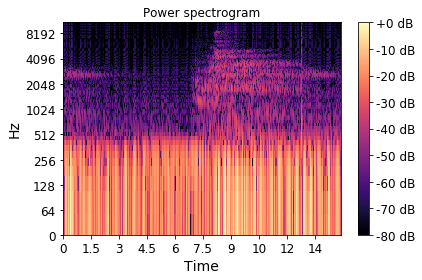

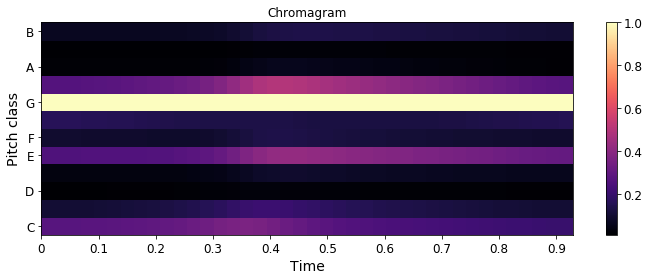

In [63]:
import librosa

sample = librosa.core.stft(y=X_load[0], n_fft=400, win_length=128, window='hamming', center=True, dtype=np.float, pad_mode='reflect')

sample_chroma = librosa.feature.chroma_stft(y=X_load[6], sr=44100, n_fft=20480, hop_length=520)

print(sample.shape)
print(sample_chroma.shape)
print(y_load[40])

import matplotlib.pyplot as plt
import librosa.display
librosa.display.specshow(librosa.amplitude_to_db(sample,ref=np.max),y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.figure(figsize=(10, 4))
librosa.display.specshow(sample_chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

In [6]:
import os
import librosa.display

processedData_path = "preprocessedSamples_spect.data"
processedX = np.zeros((len(X_load),256,16,1), dtype=np.float)
processedy = np.zeros(len(y_load), dtype=np.float)

for i in range(len(X_load)):
    sample = librosa.core.stft(y=X_load[i], n_fft=511, hop_length=None, win_length=256, window='hamming', center=True, dtype=np.float32, pad_mode='reflect')
    sample = np.atleast_3d(sample)
    processedX[i] = sample
    processedy[i] = y_load[i]

print(processedX[0].shape)

C:\Users\Denis\AppData\Local\conda\conda\envs\tensorflow_env_gpu\lib\site-packages\librosa\core\spectrum.py:180: ComplexWarning: Casting complex values to real discards the imaginary part
  axis=0)[:stft_matrix.shape[0]].conj()


(256, 16, 1)


In [7]:
from sklearn.utils import shuffle
shufled_processedX, shufled_processedy = shuffle(processedX, processedy)

for i in range(len(shufled_processedy)):
	shufled_processedy[i] = (shufled_processedy[i]) - 1

X_train = np.array(shufled_processedX[:-2000], dtype=np.float)
y_train = np.array(shufled_processedy[:-2000], dtype=np.float)

X_valid = np.array(shufled_processedX[-2000:-1000], dtype=np.float)
y_valid = np.array(shufled_processedy[-2000:-1000], dtype=np.float)

X_test = np.array(shufled_processedX[-1000:], dtype=np.float)
y_test = np.array(shufled_processedy[-1000:], dtype=np.float)
print(y_test[999])
print(X_test[999])

print(X_train.shape,y_train.shape, X_valid.shape, y_valid.shape)

n_outputs = len(np.unique(shufled_processedy))
print(np.unique(shufled_processedy))
n_outputs

8.0
[[[ -3.23619366e+00]
  [  1.16145933e+00]
  [  1.21057081e+00]
  ..., 
  [  8.59650016e-01]
  [  4.54807669e-01]
  [ -1.19688570e+00]]

 [[  4.64826250e+00]
  [ -2.10059786e+00]
  [ -1.34036231e+00]
  ..., 
  [ -2.12062287e+00]
  [ -6.82256743e-02]
  [  1.45642459e+00]]

 [[ -6.66698265e+00]
  [  3.38708758e+00]
  [  1.96856248e+00]
  ..., 
  [  5.07859612e+00]
  [ -1.27503741e+00]
  [ -1.46690404e+00]]

 ..., 
 [[  7.42667494e-03]
  [ -4.38474258e-03]
  [  4.27595153e-03]
  ..., 
  [  1.88071874e-03]
  [ -2.20070337e-03]
  [  1.06912935e-02]]

 [[  7.41749862e-03]
  [ -7.36583082e-04]
  [  4.51048696e-03]
  ..., 
  [  1.76071131e-03]
  [ -1.98100437e-03]
  [ -1.39174249e-03]]

 [[ -7.44780758e-03]
  [  1.76233775e-03]
  [ -4.39368002e-03]
  ..., 
  [ -1.82072457e-03]
  [  2.09195470e-03]
  [ -2.17995001e-03]]]
(12377, 256, 16, 1) (12377,) (1000, 256, 16, 1) (1000,)
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22. 

48

In [26]:
import tensorflow as tf

reset_graph()

height = 12
width = 80
channels = 1
n_inputs = height * width
n_outputs = 48

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1_fmaps = 32 #filters
conv1_ksize = 5
conv1_stride = 1
conv1_pad = "SAME"
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")

pool1_fmaps = conv1_fmaps
with tf.name_scope("pool1"):
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    

conv2_fmaps = 64
conv2_ksize = 5
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.2
conv2 = tf.layers.conv2d(pool1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

pool2_fmaps = conv2_fmaps
with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_flat = tf.reshape(pool2, shape=[-1, 3 * 20 * pool2_fmaps])
    pool2_flat_drop = tf.layers.dropout(pool2_flat, conv2_dropout_rate, training=training)

n_fc1 = 600
fc1_dropout_rate = 0.2
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool2_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1_drop, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [27]:
n_epochs = 1000
batch_size = 40

best_loss_val = np.infty
check_interval = 10
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train))
        idx = 0
        for rnd_indices in np.array_split(rnd_idx, len(X_train) // batch_size):
        #for idx in range(len(X_train) // batch_size):
#             print(idx)
#             X_reshaped = np.reshape(X_train[idx],(1, -1))
#             y_reshaped = np.reshape(y_train[idx],(-1))
#             print(X_reshaped.shape)
#             print(y_reshaped.shape)
            X_batch, y_batch = X_train[rnd_indices], y_train[rnd_indices].astype(int)
            X_batch_reshaped = np.reshape(X_batch,(len(X_batch), -1))
            y_batch_reshaped = np.reshape(y_batch,(-1))
            sess.run(training_op, feed_dict={X: X_batch_reshaped, y: y_batch, training: True})
            if idx % check_interval == 0:
                X_valid_reshaped = np.reshape(X_valid,(len(X_valid), -1))
                loss_val = loss.eval(feed_dict={X: X_valid_reshaped,
                                                y: y_valid})
                print(loss_val)
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
            idx += 1
        X_batch_reshaped = np.reshape(X_batch,(len(X_batch), -1))
        acc_train = accuracy.eval(feed_dict={X: X_batch_reshaped, y: y_batch})
        X_valid_reshaped = np.reshape(X_valid,(len(X_valid), -1))
        acc_val = accuracy.eval(feed_dict={X: X_valid_reshaped,
                                           y: y_valid})
        print("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_train * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    X_test_reshaped = np.reshape(X_test,(len(X_test), -1))
    acc_test = accuracy.eval(feed_dict={X: X_test_reshaped,
                                        y: y_test})
    print("Final accuracy on test set:", acc_test)
    #save_path = saver.save(sess, "./my_mnist_model")

3.84185
3.55779
2.94268
Epoch 0, train accuracy: 37.5000%, valid. accuracy: 40.4624%, valid. best loss: 2.942683
2.17021
1.5232
1.37907
Epoch 1, train accuracy: 67.5000%, valid. accuracy: 66.4740%, valid. best loss: 1.379066
1.25059
0.963855
0.991217
Epoch 2, train accuracy: 82.5000%, valid. accuracy: 75.1445%, valid. best loss: 0.963855
0.880133
0.911894
0.762544
Epoch 3, train accuracy: 77.5000%, valid. accuracy: 72.8324%, valid. best loss: 0.762544
0.768554
0.73361
0.771953
Epoch 4, train accuracy: 90.0000%, valid. accuracy: 76.8786%, valid. best loss: 0.733610
0.762853
0.757052
0.725783
Epoch 5, train accuracy: 97.5000%, valid. accuracy: 78.0347%, valid. best loss: 0.725783
0.814985
0.719421
0.702218
Epoch 6, train accuracy: 87.5000%, valid. accuracy: 78.6127%, valid. best loss: 0.702218
0.781102
0.678829
0.631197
Epoch 7, train accuracy: 95.0000%, valid. accuracy: 80.3468%, valid. best loss: 0.631197
0.614668
0.610057
0.677138
Epoch 8, train accuracy: 92.5000%, valid. accuracy: 79